<a href="https://colab.research.google.com/github/ahinagangopadhyay/Outdoor-Air-Quality/blob/main/clustering_aww.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
columns_to_retain = ['Timestamp', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)','AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

# Function to extract city and year from filename
def extract_city_from_filename(filename, city_list):
    temp = filename.split('_')

    try:
        year = int(temp[3])
    except ValueError:
        print(f"Error: Year not found in filename: {filename}")
        return None, None

    city = temp[-3].strip().lower()

    # Special city handling (keeping your handling intact)
    special_city_mapping = {
        'kalaburgi': 'kalaburagi',
        'chamarajanagara': 'chamarajanagar',
        'chikkamagaluru': 'chikkamagaluru',
        'aizawl': 'aizawl',
        'imphal': 'imphal',
        'jaipur': 'jaipur',
        'chennai': 'chennai',
        'palkalaiperur': 'palkalaiperur'
    }


    for key, value in special_city_mapping.items():
        if key in city:
            print(f"Special handling for city: {value} in file {filename}")
            city = value
    if filename == 'Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv':
        city = 'palkalaipeirur'
    # Check if city is in the city list; otherwise, try to extract an alternate city name
    if city not in city_list:
        print(f"City '{city}' not found in city_list. Trying alternate city extraction...")
        city = temp[-4].strip().lower()

    if city not in city_list:
        print(f"City '{city}' still not found in city_list. Skipping file: {filename}")
        return None, None

    return city, year

# Function to apply Min-Max Scaling to pollutants
def apply_min_max_scaling(df, pollutants):
    scaler = MinMaxScaler()
    df[pollutants] = scaler.fit_transform(df[pollutants])
    return df

# Function to categorize time of day
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Function to get windy weeks for a specific city from the weather_week_data.csv
def get_windy_weeks_for_city(city_name, weather_week_data):
    windy_weeks = weather_week_data['windy_weeks'].dropna().apply(lambda x: [int(week) for week in x.split(',')])
    return windy_weeks

# Function to process files for each city
def process_files(data_directory, city_files, city, year_list):
    all_data = []

    # Process each file for the given city
    for file in city_files:
        file_path = os.path.join(data_directory, file)
        print(f"Processing file: {file}")  # Print the file being processed

        # Read the file
        df = pd.read_csv(file_path)

        # Define columns to retain
        df = df[columns_to_retain]
        print(f"Before dropping NaN rows, remaining data in file: {file}")
        print(df.isna().sum())  # Print the count of NaN values per column after drop
        print(df.head())  # Print first few rows to check the data
        df=df.dropna()
        print(f"After dropping NaN rows, remaining data in file: {file}")
        print(df.isna().sum())  # Print the count of NaN values per column after drop
        print(df.head())  # Print first few rows to check the data

        # Add necessary datetime columns and time-based features (adjust this section as needed)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
       #df.dropna(subset=['Timestamp'], inplace=True)
        df['Year'] = df['Timestamp'].dt.year
        df['Month'] = df['Timestamp'].dt.month
        df['Week_Number'] = df['Timestamp'].dt.isocalendar().week
        df['Day_of_Week'] = df['Timestamp'].dt.dayofweek
        df['Hour'] = df['Timestamp'].dt.hour
        df['Time_of_Day'] = df['Hour'].apply(categorize_time_of_day)

        # Filter the data for valid years
        df = df[df['Year'].isin(year_list)]

        # Add the city name to the dataframe
        df['City'] = city

        # Append the current city's data
        all_data.append(df)

    # Combine data from all files for the current city
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

# Function to aggregate statistics for windy weeks combined
def aggregate_windy_week_stats(df):
    result_dict = {}
    pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']

    # Filter for windy weeks only
    windy_df = df[df['Windy_Week'] == True]

    if not windy_df.empty:
       result_dict['City'] = city
       for pollutant in pollutants:
            # Overall statistics for windy weeks
            result_dict[f'{pollutant.split()[0].lower()}_windy_mean'] = windy_df[pollutant].mean()
            result_dict[f'{pollutant.split()[0].lower()}_windy_std'] = windy_df[pollutant].std()
            result_dict[f'{pollutant.split()[0].lower()}_windy_min'] = windy_df[pollutant].min()
            result_dict[f'{pollutant.split()[0].lower()}_windy_max'] = windy_df[pollutant].max()
            result_dict[f'{pollutant.split()[0].lower()}_windy_50q'] = windy_df[pollutant].quantile(0.5)
            result_dict[f'{pollutant.split()[0].lower()}_windy_75q'] = windy_df[pollutant].quantile(0.75)
            result_dict[f'{pollutant.split()[0].lower()}_windy_25q'] = windy_df[pollutant].quantile(0.25)

            # Time-of-day statistics (morning, afternoon, evening, night) for windy weeks
            for time_of_day in ['Morning', 'Afternoon', 'Evening', 'Night']:
                time_based_df = windy_df[windy_df['Time_of_Day'] == time_of_day]
                if not time_based_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_windy_mean'] = time_based_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_windy_std'] = time_based_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_windy_min'] = time_based_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_windy_max'] = time_based_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_windy_50q'] = time_based_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_windy_75q'] = time_based_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_windy_25q'] = time_based_df[pollutant].quantile(0.25)

            # Day-of-week statistics for windy weeks
            for day_of_week in range(7):  # 0=Monday, 6=Sunday
                day_of_week_df = windy_df[windy_df['Day_of_Week'] == day_of_week]
                if not day_of_week_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_windy_mean'] = day_of_week_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_windy_std'] = day_of_week_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_windy_min'] = day_of_week_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_windy_max'] = day_of_week_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_windy_50q'] = day_of_week_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_windy_75q'] = day_of_week_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_windy_25q'] = day_of_week_df[pollutant].quantile(0.25)

            # Month statistics for windy weeks
            for month in range(1, 13):  # 1=January, 12=December
                month_df = windy_df[windy_df['Month'] == month]
                if not month_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_windy_mean'] = month_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_windy_std'] = month_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_windy_min'] = month_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_windy_max'] = month_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_windy_50q'] = month_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_windy_75q'] = month_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_windy_25q'] = month_df[pollutant].quantile(0.25)

    return result_dict

# Now, using the `combined_df` for further processing
all_stats = []
city_files_dict = {}

# Read lookup and weather week data files
lookup_file = "/content/drive/MyDrive/Copy of parameters_metadata.csv"
final_stat_marker_file = "/content/drive/MyDrive/Final_stat_CityWise_Marker - Updated.csv"
weather_week_data_file = "/content/drive/MyDrive/weather_week_numbers.csv"

# Read lookup and final statistics files
lookup_df = pd.read_csv(lookup_file)
final_stat_marker_df = pd.read_csv(final_stat_marker_file)

# Filter for flagged=False
lookup_df = lookup_df[lookup_df['flagged'] == False]

# Get the list of cities
city_list = final_stat_marker_df['City'].unique().tolist()
city_list = [city.lower() for city in city_list]

# Read the weather week data to get windy weeks
weather_week_data = pd.read_csv(weather_week_data_file)

# List of valid years
year_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Iterate over each file in the directory and process city-based data
all_files = os.listdir("/content/drive/MyDrive/Master Dataset")
city_files_dict = {}

for file in all_files:
    if file in lookup_df['filename'].values:
        city, year = extract_city_from_filename(file, city_list)
        if city and year in year_list:
            if city not in city_files_dict:
                city_files_dict[city] = []
            city_files_dict[city].append(file)

# Loop through the cities and process the data for each city
for city, city_files in city_files_dict.items():
    print(f"Processing data for city: {city}")

    # Get the combined data for this city
    combined_df = process_files("/content/drive/MyDrive/Master Dataset", city_files, city, year_list)

    # Extract windy data based on windy weeks for the current city
    windy_weeks = get_windy_weeks_for_city(city, weather_week_data)

    # Mark the rows for windy weeks
    combined_df['Windy_Week'] = combined_df['Week_Number'].apply(lambda week: week in windy_weeks)

    # Filter out data for windy weeks only
    windy_df = combined_df[combined_df['Windy_Week'] == True]

    if not windy_df.empty:
        # Optionally apply Min-Max scaling to pollutants if needed
        pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']
        windy_df = apply_min_max_scaling(windy_df, pollutants)

        # Aggregate statistics for windy weeks
        windy_stats = aggregate_windy_week_stats(windy_df)

        # Append city-wise windy data to the all_stats list
        all_stats.append(windy_stats)

# Combine all windy data from all cities into one DataFrame
if all_stats:
    combined_windy_df = pd.DataFrame(all_stats)
    print(f"Combined windy data for all cities: {combined_windy_df.shape}")

    # Perform further operations with `combined_windy_df` if needed
    # Example: Save the combined windy data
    windy_data_file_path = "/content/drive/MyDrive/all_cities_windy_week_data.csv"
    combined_windy_df.to_csv(windy_data_file_path, index=False)
    print(f"Saved all windy week data for all cities to: {windy_data_file_path}")
else:
    print("No windy data found for any city.")

City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'meghalaya' not found in city_list. Trying alternate city extraction...
City 'meghalaya' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Try

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: surat
Processing file: Raw_data_15Min_2023_site_5664_Science_Center_Surat_SMC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5664_Science_Center_Surat_SMC_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     8969
PM10 (µg/m³)     10224
CO (mg/m³)        1330
AT (°C)           3313
RH (%)            3313
WS (m/s)          3313
WD (deg)          3313
TOT-RF (mm)          0
BP (mmHg)         3313
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          52.00         72.16        0.57    20.91   
1  2023-01-01 00:15:00          52.00         72.00        0.57    20.76   
2  2023-01-01 00:30:00          52.00         72.00        0.58    20.48   
3  2023-01-01 00:45:00          52.00         72.00        0.57    20.40   
4  2023-01-01 01:00:00          79.07        105.00        0.56    20.16   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   57.51      

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Streaming output truncated to the last 5000 lines.
3    93.5       0.1     247.0          0.0      991.8  
4    93.9       0.2     274.9          0.0      991.7  
Processing file: Raw_data_15Min_2020_site_1429_Nehru_Nagar_Delhi_DPCC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_1429_Nehru_Nagar_Delhi_DPCC_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1063
PM10 (µg/m³)     1021
CO (mg/m³)       2857
AT (°C)           907
RH (%)            866
WS (m/s)         1589
WD (deg)          989
TOT-RF (mm)         0
BP (mmHg)         905
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         8.8      6.2   
1  2020-01-01 00:15:00            NaN           NaN         8.7      6.1   
2  2020-01-01 00:30:00            NaN           NaN         7.8      6.0   
3  2020-01-01 00:45:00          972.0           NaN         7.6      5.9   
4  2020-01-01 01:00:00         

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bilaspur
Processing file: Raw_data_15Min_2023_site_5503_Mangala_Bilaspur_NTPC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5503_Mangala_Bilaspur_NTPC_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7452
PM10 (µg/m³)      8332
CO (mg/m³)       10703
AT (°C)           5245
RH (%)            5323
WS (m/s)          5602
WD (deg)          5607
TOT-RF (mm)          0
BP (mmHg)         5248
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          26.40         79.76         1.8    33.98   
1  2023-01-01 00:15:00          19.77         66.27         1.8    34.15   
2  2023-01-01 00:30:00          18.65         64.19         1.6    34.16   
3  2023-01-01 00:45:00          18.65         64.19         1.7    34.22   
4  2023-01-01 01:00:00          18.65         64.19         2.5    34.27   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   50.96      0.1

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: naharlagun
Processing file: Raw_data_15Min_2023_site_5446_Naharlagun_Naharlagun_APSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5446_Naharlagun_Naharlagun_APSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    16015
PM10 (µg/m³)     16756
CO (mg/m³)       12962
AT (°C)          21987
RH (%)           21987
WS (m/s)         21989
WD (deg)         21987
TOT-RF (mm)          0
BP (mmHg)        22008
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gaya
Processing file: Raw_data_15Min_2023_site_5338_SFTI_Kusdihra_Gaya_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5338_SFTI_Kusdihra_Gaya_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2912
PM10 (µg/m³)     2710
CO (mg/m³)       1267
AT (°C)          1705
RH (%)           1708
WS (m/s)         1758
WD (deg)         1720
TOT-RF (mm)         0
BP (mmHg)        1704
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         130.48        157.37        1.88    13.82   
1  2023-01-01 00:15:00         130.48        157.37        1.90    13.30   
2  2023-01-01 00:30:00         138.10        160.44        2.18    12.66   
3  2023-01-01 00:45:00         154.12        167.24        2.52    11.86   
4  2023-01-01 01:00:00         154.12        167.24        2.63    11.58   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.00      0.27    355

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hajipur
Processing file: Raw_data_15Min_2023_site_5337_Industrial_Area_Hajipur_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5337_Industrial_Area_Hajipur_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2882
PM10 (µg/m³)     2749
CO (mg/m³)       1493
AT (°C)          1879
RH (%)           1873
WS (m/s)         1984
WD (deg)         1873
TOT-RF (mm)         0
BP (mmHg)        1879
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          292.9         527.4        3.62    11.47   
1  2023-01-01 00:15:00          286.7         476.8        3.63    10.78   
2  2023-01-01 00:30:00          286.7         476.8        3.63    10.53   
3  2023-01-01 00:45:00          286.7         476.8        3.79    10.58   
4  2023-01-01 01:00:00          234.7         398.8        3.90    10.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.15    

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: muzaffarpur
Processing file: Raw_data_15Min_2023_site_5370_Buddha_Colony_Muzaffarpur_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5370_Buddha_Colony_Muzaffarpur_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4008
PM10 (µg/m³)     3933
CO (mg/m³)       1422
AT (°C)          4444
RH (%)           4435
WS (m/s)         2454
WD (deg)         2374
TOT-RF (mm)         0
BP (mmHg)        2335
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          597.2         652.0        1.85    14.35   
1  2023-01-01 00:15:00          597.2         652.0        1.79    14.15   
2  2023-01-01 00:30:00          485.0         540.0        1.79    13.93   
3  2023-01-01 00:45:00          475.6         529.0        1.78    13.86   
4  2023-01-01 01:00:00          475.6         529.0        1.81    13.84   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   8

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: patna
Processing file: Raw_data_15Min_2023_site_5262_Rajbansi_Nagar_Patna_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5262_Rajbansi_Nagar_Patna_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1656
PM10 (µg/m³)     1897
CO (mg/m³)        732
AT (°C)           819
RH (%)            820
WS (m/s)          844
WD (deg)          863
TOT-RF (mm)         0
BP (mmHg)         844
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          483.6         641.3        4.58    12.20   
1  2023-01-01 00:15:00          499.9         658.4        4.77    12.08   
2  2023-01-01 00:30:00          499.9         658.4        4.78    12.04   
3  2023-01-01 00:45:00          499.9         658.4        4.77    12.06   
4  2023-01-01 01:00:00          458.8         633.4        4.65    11.91   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.30      0.09  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: guwahati
Processing file: Raw_data_15Min_2023_site_5073_Railway_Colony_Guwahati_PCBA_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5073_Railway_Colony_Guwahati_PCBA_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     5949
PM10 (µg/m³)      5703
CO (mg/m³)        1803
AT (°C)          13952
RH (%)           13952
WS (m/s)         13952
WD (deg)         13952
TOT-RF (mm)          0
BP (mmHg)        14197
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         576.00        664.43         NaN    12.97   
1  2023-01-01 00:15:00         576.00        672.00        4.60    15.00   
2  2023-01-01 00:30:00         576.00        672.00        4.75    15.05   
3  2023-01-01 00:45:00         578.29        672.00        4.61    14.96   
4  2023-01-01 01:00:00            NaN           NaN        4.78    14.86   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: amaravati
Processing file: Raw_data_15Min_2023_site_1406_Secretariat_Amaravati_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1406_Secretariat_Amaravati_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5702
PM10 (µg/m³)     5101
CO (mg/m³)       5373
AT (°C)          4550
RH (%)           4769
WS (m/s)         4550
WD (deg)         4550
TOT-RF (mm)         0
BP (mmHg)        4550
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           43.0          79.0        0.64     22.2   
1  2023-01-01 00:15:00           43.0          79.0        0.62     22.2   
2  2023-01-01 00:30:00           43.0          79.0        0.62     22.2   
3  2023-01-01 00:45:00           41.0          79.0        0.64     22.1   
4  2023-01-01 01:00:00           41.0          79.0        0.62     22.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    96.0      

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: anantapur
Processing file: Raw_data_15Min_2023_site_5632_Gulzarpet_Anantapur_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5632_Gulzarpet_Anantapur_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4543
PM10 (µg/m³)     5130
CO (mg/m³)       5008
AT (°C)          3673
RH (%)           3689
WS (m/s)         7299
WD (deg)         3942
TOT-RF (mm)         0
BP (mmHg)        3804
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          16.90         44.50        0.74    23.49   
1  2023-01-01 00:15:00          17.16         44.06        0.89    23.18   
2  2023-01-01 00:30:00          18.18         42.18        1.00    22.89   
3  2023-01-01 00:45:00          18.18         42.18        1.09    22.67   
4  2023-01-01 01:00:00          18.18         42.18        1.54    22.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   63.18       NaN

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chittoor
Processing file: Raw_data_15Min_2022_site_5665_Gangineni_Cheruvu_Chittoor_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5665_Gangineni_Cheruvu_Chittoor_APPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    32734
PM10 (µg/m³)     32745
CO (mg/m³)       31521
AT (°C)          31343
RH (%)           31343
WS (m/s)         31343
WD (deg)         31344
TOT-RF (mm)          0
BP (mmHg)        33502
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kadapa
Processing file: Raw_data_15Min_2023_site_5693_Yerramukkapalli_Kadapa_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5693_Yerramukkapalli_Kadapa_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7702
PM10 (µg/m³)     7708
CO (mg/m³)       3482
AT (°C)          3368
RH (%)           3368
WS (m/s)         3407
WD (deg)         3417
TOT-RF (mm)         0
BP (mmHg)        4137
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN       

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: rajamahendravaram
Processing file: Raw_data_15Min_2023_site_1399_Anand_Kala_Kshetram_Rajamahendravaram_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1399_Anand_Kala_Kshetram_Rajamahendravaram_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3798
PM10 (µg/m³)     1384
CO (mg/m³)       5155
AT (°C)          1454
RH (%)           1149
WS (m/s)         1104
WD (deg)         1127
TOT-RF (mm)         0
BP (mmHg)        1104
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           34.0          64.0        0.69     29.9   
1  2023-01-01 00:15:00           34.0          64.0        0.77     29.5   
2  2023-01-01 00:30:00           34.0          64.0        0.72     29.3   
3  2023-01-01 00:45:00           47.0          83.0        0.65     29.8   
4  2023-01-01 01:00:00           47.0          83.0        0.66     29.6   

   RH (%)  WS (m/s)  WD (deg)  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tirupati
Processing file: Raw_data_15Min_2023_site_5666_Vaikuntapuram_Tirupati_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5666_Vaikuntapuram_Tirupati_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    8100
PM10 (µg/m³)     9194
CO (mg/m³)       2621
AT (°C)          7227
RH (%)           7226
WS (m/s)         2298
WD (deg)         2289
TOT-RF (mm)         0
BP (mmHg)        2301
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN     

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vijayawada
Processing file: Raw_data_15Min_2023_site_5685_Kanuru_Vijayawada_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5685_Kanuru_Vijayawada_APPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    12655
PM10 (µg/m³)     13410
CO (mg/m³)       12949
AT (°C)          10537
RH (%)           10559
WS (m/s)         10543
WD (deg)         10549
TOT-RF (mm)          0
BP (mmHg)        10538
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN   

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: visakhapatnam
Processing file: Raw_data_15Min_2023_site_260_GVM_Corporation_Visakhapatnam_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_260_GVM_Corporation_Visakhapatnam_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6717
PM10 (µg/m³)     6791
CO (mg/m³)       6620
AT (°C)          6029
RH (%)           6029
WS (m/s)         6027
WD (deg)         6033
TOT-RF (mm)         0
BP (mmHg)        5648
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           44.0          96.0        0.52     25.2   
1  2023-01-01 00:15:00           44.0          96.0        0.40     25.1   
2  2023-01-01 00:30:00           44.0          96.0        0.35     25.0   
3  2023-01-01 00:45:00           55.0         112.0        0.55     24.9   
4  2023-01-01 01:00:00           55.0         112.0        0.69     24.8   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: shillong
Processing file: Raw_data_15Min_2023_site_5593_JN_Stadium_Shillong_Meghalaya_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5593_JN_Stadium_Shillong_Meghalaya_PCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    23846
PM10 (µg/m³)     23266
CO (mg/m³)       22146
AT (°C)          23463
RH (%)           23463
WS (m/s)         23464
WD (deg)         23463
TOT-RF (mm)          0
BP (mmHg)        23463
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mm

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: agartala
Processing file: Raw_data_15Min_2022_site_5377_Kunjaban_Agartala_Tripura_SPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5377_Kunjaban_Agartala_Tripura_SPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     4298
PM10 (µg/m³)      3717
CO (mg/m³)        2299
AT (°C)          11594
RH (%)           12360
WS (m/s)         11624
WD (deg)         11594
TOT-RF (mm)          0
BP (mmHg)        21441
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN    10.60   
1  2022-01-01 00:15:00         118.00        181.00        1.05    10.36   
2  2022-01-01 00:30:00         118.00        181.00        1.10    10.64   
3  2022-01-01 00:45:00         118.00        181.00        1.09    15.62   
4  2022-01-01 01:00:00         123.82        205.18        1.09    12.50   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chandrapur
Processing file: Raw_data_15Min_2017_site_271_Chauhan_Colony_Chandrapur_MPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2017_site_271_Chauhan_Colony_Chandrapur_MPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    12287
PM10 (µg/m³)     10680
CO (mg/m³)        7802
AT (°C)          28626
RH (%)            9530
WS (m/s)          9528
WD (deg)         10825
TOT-RF (mm)          0
BP (mmHg)         9022
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2017-01-01 00:00:00           68.0         120.0        0.85      NaN   
1  2017-01-01 00:15:00           68.0         120.0        0.84      NaN   
2  2017-01-01 00:30:00           68.0         120.0        0.81      NaN   
3  2017-01-01 00:45:00          101.0         151.0        0.81      NaN   
4  2017-01-01 01:00:00          101.0         151.0        0.82      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kalyan
Processing file: Raw_data_15Min_2023_site_5118_Khadakpada_Kalyan_MPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5118_Khadakpada_Kalyan_MPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7006
PM10 (µg/m³)     9836
CO (mg/m³)       6440
AT (°C)          6626
RH (%)           6624
WS (m/s)         6625
WD (deg)         6625
TOT-RF (mm)         0
BP (mmHg)        6626
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           38.0         172.0        2.54    28.74   
1  2023-01-01 00:15:00           93.0         172.0        1.34    28.75   
2  2023-01-01 00:30:00           93.0         172.0        1.62    28.75   
3  2023-01-01 00:45:00           93.0         164.8        1.39    28.74   
4  2023-01-01 01:00:00           93.0         160.0        1.30    28.74   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   89.45      1.32    338.7

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: mumbai
Processing file: Raw_data_15Min_2020_site_5396_Deonar_Mumbai_IITM_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_5396_Deonar_Mumbai_IITM_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    30722
PM10 (µg/m³)     30724
CO (mg/m³)       30653
AT (°C)          30633
RH (%)           30634
WS (m/s)         33143
WD (deg)         30630
TOT-RF (mm)          0
BP (mmHg)        31768
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2020-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2020-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2020-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2020-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN       NaN       

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bhopal
Processing file: Raw_data_15Min_2023_site_5247_T_T_Nagar_Bhopal_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5247_T_T_Nagar_Bhopal_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1277
PM10 (µg/m³)     1212
CO (mg/m³)       3220
AT (°C)           938
RH (%)            938
WS (m/s)          938
WD (deg)          988
TOT-RF (mm)         0
BP (mmHg)         939
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           88.0         185.0        1.25     15.1   
1  2023-01-01 00:15:00           88.0         185.0        0.98     14.9   
2  2023-01-01 00:30:00           88.0         185.0        1.08     14.9   
3  2023-01-01 00:45:00           84.0         160.0        1.17     14.7   
4  2023-01-01 01:00:00           84.0         160.0        1.06     14.5   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    73.0       1.4     171.

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gwalior
Processing file: Raw_data_15Min_2023_site_5273_City_Center_Gwalior_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5273_City_Center_Gwalior_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2254
PM10 (µg/m³)     3932
CO (mg/m³)       5506
AT (°C)          1241
RH (%)           1241
WS (m/s)         1241
WD (deg)         1229
TOT-RF (mm)         0
BP (mmHg)        1241
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          334.0         432.0        1.72      7.8   
1  2023-01-01 00:15:00          334.0         432.0        1.49      7.9   
2  2023-01-01 00:30:00          334.0         432.0        1.35      7.8   
3  2023-01-01 00:45:00          256.0         355.0        1.50      7.8   
4  2023-01-01 01:00:00          256.0         355.0        1.58      7.8   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    95.0       0.3  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: indore
Processing file: Raw_data_15Min_2023_site_5248_Chhoti_Gwaltoli_Indore_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5248_Chhoti_Gwaltoli_Indore_MPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     1051
PM10 (µg/m³)      1081
CO (mg/m³)        3757
AT (°C)            848
RH (%)             849
WS (m/s)           849
WD (deg)           849
TOT-RF (mm)          0
BP (mmHg)        16036
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           35.0         149.0        0.74     16.2   
1  2023-01-01 00:15:00           35.0         149.0        0.65     15.9   
2  2023-01-01 00:30:00           35.0         149.0        1.04     16.0   
3  2023-01-01 00:45:00           37.0         176.0        1.24     16.0   
4  2023-01-01 01:00:00           37.0         176.0        1.15     16.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    6

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: jabalpur
Processing file: Raw_data_15Min_2023_site_5249_Marhatal_Jabalpur_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5249_Marhatal_Jabalpur_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1563
PM10 (µg/m³)     1545
CO (mg/m³)       4391
AT (°C)           811
RH (%)            811
WS (m/s)          811
WD (deg)          811
TOT-RF (mm)         0
BP (mmHg)         811
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          102.0         157.0        1.09     14.1   
1  2023-01-01 00:15:00          102.0         157.0        1.12     14.1   
2  2023-01-01 00:30:00          102.0         157.0         NaN     14.0   
3  2023-01-01 00:45:00           95.0         164.0         NaN     13.9   
4  2023-01-01 01:00:00           95.0         164.0         NaN     13.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    69.0       0.5     

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: katni
Processing file: Raw_data_15Min_2023_site_5250_Gole_Bazar_Katni_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5250_Gole_Bazar_Katni_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4940
PM10 (µg/m³)     8978
CO (mg/m³)       5170
AT (°C)          4188
RH (%)           4188
WS (m/s)         4188
WD (deg)         4189
TOT-RF (mm)         0
BP (mmHg)        4188
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          140.0         232.0        0.94     12.8   
1  2023-01-01 00:15:00          140.0         232.0         NaN     12.7   
2  2023-01-01 00:30:00          140.0         232.0        1.12     12.4   
3  2023-01-01 00:45:00          163.0         254.0        1.12     12.3   
4  2023-01-01 01:00:00          163.0         254.0        1.15     12.1   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    80.0       0.3     237.0

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: thiruvananthapuram
Processing file: Raw_data_15Min_2023_site_252_Plammoodu_Thiruvananthapuram_Kerala_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_252_Plammoodu_Thiruvananthapuram_Kerala_PCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6833
PM10 (µg/m³)     4991
CO (mg/m³)       2256
AT (°C)          2330
RH (%)           2329
WS (m/s)         2331
WD (deg)         2329
TOT-RF (mm)         0
BP (mmHg)        5953
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           52.0          81.0        0.98     23.2   
1  2023-01-01 00:15:00           52.0          81.0        0.98     23.2   
2  2023-01-01 00:30:00           52.0          81.0        0.98     23.1   
3  2023-01-01 00:45:00           66.0         100.0        0.97     23.0   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (m

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bagalkot
Processing file: Raw_data_15Min_2023_site_5264_Vidayagiri_Bagalkot_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5264_Vidayagiri_Bagalkot_KSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1797
PM10 (µg/m³)     2189
CO (mg/m³)       3275
AT (°C)          1516
RH (%)           2633
WS (m/s)         1525
WD (deg)         1494
TOT-RF (mm)         0
BP (mmHg)        2511
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           1.00           NaN        0.00    26.39   
1  2023-01-01 00:15:00          23.07         42.38        0.60    26.66   
2  2023-01-01 00:30:00          23.26         42.70        0.68    26.89   
3  2023-01-01 00:45:00          22.98         42.22        0.56    26.93   
4  2023-01-01 01:00:00          23.33         42.82        0.70    26.43   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    63.0      2.37 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bengaluru
Processing file: Raw_data_15Min_2022_site_1558_Silk_Board_Bengaluru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_1558_Silk_Board_Bengaluru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7963
PM10 (µg/m³)      8047
CO (mg/m³)       11296
AT (°C)           7076
RH (%)            7063
WS (m/s)          7061
WD (deg)          7063
TOT-RF (mm)          0
BP (mmHg)        23139
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN        0.17     18.5   
1  2022-01-01 00:15:00            NaN           NaN        0.22     18.5   
2  2022-01-01 00:30:00            NaN           NaN        0.16     18.5   
3  2022-01-01 00:45:00            NaN           NaN         NaN     18.4   
4  2022-01-01 01:00:00            NaN           NaN        0.23     18.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    88

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chamarajanagar
Processing file: Raw_data_15Min_2021_site_5124_Urban_Chamarajanagar_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2021_site_5124_Urban_Chamarajanagar_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     8303
PM10 (µg/m³)      8145
CO (mg/m³)        7428
AT (°C)          33053
RH (%)           33021
WS (m/s)         12898
WD (deg)         12051
TOT-RF (mm)          0
BP (mmHg)         8168
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2021-01-01 00:00:00          16.20           NaN        0.30      NaN   
1  2021-01-01 00:15:00          15.84         35.36        0.28      NaN   
2  2021-01-01 00:30:00          16.26         33.33        0.28      NaN   
3  2021-01-01 00:45:00          16.48         34.52        0.28      NaN   
4  2021-01-01 01:00:00          15.88         35.78        0.29      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: dharwad
Processing file: Raw_data_15Min_2023_site_5638_Kalabhavan_Dharwad_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5638_Kalabhavan_Dharwad_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10807
PM10 (µg/m³)     10100
CO (mg/m³)        6806
AT (°C)           6029
RH (%)            6116
WS (m/s)          7952
WD (deg)          7165
TOT-RF (mm)          0
BP (mmHg)         6039
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          47.76         84.22        0.93    23.75   
1  2023-01-01 00:15:00          47.76         84.22        1.06    23.67   
2  2023-01-01 00:30:00          47.76         84.22        0.99    23.56   
3  2023-01-01 00:45:00          46.13         76.20        0.85    23.56   
4  2023-01-01 01:00:00          45.51         73.11        0.93    23.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   11.52    

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hubballi
Processing file: Raw_data_15Min_2023_site_5680_Lingaraj_Nagar_Hubballi_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5680_Lingaraj_Nagar_Hubballi_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6594
PM10 (µg/m³)      7465
CO (mg/m³)        6205
AT (°C)           4545
RH (%)            4577
WS (m/s)         11155
WD (deg)         11109
TOT-RF (mm)          0
BP (mmHg)        12476
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          66.66        128.96        0.48    23.79   
1  2023-01-01 00:15:00          66.66        128.96        0.49    23.67   
2  2023-01-01 00:30:00          66.66        129.85        0.50    23.73   
3  2023-01-01 00:45:00          66.66        130.51        0.50    23.68   
4  2023-01-01 01:00:00          60.91        130.51        0.49    23.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kalaburagi
Processing file: Raw_data_15Min_2023_site_5679_Mahatma_Basaveswar_Colony_Kalaburgi_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5679_Mahatma_Basaveswar_Colony_Kalaburgi_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    13238
PM10 (µg/m³)     13013
CO (mg/m³)       12726
AT (°C)          12585
RH (%)           12504
WS (m/s)         12857
WD (deg)         12858
TOT-RF (mm)          0
BP (mmHg)        12421
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          65.70         86.04        0.98     21.5   
1  2023-01-01 00:15:00          65.70         86.04        0.99     21.5   
2  2023-01-01 00:30:00          60.79         81.13        1.07     21.5   
3  2023-01-01 00:45:00          59.48         79.82        1.07     21.5   
4  2023-01-01 01:00:00          59.48         79.82        1.05     21.5   

   RH (%)  WS (m/s)  WD (deg)  T

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: mysuru
Processing file: Raw_data_15Min_2021_site_5125_Hebbal_1st_Stage_Mysuru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2021_site_5125_Hebbal_1st_Stage_Mysuru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6353
PM10 (µg/m³)      6642
CO (mg/m³)        6418
AT (°C)          33765
RH (%)            6110
WS (m/s)          6167
WD (deg)          6606
TOT-RF (mm)          0
BP (mmHg)         6111
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2021-01-01 00:00:00          21.12         66.37        0.35      NaN   
1  2021-01-01 00:15:00          19.37         66.37        0.27      NaN   
2  2021-01-01 00:30:00          16.74         66.37        0.26      NaN   
3  2021-01-01 00:45:00          16.74         52.51        0.23      NaN   
4  2021-01-01 01:00:00          16.74         51.69        0.22      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: shivamogga
Processing file: Raw_data_15Min_2022_site_5266_Vinoba_Nagara_Shivamogga_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5266_Vinoba_Nagara_Shivamogga_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2520
PM10 (µg/m³)      2311
CO (mg/m³)       15555
AT (°C)           2126
RH (%)           15691
WS (m/s)         16079
WD (deg)         16097
TOT-RF (mm)          0
BP (mmHg)         2112
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN         47.91         NaN    21.81   
1  2022-01-01 00:15:00          23.53         47.91         NaN    21.70   
2  2022-01-01 00:30:00          23.32         47.61         NaN    21.60   
3  2022-01-01 00:45:00          23.46         47.04         NaN    21.36   
4  2022-01-01 01:00:00          22.12         47.04         NaN    21.20   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg) 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tumakuru
Processing file: Raw_data_15Min_2022_site_5682_Thimmalapura_Tumakuru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5682_Thimmalapura_Tumakuru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    33508
PM10 (µg/m³)     33283
CO (mg/m³)       32857
AT (°C)          32863
RH (%)           32862
WS (m/s)         32895
WD (deg)         32895
TOT-RF (mm)          0
BP (mmHg)        32862
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vijayapura
Processing file: Raw_data_15Min_2023_site_5267_Ibrahimpur_Vijayapura_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5267_Ibrahimpur_Vijayapura_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     1635
PM10 (µg/m³)      1953
CO (mg/m³)        5013
AT (°C)           1542
RH (%)            1549
WS (m/s)         19473
WD (deg)         16680
TOT-RF (mm)          0
BP (mmHg)         1549
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           4.00          8.00       10.00    20.99   
1  2023-01-01 00:15:00          19.50         53.10        0.09    20.96   
2  2023-01-01 00:30:00          20.24         53.84        0.58    20.88   
3  2023-01-01 00:45:00          19.42         53.02        0.04    20.88   
4  2023-01-01 01:00:00          20.32         53.92        0.64    20.88   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kolkata
Processing file: Raw_data_15Min_2023_site_5111_Jadavpur_Kolkata_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5111_Jadavpur_Kolkata_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1372
PM10 (µg/m³)     1424
CO (mg/m³)       1283
AT (°C)           965
RH (%)            965
WS (m/s)         1051
WD (deg)          964
TOT-RF (mm)         0
BP (mmHg)         963
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         123.28        224.03        1.31    18.75   
1  2023-01-01 00:15:00         124.61        218.47        1.30    18.79   
2  2023-01-01 00:30:00         124.61        218.47        1.28    18.80   
3  2023-01-01 00:45:00         124.61        218.47        1.29    18.67   
4  2023-01-01 01:00:00         123.88        217.91        1.28    18.71   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.50      0.12     99.

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kashipur
Processing file: Raw_data_15Min_2023_site_5704_Govt._Girls_Inter_College_Kashipur_UKPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5704_Govt._Girls_Inter_College_Kashipur_UKPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    14046
PM10 (µg/m³)     14097
CO (mg/m³)       13806
AT (°C)          13573
RH (%)           16247
WS (m/s)         13718
WD (deg)         13710
TOT-RF (mm)          0
BP (mmHg)        13809
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-R

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: rishikesh
Processing file: Raw_data_15Min_2023_site_5703_Shivaji_Nagar_Rishikesh_UKPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5703_Shivaji_Nagar_Rishikesh_UKPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5560
PM10 (µg/m³)     5535
CO (mg/m³)       6444
AT (°C)          4645
RH (%)           4645
WS (m/s)         4653
WD (deg)         4668
TOT-RF (mm)         0
BP (mmHg)        4678
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: puducherry
Processing file: Raw_data_15Min_2023_site_5423_Jawahar_Nagar_Puducherry_PPCC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5423_Jawahar_Nagar_Puducherry_PPCC_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3333
PM10 (µg/m³)     2677
CO (mg/m³)       1448
AT (°C)           656
RH (%)            656
WS (m/s)          656
WD (deg)          665
TOT-RF (mm)         0
BP (mmHg)         656
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           18.0          43.0        1.05     26.9   
1  2023-01-01 00:15:00           18.0          43.0        1.25     26.6   
2  2023-01-01 00:30:00           18.0           NaN        1.13     26.4   
3  2023-01-01 00:45:00          103.0         146.0        1.36     26.2   
4  2023-01-01 01:00:00          103.0         146.0        1.57     26.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    81.0 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kohima
Processing file: Raw_data_15Min_2022_site_5375_PWD_Juction_Kohima_NPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5375_PWD_Juction_Kohima_NPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10104
PM10 (µg/m³)      7977
CO (mg/m³)        4504
AT (°C)          20116
RH (%)           20251
WS (m/s)         20123
WD (deg)         20116
TOT-RF (mm)          0
BP (mmHg)        20122
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN    10.39   
1  2022-01-01 00:15:00           22.0          41.0        0.46    10.41   
2  2022-01-01 00:30:00           22.0          41.0        0.45    10.12   
3  2022-01-01 00:45:00           20.5          47.0        0.43    10.00   
4  2022-01-01 01:00:00           30.0          53.0        0.42     9.79   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   75.30      1

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: agra
Processing file: Raw_data_15Min_2023_site_307_Sanjay_Palace_Agra_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_307_Sanjay_Palace_Agra_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2132
PM10 (µg/m³)     3511
CO (mg/m³)       2258
AT (°C)           112
RH (%)            208
WS (m/s)          112
WD (deg)          132
TOT-RF (mm)         0
BP (mmHg)         112
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           46.0          92.0        0.88     11.9   
1  2023-01-01 00:15:00           46.0          92.0        0.89     11.6   
2  2023-01-01 00:30:00           46.0          92.0        0.84     11.3   
3  2023-01-01 00:45:00           39.0          90.0        0.90     11.1   
4  2023-01-01 01:00:00           39.0          70.0        0.93     10.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    78.0       0.2      53.

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: baghpat
Processing file: Raw_data_15Min_2023_site_5585_Sardar_Patel_Inter_College_Baghpat_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5585_Sardar_Patel_Inter_College_Baghpat_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7108
PM10 (µg/m³)      6145
CO (mg/m³)        9507
AT (°C)          13085
RH (%)            4728
WS (m/s)          4728
WD (deg)          4736
TOT-RF (mm)          0
BP (mmHg)         4728
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          118.0         169.0        0.49     16.3   
1  2023-01-01 00:15:00          118.0         169.0        0.50     16.2   
2  2023-01-01 00:30:00          118.0         169.0        0.50     16.3   
3  2023-01-01 00:45:00          100.0         138.0        0.50     16.3   
4  2023-01-01 01:00:00          100.0         138.0        0.48     16.2   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: haldia
Processing file: Raw_data_15Min_2023_site_300_Priyambada_Housing_Estate_Haldia_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_300_Priyambada_Housing_Estate_Haldia_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2718
PM10 (µg/m³)     2681
CO (mg/m³)       2087
AT (°C)          1756
RH (%)           1756
WS (m/s)         1772
WD (deg)         1846
TOT-RF (mm)         0
BP (mmHg)        1758
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          51.35        109.85        1.02    19.53   
1  2023-01-01 00:15:00          50.97        113.96        1.05    19.58   
2  2023-01-01 00:30:00          50.59        119.30        1.03    19.52   
3  2023-01-01 00:45:00          50.59        119.30        1.00    19.35   
4  2023-01-01 01:00:00          50.59        119.30        1.00    19.30   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg) 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bareilly
Processing file: Raw_data_15Min_2023_site_5601_Rajendra_Nagar_Bareilly_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5601_Rajendra_Nagar_Bareilly_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3381
PM10 (µg/m³)     3130
CO (mg/m³)       1616
AT (°C)          1719
RH (%)           1719
WS (m/s)         1868
WD (deg)         1874
TOT-RF (mm)         0
BP (mmHg)        1719
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          62.19         94.86        2.14    10.01   
1  2023-01-01 00:15:00          60.02         95.46        2.16     9.91   
2  2023-01-01 00:30:00          60.02         95.46        2.16     9.74   
3  2023-01-01 00:45:00          60.02         95.46        2.11     9.82   
4  2023-01-01 01:00:00          63.61         92.73        2.04     9.89   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   97.63   

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bulandshahr
Processing file: Raw_data_15Min_2023_site_1542_Yamunapuram_Bulandshahr_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1542_Yamunapuram_Bulandshahr_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1312
PM10 (µg/m³)     1115
CO (mg/m³)       5213
AT (°C)           719
RH (%)            714
WS (m/s)          714
WD (deg)         1016
TOT-RF (mm)         0
BP (mmHg)         916
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          110.0           NaN        1.32     12.5   
1  2023-01-01 00:15:00          110.0         200.0        1.28     12.5   
2  2023-01-01 00:30:00          110.0         200.0        1.28     12.5   
3  2023-01-01 00:45:00          107.0         201.0        1.32     12.4   
4  2023-01-01 01:00:00          107.0         201.0        1.35     12.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    77.0

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: firozabad
Processing file: Raw_data_15Min_2023_site_5480_Nagla_Bhau_Firozabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5480_Nagla_Bhau_Firozabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7444
PM10 (µg/m³)     7128
CO (mg/m³)        863
AT (°C)          1194
RH (%)           1194
WS (m/s)         1245
WD (deg)         1245
TOT-RF (mm)         0
BP (mmHg)        1194
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          35.26         67.40        0.84    11.84   
1  2023-01-01 00:15:00          35.26         61.89        0.83    11.47   
2  2023-01-01 00:30:00          35.26         66.18        0.80    11.23   
3  2023-01-01 00:45:00          35.26         66.18        0.78    11.10   
4  2023-01-01 01:00:00          33.61         59.30        0.76    10.90   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   91.11      0.

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gorakhpur
Processing file: Raw_data_15Min_2023_site_5472_Madan_Mohan_Malaviya_University_of_Technology_Gorakhpur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5472_Madan_Mohan_Malaviya_University_of_Technology_Gorakhpur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3675
PM10 (µg/m³)     2842
CO (mg/m³)        473
AT (°C)           477
RH (%)            477
WS (m/s)          477
WD (deg)          477
TOT-RF (mm)         0
BP (mmHg)         477
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         113.34        214.90        2.12    14.25   
1  2023-01-01 00:15:00         113.34        214.90        2.11    13.92   
2  2023-01-01 00:30:00         113.34        214.90        2.10    13.94   
3  2023-01-01 00:45:00         113.34        214.90        2.13    13.88   
4  2023-01-01 01:00:00         105.66        201.05        2.10    13.66   

   

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hapur
Processing file: Raw_data_15Min_2023_site_5023_Anand_Vihar_Hapur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5023_Anand_Vihar_Hapur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2232
PM10 (µg/m³)     5185
CO (mg/m³)       5293
AT (°C)          2711
RH (%)           2483
WS (m/s)         2487
WD (deg)         2485
TOT-RF (mm)         0
BP (mmHg)        2483
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           54.0          90.0        1.34     12.0   
1  2023-01-01 00:15:00           54.0          90.0        1.35     11.8   
2  2023-01-01 00:30:00           54.0          90.0        1.33     11.7   
3  2023-01-01 00:45:00           53.0           NaN        1.33     11.4   
4  2023-01-01 01:00:00           53.0           NaN        1.34     11.2   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    81.0       0.3      40

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ghaziabad
Processing file: Raw_data_15Min_2023_site_5081_Sanjay_Nagar_Ghaziabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5081_Sanjay_Nagar_Ghaziabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3270
PM10 (µg/m³)     3649
CO (mg/m³)       5662
AT (°C)           751
RH (%)           2997
WS (m/s)          749
WD (deg)          752
TOT-RF (mm)         0
BP (mmHg)         751
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           78.0         129.0        0.69     19.9   
1  2023-01-01 00:15:00           78.0         129.0        0.68     19.6   
2  2023-01-01 00:30:00           78.0         129.0        0.66     19.5   
3  2023-01-01 00:45:00           79.0         118.0        0.62     19.5   
4  2023-01-01 01:00:00           79.0         118.0        0.57     19.5   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    87.0    

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: jhansi
Processing file: Raw_data_15Min_2023_site_5583_Shivaji_Nagar_Jhansi_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5583_Shivaji_Nagar_Jhansi_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3399
PM10 (µg/m³)     3204
CO (mg/m³)        666
AT (°C)           684
RH (%)            684
WS (m/s)         1615
WD (deg)          710
TOT-RF (mm)         0
BP (mmHg)         684
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          93.53        253.27        1.44     9.73   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   94.75      0.31 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: noida
Processing file: Raw_data_15Min_2023_site_1541_Knowledge_Park_III_Greater_Noida_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1541_Knowledge_Park_III_Greater_Noida_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2212
PM10 (µg/m³)      1378
CO (mg/m³)        3137
AT (°C)           1480
RH (%)            1433
WS (m/s)          1434
WD (deg)         17108
TOT-RF (mm)          0
BP (mmHg)         1439
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          148.0         195.0        5.04      8.8   
1  2023-01-01 00:15:00          148.0         195.0        5.11      8.2   
2  2023-01-01 00:30:00          148.0         195.0        5.37      7.6   
3  2023-01-01 00:45:00          149.0         193.0        5.77      7.5   
4  2023-01-01 01:00:00          149.0         193.0        6.10      7.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm) 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kanpur
Processing file: Raw_data_15Min_2023_site_5500_FTI_Kidwai_Nagar_Kanpur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5500_FTI_Kidwai_Nagar_Kanpur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2687
PM10 (µg/m³)     1965
CO (mg/m³)        687
AT (°C)           739
RH (%)            739
WS (m/s)         1017
WD (deg)         1017
TOT-RF (mm)         0
BP (mmHg)         741
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         110.19        230.02        2.47    10.71   
1  2023-01-01 00:15:00         109.05        229.86        2.42    10.64   
2  2023-01-01 00:30:00         109.05        229.86        2.38    10.46   
3  2023-01-01 00:45:00         109.05        229.86        2.33    10.48   
4  2023-01-01 01:00:00          98.02        196.15        2.29    10.65   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   96.74     

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: khurja
Processing file: Raw_data_15Min_2023_site_5603_Kalindi_Kunj_Khurja_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5603_Kalindi_Kunj_Khurja_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     3056
PM10 (µg/m³)      2965
CO (mg/m³)         738
AT (°C)           2049
RH (%)            2049
WS (m/s)         11209
WD (deg)         11268
TOT-RF (mm)          0
BP (mmHg)         2049
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          79.54        129.25        0.40    10.76   
1  2023-01-01 00:15:00          80.64        131.04        0.39    10.66   
2  2023-01-01 00:30:00          80.64        131.04        0.39    10.62   
3  2023-01-01 00:45:00          80.64        131.04        0.37    10.38   
4  2023-01-01 01:00:00          67.88        110.29        0.36    10.25   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   85.38   

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: lucknow
Processing file: Raw_data_15Min_2023_site_5128_Gomti_Nagar_Lucknow_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5128_Gomti_Nagar_Lucknow_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2263
PM10 (µg/m³)      1527
CO (mg/m³)       11490
AT (°C)           1115
RH (%)            2385
WS (m/s)          1128
WD (deg)          1121
TOT-RF (mm)          0
BP (mmHg)         1125
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           65.0         266.0        0.40     14.9   
1  2023-01-01 00:15:00           65.0         266.0        0.32     14.9   
2  2023-01-01 00:30:00           65.0         266.0        0.31     15.0   
3  2023-01-01 00:45:00           65.0         266.0        0.31     15.0   
4  2023-01-01 01:00:00           64.0         261.0        0.32     15.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: meerut
Processing file: Raw_data_15Min_2023_site_5257_Pallavpuram_Phase_2_Meerut_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5257_Pallavpuram_Phase_2_Meerut_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3741
PM10 (µg/m³)     4926
CO (mg/m³)       2561
AT (°C)          2526
RH (%)           2523
WS (m/s)         2513
WD (deg)         2513
TOT-RF (mm)         0
BP (mmHg)        8564
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           89.0         115.0        2.28     12.7   
1  2023-01-01 00:15:00           89.0         115.0        2.28     12.5   
2  2023-01-01 00:30:00           89.0           NaN        2.26     11.9   
3  2023-01-01 00:45:00           78.0         115.0        2.21     11.8   
4  2023-01-01 01:00:00           78.0          91.0        2.16     11.7   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    96.

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vrindavan
Processing file: Raw_data_15Min_2023_site_5483_Omex_Eternity_Vrindavan_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5483_Omex_Eternity_Vrindavan_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3067
PM10 (µg/m³)     3160
CO (mg/m³)       1003
AT (°C)          1580
RH (%)           1580
WS (m/s)         1586
WD (deg)         1588
TOT-RF (mm)         0
BP (mmHg)        1580
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: muzaffarnagar
Processing file: Raw_data_15Min_2023_site_1550_New_Mandi_Muzaffarnagar_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1550_New_Mandi_Muzaffarnagar_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6742
PM10 (µg/m³)      7261
CO (mg/m³)       11805
AT (°C)           7506
RH (%)            6031
WS (m/s)          5853
WD (deg)          6086
TOT-RF (mm)          0
BP (mmHg)         6032
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          260.0         404.0        0.45     11.8   
1  2023-01-01 00:15:00          260.0         404.0        0.63     11.7   
2  2023-01-01 00:30:00          260.0         404.0        0.42     11.8   
3  2023-01-01 00:45:00          266.0         379.0        0.39     11.6   
4  2023-01-01 01:00:00          266.0         379.0        0.23     11.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: prayagraj
Processing file: Raw_data_15Min_2023_site_5459_Motilal_Nehru_NIT_Prayagraj_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5459_Motilal_Nehru_NIT_Prayagraj_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4529
PM10 (µg/m³)     3348
CO (mg/m³)        512
AT (°C)          1164
RH (%)           1028
WS (m/s)         1034
WD (deg)         1034
TOT-RF (mm)         0
BP (mmHg)        3602
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          82.24        122.33        2.17    12.25   
1  2023-01-01 00:15:00          81.34        121.52        2.15    12.21   
2  2023-01-01 00:30:00          81.34        121.52        2.11    12.31   
3  2023-01-01 00:45:00          81.34        121.52        2.07    12.32   
4  2023-01-01 01:00:00          67.50        101.88        2.05    12.38   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: varanasi
Processing file: Raw_data_15Min_2023_site_5475_Maldahiya_Varanasi_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5475_Maldahiya_Varanasi_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2961
PM10 (µg/m³)     3431
CO (mg/m³)       1688
AT (°C)          1746
RH (%)           1746
WS (m/s)         1756
WD (deg)         1756
TOT-RF (mm)         0
BP (mmHg)        8728
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         123.78        190.76        8.06    14.68   
1  2023-01-01 00:15:00         124.32        190.76        7.75    14.56   
2  2023-01-01 00:30:00         124.32        190.76        7.42    14.37   
3  2023-01-01 00:45:00         124.32        190.76        7.07    14.36   
4  2023-01-01 01:00:00         125.84        186.77        6.65    14.37   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   90.57      0.12   

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: moradabad
Processing file: Raw_data_15Min_2022_site_5555_Jigar_Colony_Moradabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5555_Jigar_Colony_Moradabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2924
PM10 (µg/m³)     2760
CO (mg/m³)       1470
AT (°C)          1615
RH (%)           1615
WS (m/s)         7152
WD (deg)         7152
TOT-RF (mm)         0
BP (mmHg)        1615
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00         137.16        192.06        1.86    11.49   
1  2022-01-01 00:15:00         137.16        192.06        1.84    11.34   
2  2022-01-01 00:30:00         137.16        192.06        1.84    11.14   
3  2022-01-01 00:45:00         136.90        192.06        1.84    10.91   
4  2022-01-01 01:00:00         132.30        183.42        1.85    10.63   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   74.74    

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: aizawl
Processing file: Raw_data_15Min_2020_site_5346_Sikulpuikawn_Aizawl_Mizoram_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_5346_Sikulpuikawn_Aizawl_Mizoram_PCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    22079
PM10 (µg/m³)     15776
CO (mg/m³)       12418
AT (°C)          31386
RH (%)           27473
WS (m/s)         27473
WD (deg)         27473
TOT-RF (mm)          0
BP (mmHg)        28701
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2020-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2020-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2020-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2020-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: coimbatore
Processing file: Raw_data_15Min_2022_site_5623_PSG_College_of_Arts_and_Science_Coimbatore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5623_PSG_College_of_Arts_and_Science_Coimbatore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    33698
PM10 (µg/m³)     33488
CO (mg/m³)       30839
AT (°C)          27372
RH (%)           27372
WS (m/s)         27372
WD (deg)         27372
TOT-RF (mm)          0
BP (mmHg)        27372
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: cuddalore
Processing file: Raw_data_15Min_2023_site_5621_Kudikadu_Cuddalore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5621_Kudikadu_Cuddalore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    18024
PM10 (µg/m³)     27180
CO (mg/m³)       16318
AT (°C)          15720
RH (%)           17383
WS (m/s)         15715
WD (deg)         15717
TOT-RF (mm)          0
BP (mmHg)        15721
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: dindigul
Processing file: Raw_data_15Min_2023_site_5608_Mendonsa_Colony_Dindigul_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5608_Mendonsa_Colony_Dindigul_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    27750
PM10 (µg/m³)     23411
CO (mg/m³)       27243
AT (°C)          32875
RH (%)           32875
WS (m/s)         32875
WD (deg)         32875
TOT-RF (mm)          0
BP (mmHg)        32875
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           36.0          60.0        6.11      NaN   
1  2023-01-01 00:15:00           24.0          52.7        6.09      NaN   
2  2023-01-01 00:30:00           24.0          51.0        5.09      NaN   
3  2023-01-01 00:45:00           24.0          51.0        6.03      NaN   
4  2023-01-01 01:00:00           24.0          51.0        5.98      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hosur
Processing file: Raw_data_15Min_2023_site_5612_SIPCOT_Phase-1_Hosur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5612_SIPCOT_Phase-1_Hosur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10662
PM10 (µg/m³)     10309
CO (mg/m³)       10813
AT (°C)          11185
RH (%)           11301
WS (m/s)         11183
WD (deg)         11183
TOT-RF (mm)          0
BP (mmHg)        33358
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00          94.24        182.82        7.14    18.85   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kanchipuram
Processing file: Raw_data_15Min_2023_site_5619_Kilambi_Kanchipuram_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5619_Kilambi_Kanchipuram_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    13415
PM10 (µg/m³)     13130
CO (mg/m³)       13543
AT (°C)          16872
RH (%)           16873
WS (m/s)         16873
WD (deg)         16873
TOT-RF (mm)          0
BP (mmHg)        16873
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     N

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ooty
Processing file: Raw_data_15Min_2023_site_5624_Bombay_Castel_Ooty_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5624_Bombay_Castel_Ooty_TNPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6987
PM10 (µg/m³)     6939
CO (mg/m³)       5085
AT (°C)          5239
RH (%)           5239
WS (m/s)         5238
WD (deg)         5239
TOT-RF (mm)         0
BP (mmHg)        5239
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           31.0          63.0        0.21    10.58   
1  2023-01-01 00:15:00           31.0          63.0        0.21    10.54   
2  2023-01-01 00:30:00           31.0          63.0        0.21    10.60   
3  2023-01-01 00:45:00           31.5          38.0        0.20    10.52   
4  2023-01-01 01:00:00           32.0          33.0        0.20    10.48   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   74.59      1.50    291

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: palkalaipeirur
Processing file: Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    17845
PM10 (µg/m³)     17854
CO (mg/m³)       18754
AT (°C)          11991
RH (%)           12243
WS (m/s)         11991
WD (deg)         11991
TOT-RF (mm)          0
BP (mmHg)        11991
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  W

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ramanathapuram
Processing file: Raw_data_15Min_2023_site_5625_Chalai_Bazaar_Ramanathapuram_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5625_Chalai_Bazaar_Ramanathapuram_TNPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    8945
PM10 (µg/m³)     8498
CO (mg/m³)       5197
AT (°C)          5344
RH (%)           5345
WS (m/s)         5344
WD (deg)         5345
TOT-RF (mm)         0
BP (mmHg)        5345
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          14.27          48.0        0.33    24.94   
1  2023-01-01 00:15:00          16.00          48.0        0.70    24.86   
2  2023-01-01 00:30:00          16.00          48.0        0.59    24.75   
3  2023-01-01 00:45:00          16.00          48.0        0.46    25.18   
4  2023-01-01 01:00:00          19.38          48.0        0.47    25.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: salem
Processing file: Raw_data_15Min_2023_site_5622_Sona_College_of_Technology_Salem_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5622_Sona_College_of_Technology_Salem_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    17147
PM10 (µg/m³)     18884
CO (mg/m³)       14556
AT (°C)          15080
RH (%)           15273
WS (m/s)         15078
WD (deg)         15075
TOT-RF (mm)          0
BP (mmHg)        15079
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          43.22         69.00        0.53    23.06   
1  2023-01-01 00:15:00          45.00         69.00        0.53    23.03   
2  2023-01-01 00:30:00          45.00         77.85        0.54    22.95   
3  2023-01-01 00:45:00          45.00         99.00        0.55    22.76   
4  2023-01-01 01:00:00          56.50         99.00        0.53    22.64   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm) 

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tirupur
Processing file: Raw_data_15Min_2023_site_5607_Kumaran_College_Tirupur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5607_Kumaran_College_Tirupur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    29631
PM10 (µg/m³)     14165
CO (mg/m³)       12896
AT (°C)          13669
RH (%)           13670
WS (m/s)         13675
WD (deg)         13669
TOT-RF (mm)          0
BP (mmHg)        13670
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          47.46        105.46        1.12    22.12   
1  2023-01-01 00:15:00          59.40        132.00        1.21    21.93   
2  2023-01-01 00:30:00          59.40        132.00        1.29    21.78   
3  2023-01-01 00:45:00          59.40        132.00        1.16    21.67   
4  2023-01-01 01:00:00          59.00        131.10        1.22    21.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vellore
Processing file: Raw_data_15Min_2023_site_5615_Vasanthapuram_Vellore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5615_Vasanthapuram_Vellore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    26538
PM10 (µg/m³)     26186
CO (mg/m³)       33768
AT (°C)          15347
RH (%)           15348
WS (m/s)         15352
WD (deg)         15352
TOT-RF (mm)          0
BP (mmHg)        15348
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     N

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hyderabad
Processing file: Raw_data_15Min_2023_site_251_ICRISAT_Patancheru_Hyderabad_TSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_251_ICRISAT_Patancheru_Hyderabad_TSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5635
PM10 (µg/m³)     5234
CO (mg/m³)       4943
AT (°C)          3982
RH (%)           3982
WS (m/s)         3982
WD (deg)         4191
TOT-RF (mm)         0
BP (mmHg)        8378
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           85.0         184.0        0.85     24.2   
1  2023-01-01 00:15:00           85.0         184.0        0.88     24.1   
2  2023-01-01 00:30:00           85.0         184.0        0.85     24.1   
3  2023-01-01 00:45:00           74.0         159.0        0.95     23.9   
4  2023-01-01 01:00:00           74.0         159.0        0.90     23.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-3-6ba74331d1bd>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


Processing file: Raw_data_15Min_2018_site_251_ICRISAT_Patancheru_Hyderabad_TSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2018_site_251_ICRISAT_Patancheru_Hyderabad_TSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2183
PM10 (µg/m³)     1779
CO (mg/m³)       2580
AT (°C)          1529
RH (%)           1531
WS (m/s)         1530
WD (deg)         2852
TOT-RF (mm)         0
BP (mmHg)        1532
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2018-01-01 00:00:00           76.0         139.0        0.80     18.2   
1  2018-01-01 00:15:00           76.0         139.0        0.78     17.8   
2  2018-01-01 00:30:00           76.0         139.0        0.77     17.7   
3  2018-01-01 00:45:00           85.0         139.0        0.76     17.8   
4  2018-01-01 01:00:00           85.0         139.0        0.73     18.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    71.0       0.3     336.0          

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: asansol
Processing file: Raw_data_15Min_2023_site_1418_Asansol_Court_Area_Asansol_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1418_Asansol_Court_Area_Asansol_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4874
PM10 (µg/m³)     4973
CO (mg/m³)       4767
AT (°C)          4013
RH (%)           4008
WS (m/s)         4022
WD (deg)         4009
TOT-RF (mm)         0
BP (mmHg)        4016
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         215.81        447.39        0.84    16.60   
1  2023-01-01 00:15:00         207.65        442.14        0.80    16.65   
2  2023-01-01 00:30:00         190.51        429.91        0.71    16.92   
3  2023-01-01 00:45:00         190.51        429.91        0.61    16.99   
4  2023-01-01 01:00:00         190.51        429.91        0.65    16.90   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: barrackpore
Processing file: Raw_data_15Min_2023_site_5959_SVSPA_Campus_Barrackpore_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5959_SVSPA_Campus_Barrackpore_WBPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    32405
PM10 (µg/m³)     32396
CO (mg/m³)       32337
AT (°C)          32337
RH (%)           32337
WS (m/s)         33595
WD (deg)         32337
TOT-RF (mm)          0
BP (mmHg)        32337
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: howrah
Processing file: Raw_data_15Min_2023_site_5101_Belur_Math_Howrah_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5101_Belur_Math_Howrah_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4770
PM10 (µg/m³)     4736
CO (mg/m³)       3969
AT (°C)          3825
RH (%)           3826
WS (m/s)         3930
WD (deg)         3919
TOT-RF (mm)         0
BP (mmHg)        3823
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          126.8         236.5        0.79    18.04   
1  2023-01-01 00:15:00          126.8         236.5        0.83    18.10   
2  2023-01-01 00:30:00          128.4         237.7        0.79    17.95   
3  2023-01-01 00:45:00          134.8         242.4        0.79    17.73   
4  2023-01-01 01:00:00          134.8         242.4        0.76    17.67   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.28      0.92     99

<ipython-input-3-6ba74331d1bd>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Combined windy data for all cities: (82, 1513)
Saved all windy week data for all cities to: /content/drive/MyDrive/all_cities_windy_week_data.csv


In [ ]:
import pandas as pd

city_station_summary = pd.read_csv('/content/drive/MyDrive/city_station_summary_scaled.csv')
final_aggregated_stats = pd.read_csv('/content/drive/MyDrive/all_cities_windy_week_data.csv')

if 'City' in city_station_summary.columns:
    city_station_summary.rename(columns={'City': 'city'}, inplace=True)

if 'City' in final_aggregated_stats.columns:
    final_aggregated_stats.rename(columns={'City': 'city'}, inplace=True)

# Perform the merge based on the 'city' column
merged_df = pd.merge(city_station_summary, final_aggregated_stats, on='city', how='inner')


merged_df.to_csv('/content/drive/MyDrive/merged_city_station_summary_and_aggregated_stats_windyweeks.csv', index=False)

# Display the first few rows of the merged DataFrame for inspection
print("\nMerged DataFrame:")
print(merged_df.head())



Merged DataFrame:
        city  Unnamed: 0_mean  human_made_1.5_km_radius_mean  \
0   agartala         0.335260                       0.882595   
1       agra         0.650289                       0.556818   
2  ahmedabad         0.002890                       0.652022   
3     aizawl         0.872832                       0.679756   
4  amaravati         0.254335                       0.072338   

   human_made_1_km_radius_mean  human_made_0.5_km_radius_mean  \
0                     0.822986                       0.847860   
1                     0.539949                       0.518302   
2                     0.653370                       0.674846   
3                     0.766794                       0.751033   
4                     0.131962                       0.047055   

   natural_land_1.5_km_radius_mean  natural_land_1_km_radius_mean  \
0                         0.000000                       0.000000   
1                         0.270414                       0.279409  

In [ ]:
import pandas as pd

# Function to merge final_stat_marker_df with aggregated stats based on the City without duplicating the City column
def merge_final_stat_with_aggregated_stats(aggregated_stats_df, final_stat_marker_df):

    # Normalize the column names to remove any leading/trailing spaces and convert to lowercase
    aggregated_stats_df.columns = aggregated_stats_df.columns.str.strip().str.lower()
    final_stat_marker_df.columns = final_stat_marker_df.columns.str.strip().str.lower()

    # Print column names to check for 'city' column
    print("aggregated_stats_df columns:", aggregated_stats_df.columns)
    print("final_stat_marker_df columns:", final_stat_marker_df.columns)

    # Check if 'city' column exists in both DataFrames
    if 'city' not in aggregated_stats_df.columns:
        raise KeyError("'city' column missing in aggregated_stats_df")
    if 'city' not in final_stat_marker_df.columns:
        raise KeyError("'city' column missing in final_stat_marker_df")

    # Strip whitespace and convert 'City' to lowercase (ensure consistency)
    aggregated_stats_df['city'] = aggregated_stats_df['city'].str.strip().str.lower()
    final_stat_marker_df['city'] = final_stat_marker_df['city'].str.strip().str.lower()

    # Ensure 'City' column is of string type
    aggregated_stats_df['city'] = aggregated_stats_df['city'].astype(str)
    final_stat_marker_df['city'] = final_stat_marker_df['city'].astype(str)

    # Select only the specific columns you need from the final_stat_marker_df
    final_stat_marker_df = final_stat_marker_df[['city', 'coastal city', 'critically polluted area(cpa)',
                                                 'industrial area(ia)', 'million plus cities',
                                                 'non-attainment cities']]

    # Merge DataFrames on 'city'
    merged_df = pd.merge(aggregated_stats_df, final_stat_marker_df, on='city', how='left')

    # Check for duplicate columns like 'city_x' and 'city_y', and drop them
    if 'city_x' in merged_df.columns:
        print("Found duplicate 'city_x' column, dropping it...")
        merged_df.drop(columns=['city_x'], inplace=True)
    if 'city_y' in merged_df.columns:
        print("Found duplicate 'city_y' column, dropping it...")
        merged_df.drop(columns=['city_y'], inplace=True)

    return merged_df

# Read the final_stat_marker_df (which contains the additional columns for each city)
final_stat_marker_df = pd.read_csv('/content/drive/MyDrive/Final_stat_CityWise_Marker - Updated.csv')

# Read the aggregated_stats DataFrame (the file generated earlier)
aggregated_stats_df = pd.read_csv('/content/drive/MyDrive/merged_city_station_summary_and_aggregated_stats_windyweeks.csv')

# Merge the two DataFrames
merged_stats = merge_final_stat_with_aggregated_stats(aggregated_stats_df, final_stat_marker_df)

if merged_stats is not None:
    print(f"Merged DataFrame shape: {merged_stats.shape}")

    # Save the merged DataFrame to a new CSV file
    output_merged_file = '/content/drive/MyDrive/merged_aggregated_pollutant_statistics_windyweeks_finalstats.csv'
    merged_stats.to_csv(output_merged_file, index=False)
    print(f"Merged file saved to {output_merged_file}")
else:
    print("Merge failed. Please check the error messages above.")


aggregated_stats_df columns: Index(['city', 'unnamed: 0_mean', 'human_made_1.5_km_radius_mean',
       'human_made_1_km_radius_mean', 'human_made_0.5_km_radius_mean',
       'natural_land_1.5_km_radius_mean', 'natural_land_1_km_radius_mean',
       'natural_land_0.5_km_radius_mean', 'high_way_1.5_km_radius_mean',
       'high_way_1_km_radius_mean',
       ...
       'bp_month_11_windy_50q', 'bp_month_11_windy_75q',
       'bp_month_11_windy_25q', 'bp_month_12_windy_mean',
       'bp_month_12_windy_std', 'bp_month_12_windy_min',
       'bp_month_12_windy_max', 'bp_month_12_windy_50q',
       'bp_month_12_windy_75q', 'bp_month_12_windy_25q'],
      dtype='object', length=1599)
final_stat_marker_df columns: Index(['unnamed: 0.1', 'unnamed: 0', 'pm2.5 (µg/m³) count',
       'pm10 (µg/m³) count', 'co (mg/m³) count', 'at (°c) count',
       'rh (%) count', 'ws (m/s) count', 'wd (deg) count', 'tot-rf (mm) count',
       'bp (mmhg) count', 'pm2.5 (µg/m³) mean', 'pm10 (µg/m³) mean',
       'co 

Dictionary of cities, centroids, and Mahalanobis distances in each cluster:

Cluster 0:
Cities: agartala, aizawl, asansol, bareilly, bulandshahr, delhi, firozabad, ghaziabad, gorakhpur, guwahati, gwalior, haldia, hapur, howrah, jabalpur, jhansi, kalyan, kanpur, kashipur, katni, khurja, kohima, kolkata, meerut, muzaffarnagar, naharlagun, noida, ooty, prayagraj, rishikesh, shillong, surat, varanasi, vrindavan
Centroid: [0.14355424511867995, 0.22332991971911273, 0.28218010173836927, 0.2714803643746962, -0.15179344990471288, -0.22442126421453892, -0.2887053844489736, -0.2345185813442119, -0.24327184031776455, -0.19804396920304018, 0.012801260587589285, -0.007274160293524826, -0.02408259897751916, -0.04451168422244224, 0.04523177968735827, 0.07858393347405228, -0.11908772841046585, -0.15238083976288463, 0.054121377108140675, 0.2672647086596167, 0.253301501303414, 0.18864460023024773, 0.12034488610121885, 0.09662570318989464, -0.019981412488929113, -0.08333120554905528, -0.1643693898081764, 

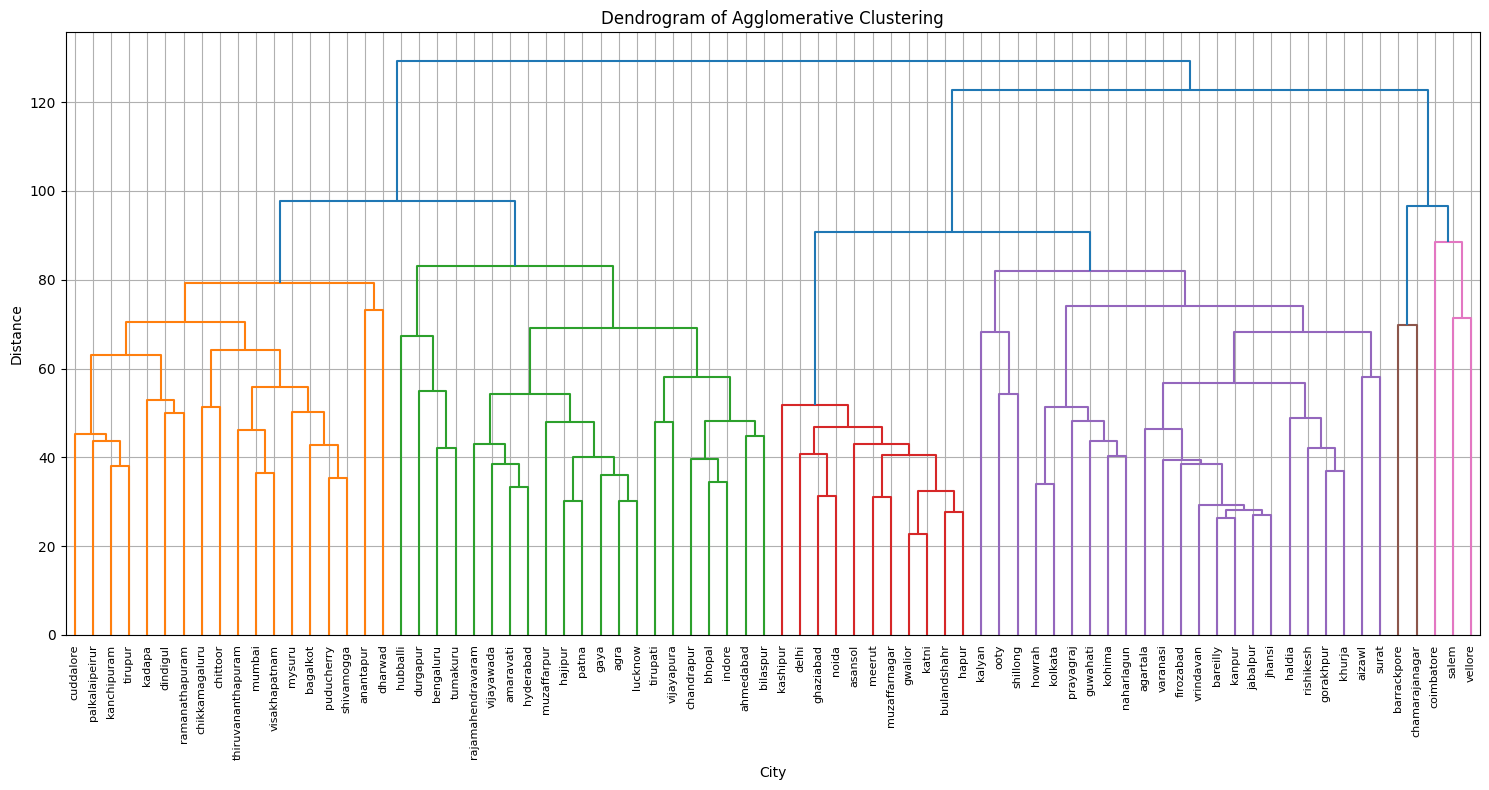

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import json
from scipy.spatial.distance import mahalanobis

file_path = '/content/drive/MyDrive/merged_aggregated_pollutant_statistics_windyweeks_finalstats.csv'
data = pd.read_csv(file_path)

# Drop unwanted columns, including any "Unnamed" columns
columns_to_drop = [col for col in data.columns if "Unnamed" in col]
filtered_data = data.drop(columns=columns_to_drop, errors='ignore')

# Filter out the row corresponding to "Hosur"
filtered_data = filtered_data[filtered_data['city'] != 'hosur']

# Reset index after filtering
filtered_data.reset_index(drop=True, inplace=True)

# Separate numeric and non-numeric columns
numeric_data = filtered_data.select_dtypes(include=['float64', 'int64'])
non_numeric_data = filtered_data.select_dtypes(exclude=['float64', 'int64'])

# Impute missing values with mean for numeric columns
imputer = SimpleImputer(strategy='mean')
imputed_numeric_data = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_non_numeric_data = pd.DataFrame(encoder.fit_transform(non_numeric_data), columns=encoder.get_feature_names_out(non_numeric_data.columns))

# Combine the numeric and encoded non-numeric data
processed_data = pd.concat([imputed_numeric_data, encoded_non_numeric_data], axis=1)

# Scale the combined data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

# Perform Agglomerative Clustering
nclusters = 5
hierarchical_cluster = AgglomerativeClustering(n_clusters=nclusters, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(scaled_data)

filtered_data['Cluster'] = labels

# Compute covariance matrix and its inverse
cov_matrix = np.cov(scaled_data, rowvar=False)
cov_inv = np.linalg.pinv(cov_matrix)

# Calculate centroids of each cluster
centroids = []
for cluster in range(nclusters):
    cluster_data = scaled_data[labels == cluster]
    centroid = np.mean(cluster_data, axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

# Create dictionary to store city names, centroid, and Mahalanobis distances in each cluster
windy_cluster = {}

if 'city' in filtered_data.columns:
    for cluster in range(nclusters):
        cities_in_cluster = filtered_data[filtered_data['Cluster'] == cluster]['city'].dropna().unique()
        distances_to_centroid = []
        for city_name in cities_in_cluster:
            city_index = filtered_data[filtered_data['city'] == city_name].index[0]  # Get the correct index from filtered_data
            city_data = scaled_data[city_index]  # Access the correct row in scaled_data
            centroid = centroids[cluster]
            distance = mahalanobis(city_data, centroid, cov_inv)
            distances_to_centroid.append(distance)

        windy_cluster[cluster] = {
            'Cities': list(cities_in_cluster),
            'Centroid': centroids[cluster].tolist(),
            'Distances_to_Centroid': distances_to_centroid
        }

print("Dictionary of cities, centroids, and Mahalanobis distances in each cluster:")
for cluster, cluster_info in windy_cluster.items():
    print(f"\nCluster {cluster}:")
    print(f"Cities: {', '.join(cluster_info['Cities'])}")
    print(f"Centroid: {cluster_info['Centroid']}")
    print(f"Distances to Centroid: {cluster_info['Distances_to_Centroid']}")

json_output_path = '/content/drive/MyDrive/clusters_city_centroids_distances_windy.json'
with open(json_output_path, 'w') as json_file:
    json.dump(windy_cluster, json_file, indent=4)

print(f'Dictionary saved as JSON file to {json_output_path}')

output_file_path = '/content/drive/MyDrive/agglomerative_clustered_data_windy_with_centroid_distance.csv'
filtered_data.to_csv(output_file_path, index=False)

print(f'Clustered data saved to {output_file_path}')

linkage_matrix = linkage(scaled_data, method='ward')
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=filtered_data['city'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Agglomerative Clustering')
plt.xlabel('City')
plt.ylabel('Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

# Function to extract city and year from filename
def extract_city_from_filename(filename, city_list):
    temp = filename.split('_')

    try:
        year = int(temp[3])
    except ValueError:
        print(f"Error: Year not found in filename: {filename}")
        return None, None

    city = temp[-3].strip().lower()

    # Special city handling (keeping your handling intact)
    special_city_mapping = {
        'kalaburgi': 'kalaburagi',
        'chamarajanagara': 'chamarajanagar',
        'chikkamagaluru': 'chikkamagaluru',
        'aizawl': 'aizawl',
        'imphal': 'imphal',
        'jaipur': 'jaipur',
        'chennai': 'chennai',
        'palkalaiperur': 'palkalaiperur'
    }

    for key, value in special_city_mapping.items():
        if key in city:
            print(f"Special handling for city: {value} in file {filename}")
            city = value
    if filename == 'Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv':
        city = 'palkalaipeirur'
    # Check if city is in the city list; otherwise, try to extract an alternate city name
    if city not in city_list:
        print(f"City '{city}' not found in city_list. Trying alternate city extraction...")
        city = temp[-4].strip().lower()

    if city not in city_list:
        print(f"City '{city}' still not found in city_list. Skipping file: {filename}")
        return None, None

    return city, year

# Function to apply Min-Max Scaling to pollutants
def apply_min_max_scaling(df, pollutants):
    scaler = MinMaxScaler()
    df[pollutants] = scaler.fit_transform(df[pollutants])
    return df

# Function to categorize time of day
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Function to get rainyweeks for a specific city from the weather_week_data.csv
def get_rainy_weeks_for_city(city_name, weather_week_data):
    rainy_weeks = weather_week_data['rainy_weeks'].dropna().apply(lambda x: [int(week) for week in x.split(',')])
    return rainy_weeks

# Function to process files for each city
def process_files(data_directory, city_files, city, year_list):
    all_data = []

    # Process each file for the given city
    for file in city_files:
        file_path = os.path.join(data_directory, file)
        print(f"Processing file: {file}")  # Print the file being processed

        # Read the file
        df = pd.read_csv(file_path)

        # Define columns to retain
        df = df[columns_to_retain]
        print(f"Before dropping NaN rows, remaining data in file: {file}")
        print(df.isna().sum())  # Print the count of NaN values per column after drop
        print(df.head())  # Print first few rows to check the data
        df=df.dropna()
        print(f"After dropping NaN rows, remaining data in file: {file}")
        print(df.isna().sum())  # Print the count of NaN values per column after drop
        print(df.head())  # Print first few rows to check the data

        # Add necessary datetime columns and time-based features (adjust this section as needed)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
       #df.dropna(subset=['Timestamp'], inplace=True)
        df['Year'] = df['Timestamp'].dt.year
        df['Month'] = df['Timestamp'].dt.month
        df['Week_Number'] = df['Timestamp'].dt.isocalendar().week
        df['Day_of_Week'] = df['Timestamp'].dt.dayofweek
        df['Hour'] = df['Timestamp'].dt.hour
        df['Time_of_Day'] = df['Hour'].apply(categorize_time_of_day)

        # Filter the data for valid years
        df = df[df['Year'].isin(year_list)]

        # Add the city name to the dataframe
        df['City'] = city

        # Append the current city's data
        all_data.append(df)

    # Combine data from all files for the current city
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

# Function to aggregate statistics for rainyweeks combined
def aggregate_rainy_week_stats(df):
    result_dict = {}
    pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']

    # Filter for rainyweeks only
    rainy_df = df[df['Rainy_Week'] == True]

    if not rainy_df.empty:
       result_dict['City'] = city
       for pollutant in pollutants:
            # Overall statistics for rainyweeks
            result_dict[f'{pollutant.split()[0].lower()}_rainy_mean'] = rainy_df[pollutant].mean()
            result_dict[f'{pollutant.split()[0].lower()}_rainy_std'] = rainy_df[pollutant].std()
            result_dict[f'{pollutant.split()[0].lower()}_rainy_min'] = rainy_df[pollutant].min()
            result_dict[f'{pollutant.split()[0].lower()}_rainy_max'] = rainy_df[pollutant].max()
            result_dict[f'{pollutant.split()[0].lower()}_rainy_50q'] = rainy_df[pollutant].quantile(0.5)
            result_dict[f'{pollutant.split()[0].lower()}_rainy_75q'] = rainy_df[pollutant].quantile(0.75)
            result_dict[f'{pollutant.split()[0].lower()}_rainy_25q'] = rainy_df[pollutant].quantile(0.25)

            # Time-of-day statistics (morning, afternoon, evening, night) for rainyweeks
            for time_of_day in ['Morning', 'Afternoon', 'Evening', 'Night']:
                time_based_df = rainy_df[rainy_df['Time_of_Day'] == time_of_day]
                if not time_based_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_rainy_mean'] = time_based_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_rainy_std'] = time_based_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_rainy_min'] = time_based_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_rainy_max'] = time_based_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_rainy_50q'] = time_based_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_rainy_75q'] = time_based_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_rainy_25q'] = time_based_df[pollutant].quantile(0.25)

            # Day-of-week statistics for rainyweeks
            for day_of_week in range(7):  # 0=Monday, 6=Sunday
                day_of_week_df = rainy_df[rainy_df['Day_of_Week'] == day_of_week]
                if not day_of_week_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_rainy_mean'] = day_of_week_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_rainy_std'] = day_of_week_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_rainy_min'] = day_of_week_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_rainy_max'] = day_of_week_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_rainy_50q'] = day_of_week_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_rainy_75q'] = day_of_week_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_rainy_25q'] = day_of_week_df[pollutant].quantile(0.25)

            # Month statistics for rainyweeks
            for month in range(1, 13):  # 1=January, 12=December
                month_df = rainy_df[rainy_df['Month'] == month]
                if not month_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_rainy_mean'] = month_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_rainy_std'] = month_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_rainy_min'] = month_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_rainy_max'] = month_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_rainy_50q'] = month_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_rainy_75q'] = month_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_rainy_25q'] = month_df[pollutant].quantile(0.25)

    return result_dict

# Now, using the `combined_df` for further processing
all_stats = []
city_files_dict = {}

# Read lookup and weather week data files
lookup_file = "/content/drive/MyDrive/Copy of parameters_metadata.csv"
final_stat_marker_file = "/content/drive/MyDrive/Final_stat_CityWise_Marker - Updated.csv"
weather_week_data_file = "/content/drive/MyDrive/weather_week_numbers.csv"

# Read lookup and final statistics files
lookup_df = pd.read_csv(lookup_file)
final_stat_marker_df = pd.read_csv(final_stat_marker_file)

# Filter for flagged=False
lookup_df = lookup_df[lookup_df['flagged'] == False]

# Get the list of cities
city_list = final_stat_marker_df['City'].unique().tolist()
city_list = [city.lower() for city in city_list]

# Read the weather week data to get rainyweeks
weather_week_data = pd.read_csv(weather_week_data_file)

# List of valid years
year_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Iterate over each file in the directory and process city-based data
all_files = os.listdir("/content/drive/MyDrive/Master Dataset")
city_files_dict = {}

for file in all_files:
    if file in lookup_df['filename'].values:
        city, year = extract_city_from_filename(file, city_list)
        if city and year in year_list:
            if city not in city_files_dict:
                city_files_dict[city] = []
            city_files_dict[city].append(file)

# Loop through the cities and process the data for each city
for city, city_files in city_files_dict.items():
    print(f"Processing data for city: {city}")

    # Get the combined data for this city
    combined_df = process_files("/content/drive/MyDrive/Master Dataset", city_files, city, year_list)

    # Extract rainydata based on rainyweeks for the current city
    rainy_weeks = get_rainy_weeks_for_city(city, weather_week_data)

    # Mark the rows for rainyweeks
    combined_df['Rainy_Week'] = combined_df['Week_Number'].apply(lambda week: week in rainy_weeks)

    # Filter out data for rainyweeks only
    rainy_df = combined_df[combined_df['Rainy_Week'] == True]

    if not rainy_df.empty:
        # Optionally apply Min-Max scaling to pollutants if needed
        pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']
        rainy_df = apply_min_max_scaling(rainy_df, pollutants)

        # Aggregate statistics for rainyweeks
        rainy_stats = aggregate_rainy_week_stats(rainy_df)

        # Append city-wise rainydata to the all_stats list
        all_stats.append(rainy_stats)

# Combine all rainydata from all cities into one DataFrame
if all_stats:
    combined_rainy_df = pd.DataFrame(all_stats)
    print(f"Combined rainydata for all cities: {combined_rainy_df.shape}")

    # Perform further operations with `combined_rainy_df` if needed
    # Example: Save the combined rainydata
    rainy_data_file_path = "/content/drive/MyDrive/all_cities_rainy_week_data.csv"
    combined_rainy_df.to_csv(rainy_data_file_path, index=False)
    print(f"Saved all rainyweek data for all cities to: {rainy_data_file_path}")
else:
    print("No rainydata found for any city.")





Streaming output truncated to the last 5000 lines.
       RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
17433    52.0       1.9     209.0          0.0      702.0  
17435    53.0       2.1     198.0          0.0      702.0  
17436    54.0       2.0     213.0          0.0      702.0  
17437    54.0       2.2     194.0          0.0      702.0  
17438    54.0       1.7     214.0          0.0      701.0  
Processing file: Raw_data_15Min_2023_site_5678_RVCE-Mailasandra_Bengaluru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5678_RVCE-Mailasandra_Bengaluru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10393
PM10 (µg/m³)      8730
CO (mg/m³)        8569
AT (°C)           4586
RH (%)            4532
WS (m/s)          4582
WD (deg)          4581
TOT-RF (mm)          0
BP (mmHg)         4571
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          70.44        120.93      

<ipython-input-7-57b9f9b15436>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')


Streaming output truncated to the last 5000 lines.

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   93.28      0.61    251.38          0.0     755.05  
1   93.49      0.73    249.44          0.0     754.95  
2   93.58      0.70    231.14          0.0     754.88  
3   93.50      0.77    244.70          0.0     754.82  
4   93.70      0.89    192.46          0.0     754.80  
After dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5461_Jhunsi_Prayagraj_UPPCB_15Min.csv
Timestamp        0
PM2.5 (µg/m³)    0
PM10 (µg/m³)     0
CO (mg/m³)       0
AT (°C)          0
RH (%)           0
WS (m/s)         0
WD (deg)         0
TOT-RF (mm)      0
BP (mmHg)        0
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          93.76        204.19        1.97    13.17   
1  2023-01-01 00:15:00          93.25        201.85        1.95    13.20   
2  2023-01-01 00:30:00          93.25        201.85        1.92    13

In [ ]:
import pandas as pd

city_station_summary = pd.read_csv('/content/drive/MyDrive/city_station_summary_scaled.csv')
final_aggregated_stats = pd.read_csv('/content/drive/MyDrive/all_cities_rainy_week_data.csv')

if 'City' in city_station_summary.columns:
    city_station_summary.rename(columns={'City': 'city'}, inplace=True)

if 'City' in final_aggregated_stats.columns:
    final_aggregated_stats.rename(columns={'City': 'city'}, inplace=True)

# Perform the merge based on the 'city' column
merged_df = pd.merge(city_station_summary, final_aggregated_stats, on='city', how='inner')

merged_df.to_csv('/content/drive/MyDrive/merged_city_station_summary_and_aggregated_stats_rainyweeks.csv', index=False)

# Display the first few rows of the merged DataFrame for inspection
print("\nMerged DataFrame:")
print(merged_df.head())





Merged DataFrame:
        city  Unnamed: 0_mean  human_made_1.5_km_radius_mean  \
0   agartala         0.335260                       0.882595   
1       agra         0.650289                       0.556818   
2  ahmedabad         0.002890                       0.652022   
3     aizawl         0.872832                       0.679756   
4  amaravati         0.254335                       0.072338   

   human_made_1_km_radius_mean  human_made_0.5_km_radius_mean  \
0                     0.822986                       0.847860   
1                     0.539949                       0.518302   
2                     0.653370                       0.674846   
3                     0.766794                       0.751033   
4                     0.131962                       0.047055   

   natural_land_1.5_km_radius_mean  natural_land_1_km_radius_mean  \
0                         0.000000                       0.000000   
1                         0.270414                       0.279409  

In [ ]:
import pandas as pd

# Function to merge final_stat_marker_df with aggregated stats based on the City without duplicating the City column
def merge_final_stat_with_aggregated_stats(aggregated_stats_df, final_stat_marker_df):

    # Normalize the column names to remove any leading/trailing spaces and convert to lowercase
    aggregated_stats_df.columns = aggregated_stats_df.columns.str.strip().str.lower()
    final_stat_marker_df.columns = final_stat_marker_df.columns.str.strip().str.lower()

    # Print column names to check for 'city' column
    print("aggregated_stats_df columns:", aggregated_stats_df.columns)
    print("final_stat_marker_df columns:", final_stat_marker_df.columns)

    # Check if 'city' column exists in both DataFrames
    if 'city' not in aggregated_stats_df.columns:
        raise KeyError("'city' column missing in aggregated_stats_df")
    if 'city' not in final_stat_marker_df.columns:
        raise KeyError("'city' column missing in final_stat_marker_df")

    # Strip whitespace and convert 'City' to lowercase (ensure consistency)
    aggregated_stats_df['city'] = aggregated_stats_df['city'].str.strip().str.lower()
    final_stat_marker_df['city'] = final_stat_marker_df['city'].str.strip().str.lower()

    # Ensure 'City' column is of string type
    aggregated_stats_df['city'] = aggregated_stats_df['city'].astype(str)
    final_stat_marker_df['city'] = final_stat_marker_df['city'].astype(str)

    # Select only the specific columns you need from the final_stat_marker_df
    final_stat_marker_df = final_stat_marker_df[['city', 'coastal city', 'critically polluted area(cpa)',
                                                 'industrial area(ia)', 'million plus cities',
                                                 'non-attainment cities']]

    # Merge DataFrames on 'city'
    merged_df = pd.merge(aggregated_stats_df, final_stat_marker_df, on='city', how='left')

    # Check for duplicate columns like 'city_x' and 'city_y', and drop them
    if 'city_x' in merged_df.columns:
        print("Found duplicate 'city_x' column, dropping it...")
        merged_df.drop(columns=['city_x'], inplace=True)
    if 'city_y' in merged_df.columns:
        print("Found duplicate 'city_y' column, dropping it...")
        merged_df.drop(columns=['city_y'], inplace=True)

    return merged_df

# Read the final_stat_marker_df (which contains the additional columns for each city)
final_stat_marker_df = pd.read_csv('/content/drive/MyDrive/Final_stat_CityWise_Marker - Updated.csv')

# Read the aggregated_stats DataFrame (the file generated earlier)
aggregated_stats_df = pd.read_csv('/content/drive/MyDrive/merged_city_station_summary_and_aggregated_stats_rainyweeks.csv')

# Merge the two DataFrames
merged_stats = merge_final_stat_with_aggregated_stats(aggregated_stats_df, final_stat_marker_df)

if merged_stats is not None:
    print(f"Merged DataFrame shape: {merged_stats.shape}")

    # Save the merged DataFrame to a new CSV file
    output_merged_file = '/content/drive/MyDrive/merged_aggregated_pollutant_statistics_rainyweeks_finalstats.csv'
    merged_stats.to_csv(output_merged_file, index=False)
    print(f"Merged file saved to {output_merged_file}")
else:
    print("Merge failed. Please check the error messages above.")






aggregated_stats_df columns: Index(['city', 'unnamed: 0_mean', 'human_made_1.5_km_radius_mean',
       'human_made_1_km_radius_mean', 'human_made_0.5_km_radius_mean',
       'natural_land_1.5_km_radius_mean', 'natural_land_1_km_radius_mean',
       'natural_land_0.5_km_radius_mean', 'high_way_1.5_km_radius_mean',
       'high_way_1_km_radius_mean',
       ...
       'bp_month_11_rainy_50q', 'bp_month_11_rainy_75q',
       'bp_month_11_rainy_25q', 'bp_month_12_rainy_mean',
       'bp_month_12_rainy_std', 'bp_month_12_rainy_min',
       'bp_month_12_rainy_max', 'bp_month_12_rainy_50q',
       'bp_month_12_rainy_75q', 'bp_month_12_rainy_25q'],
      dtype='object', length=1599)
final_stat_marker_df columns: Index(['unnamed: 0.1', 'unnamed: 0', 'pm2.5 (µg/m³) count',
       'pm10 (µg/m³) count', 'co (mg/m³) count', 'at (°c) count',
       'rh (%) count', 'ws (m/s) count', 'wd (deg) count', 'tot-rf (mm) count',
       'bp (mmhg) count', 'pm2.5 (µg/m³) mean', 'pm10 (µg/m³) mean',
       'co 

Dictionary of cities, centroids, and Mahalanobis distances in each cluster:

Cluster 0:
Cities: agartala, aizawl, asansol, bareilly, bengaluru, bulandshahr, delhi, durgapur, firozabad, ghaziabad, gorakhpur, guwahati, gwalior, haldia, hapur, howrah, hubballi, jabalpur, jhansi, kalyan, kanpur, kashipur, katni, khurja, kohima, kolkata, meerut, muzaffarnagar, naharlagun, noida, ooty, prayagraj, rishikesh, shillong, surat, tumakuru, varanasi, vrindavan
Centroid: [0.15726296028327713, 0.2402753724895245, 0.3008970968738792, 0.30238384597052964, -0.16746618918234135, -0.24432339426081848, -0.3128228282490145, -0.1661617765532065, -0.16180525674861532, -0.07504935741508546, -0.01891058798512197, -0.033330419375758, 0.005264085886959264, 0.026032376424185814, 0.11163368247009528, 0.1264020851204968, -0.09765317209952923, -0.09462654741891538, 0.038630436247690796, 0.20527724952665394, 0.18985962874211063, 0.13495507708576518, 0.08882283298436625, 0.07610068920043164, -0.040262379256849425, -0.1

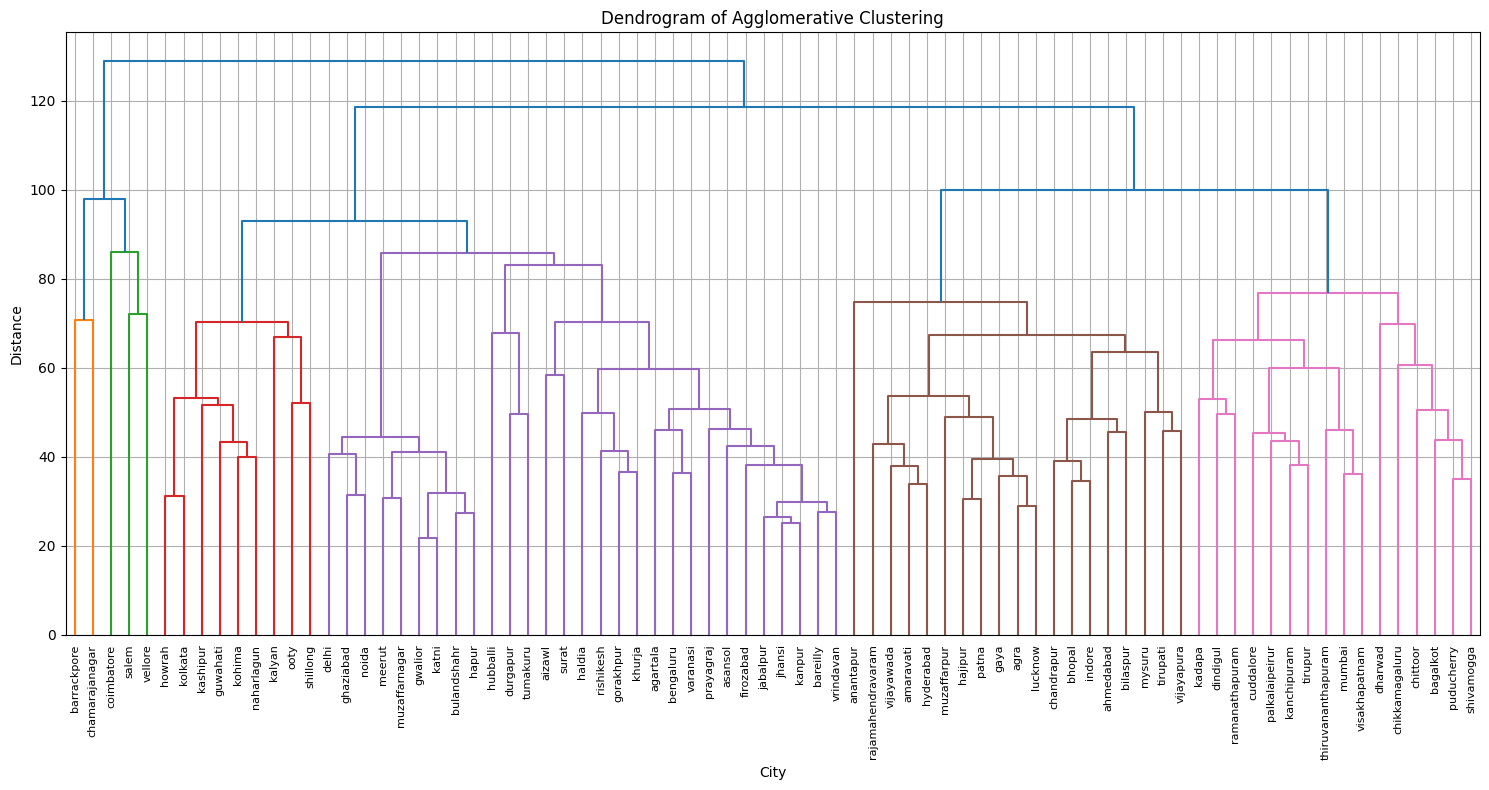

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import json
from scipy.spatial.distance import mahalanobis

file_path = '/content/drive/MyDrive/merged_aggregated_pollutant_statistics_rainyweeks_finalstats.csv'
data = pd.read_csv(file_path)

# Drop unwanted columns, including any "Unnamed" columns
columns_to_drop = [col for col in data.columns if "Unnamed" in col]
filtered_data = data.drop(columns=columns_to_drop, errors='ignore')

# Filter out the row corresponding to "Hosur" (or any city you wish to exclude)
filtered_data = filtered_data[filtered_data['city'] != 'hosur']

# Reset index after filtering
filtered_data.reset_index(drop=True, inplace=True)

# Separate numeric and non-numeric columns
numeric_data = filtered_data.select_dtypes(include=['float64', 'int64'])
non_numeric_data = filtered_data.select_dtypes(exclude=['float64', 'int64'])

# Impute missing values with mean for numeric columns
imputer = SimpleImputer(strategy='mean')
imputed_numeric_data = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_non_numeric_data = pd.DataFrame(encoder.fit_transform(non_numeric_data), columns=encoder.get_feature_names_out(non_numeric_data.columns))

# Combine the numeric and encoded non-numeric data
processed_data = pd.concat([imputed_numeric_data, encoded_non_numeric_data], axis=1)

# Scale the combined data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

# Perform Agglomerative Clustering
nclusters = 5
hierarchical_cluster = AgglomerativeClustering(n_clusters=nclusters, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(scaled_data)

filtered_data['Cluster'] = labels

# Compute covariance matrix and its inverse
cov_matrix = np.cov(scaled_data, rowvar=False)
cov_inv = np.linalg.pinv(cov_matrix)

# Calculate centroids of each cluster
centroids = []
for cluster in range(nclusters):
    cluster_data = scaled_data[labels == cluster]
    centroid = np.mean(cluster_data, axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

# Create dictionary to store city names, centroid, and Mahalanobis distances in each cluster
rainy_cluster = {}

if 'city' in filtered_data.columns:
    for cluster in range(nclusters):
        cities_in_cluster = filtered_data[filtered_data['Cluster'] == cluster]['city'].dropna().unique()
        distances_to_centroid = []
        for city_name in cities_in_cluster:
            city_index = filtered_data[filtered_data['city'] == city_name].index[0]  # Get the correct index from filtered_data
            city_data = scaled_data[city_index]  # Access the correct row in scaled_data
            centroid = centroids[cluster]
            distance = mahalanobis(city_data, centroid, cov_inv)
            distances_to_centroid.append(distance)

        rainy_cluster[cluster] = {
            'Cities': list(cities_in_cluster),
            'Centroid': centroids[cluster].tolist(),
            'Distances_to_Centroid': distances_to_centroid
        }

print("Dictionary of cities, centroids, and Mahalanobis distances in each cluster:")
for cluster, cluster_info in rainy_cluster.items():
    print(f"\nCluster {cluster}:")
    print(f"Cities: {', '.join(cluster_info['Cities'])}")
    print(f"Centroid: {cluster_info['Centroid']}")
    print(f"Distances to Centroid: {cluster_info['Distances_to_Centroid']}")

json_output_path = '/content/drive/MyDrive/clusters_city_centroids_distances_rainy.json'
with open(json_output_path, 'w') as json_file:
    json.dump(rainy_cluster, json_file, indent=4)

print(f'Dictionary saved as JSON file to {json_output_path}')

output_file_path = '/content/drive/MyDrive/agglomerative_clustered_data_rainy_with_centroid_distance.csv'
filtered_data.to_csv(output_file_path, index=False)

print(f'Clustered data saved to {output_file_path}')

linkage_matrix = linkage(scaled_data, method='ward')
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=filtered_data['city'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Agglomerative Clustering')
plt.xlabel('City')
plt.ylabel('Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

# Function to extract city and year from filename
def extract_city_from_filename(filename, city_list):
    temp = filename.split('_')

    try:
        year = int(temp[3])
    except ValueError:
        print(f"Error: Year not found in filename: {filename}")
        return None, None

    city = temp[-3].strip().lower()

    # Special city handling (keeping your handling intact)
    special_city_mapping = {
        'kalaburgi': 'kalaburagi',
        'chamarajanagara': 'chamarajanagar',
        'chikkamagaluru': 'chikkamagaluru',
        'aizawl': 'aizawl',
        'imphal': 'imphal',
        'jaipur': 'jaipur',
        'chennai': 'chennai',
        'palkalaiperur': 'palkalaiperur'
    }


    for key, value in special_city_mapping.items():
        if key in city:
            print(f"Special handling for city: {value} in file {filename}")
            city = value
    if filename == 'Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv':
        city = 'palkalaipeirur'
    # Check if city is in the city list; otherwise, try to extract an alternate city name
    if city not in city_list:
        print(f"City '{city}' not found in city_list. Trying alternate city extraction...")
        city = temp[-4].strip().lower()

    if city not in city_list:
        print(f"City '{city}' still not found in city_list. Skipping file: {filename}")
        return None, None

    return city, year

# Function to apply Min-Max Scaling to pollutants
def apply_min_max_scaling(df, pollutants):
    scaler = MinMaxScaler()
    df[pollutants] = scaler.fit_transform(df[pollutants])
    return df

# Function to categorize time of day
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Function to get cold weeks for a specific city from the weather_week_data.csv
def get_cold_weeks_for_city(city_name, weather_week_data):
    cold_weeks = weather_week_data['cold_weeks'].dropna().apply(lambda x: [int(week) for week in x.split(',')])
    return cold_weeks

# Function to process files for each city
def process_files(data_directory, city_files, city, year_list):
    all_data = []

    # Process each file for the given city
    for file in city_files:
        file_path = os.path.join(data_directory, file)
        print(f"Processing file: {file}")  # Print the file being processed

        # Read the file
        df = pd.read_csv(file_path)

        # Define columns to retain
        df = df[columns_to_retain]
        print(f"Before dropping NaN rows, remaining data in file: {file}")
        print(df.isna().sum())  # Print the count of NaN values per column after drop
        print(df.head())  # Print first few rows to check the data
        df=df.dropna()
        print(f"After dropping NaN rows, remaining data in file: {file}")
        print(df.isna().sum())  # Print the count of NaN values per column after drop
        print(df.head())  # Print first few rows to check the data

        # Add necessary datetime columns and time-based features (adjust this section as needed)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
       #df.dropna(subset=['Timestamp'], inplace=True)
        df['Year'] = df['Timestamp'].dt.year
        df['Month'] = df['Timestamp'].dt.month
        df['Week_Number'] = df['Timestamp'].dt.isocalendar().week
        df['Day_of_Week'] = df['Timestamp'].dt.dayofweek
        df['Hour'] = df['Timestamp'].dt.hour
        df['Time_of_Day'] = df['Hour'].apply(categorize_time_of_day)

        # Filter the data for valid years
        df = df[df['Year'].isin(year_list)]

        # Add the city name to the dataframe
        df['City'] = city

        # Append the current city's data
        all_data.append(df)

    # Combine data from all files for the current city
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

# Function to aggregate statistics for cold weeks combined
def aggregate_cold_week_stats(df):
    result_dict = {}
    pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']

    # Filter for cold weeks only
    cold_df = df[df['Cold_Week'] == True]

    if not cold_df.empty:
       result_dict['City'] = city
       for pollutant in pollutants:
            # Overall statistics for cold weeks
            result_dict[f'{pollutant.split()[0].lower()}_cold_mean'] = cold_df[pollutant].mean()
            result_dict[f'{pollutant.split()[0].lower()}_cold_std'] = cold_df[pollutant].std()
            result_dict[f'{pollutant.split()[0].lower()}_cold_min'] = cold_df[pollutant].min()
            result_dict[f'{pollutant.split()[0].lower()}_cold_max'] = cold_df[pollutant].max()
            result_dict[f'{pollutant.split()[0].lower()}_cold_50q'] = cold_df[pollutant].quantile(0.5)
            result_dict[f'{pollutant.split()[0].lower()}_cold_75q'] = cold_df[pollutant].quantile(0.75)
            result_dict[f'{pollutant.split()[0].lower()}_cold_25q'] = cold_df[pollutant].quantile(0.25)

            # Time-of-day statistics (morning, afternoon, evening, night) for cold weeks
            for time_of_day in ['Morning', 'Afternoon', 'Evening', 'Night']:
                time_based_df = cold_df[cold_df['Time_of_Day'] == time_of_day]
                if not time_based_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_cold_mean'] = time_based_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_cold_std'] = time_based_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_cold_min'] = time_based_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_cold_max'] = time_based_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_cold_50q'] = time_based_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_cold_75q'] = time_based_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_cold_25q'] = time_based_df[pollutant].quantile(0.25)

            # Day-of-week statistics for cold weeks
            for day_of_week in range(7):  # 0=Monday, 6=Sunday
                day_of_week_df = cold_df[cold_df['Day_of_Week'] == day_of_week]
                if not day_of_week_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_cold_mean'] = day_of_week_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_cold_std'] = day_of_week_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_cold_min'] = day_of_week_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_cold_max'] = day_of_week_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_cold_50q'] = day_of_week_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_cold_75q'] = day_of_week_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_cold_25q'] = day_of_week_df[pollutant].quantile(0.25)

            # Month statistics for cold weeks
            for month in range(1, 13):  # 1=January, 12=December
                month_df = cold_df[cold_df['Month'] == month]
                if not month_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_cold_mean'] = month_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_cold_std'] = month_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_cold_min'] = month_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_cold_max'] = month_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_cold_50q'] = month_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_cold_75q'] = month_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_cold_25q'] = month_df[pollutant].quantile(0.25)

    return result_dict

# Now, using the `combined_df` for further processing
all_stats = []
city_files_dict = {}

# Read lookup and weather week data files
lookup_file = "/content/drive/MyDrive/Copy of parameters_metadata.csv"
final_stat_marker_file = "/content/drive/MyDrive/Final_stat_CityWise_Marker - Updated.csv"
weather_week_data_file = "/content/drive/MyDrive/weather_week_numbers.csv"

# Read lookup and final statistics files
lookup_df = pd.read_csv(lookup_file)
final_stat_marker_df = pd.read_csv(final_stat_marker_file)

# Filter for flagged=False
lookup_df = lookup_df[lookup_df['flagged'] == False]

# Get the list of cities
city_list = final_stat_marker_df['City'].unique().tolist()
city_list = [city.lower() for city in city_list]

# Read the weather week data to get cold weeks
weather_week_data = pd.read_csv(weather_week_data_file)

# List of valid years
year_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Iterate over each file in the directory and process city-based data
all_files = os.listdir("/content/drive/MyDrive/Master Dataset")
city_files_dict = {}

for file in all_files:
    if file in lookup_df['filename'].values:
        city, year = extract_city_from_filename(file, city_list)
        if city and year in year_list:
            if city not in city_files_dict:
                city_files_dict[city] = []
            city_files_dict[city].append(file)

# Loop through the cities and process the data for each city
for city, city_files in city_files_dict.items():
    print(f"Processing data for city: {city}")

    # Get the combined data for this city
    combined_df = process_files("/content/drive/MyDrive/Master Dataset", city_files, city, year_list)

    # Extract cold data based on cold weeks for the current city
    cold_weeks = get_cold_weeks_for_city(city, weather_week_data)

    # Mark the rows for cold weeks
    combined_df['Cold_Week'] = combined_df['Week_Number'].apply(lambda week: week in cold_weeks)

    # Filter out data for cold weeks only
    cold_df = combined_df[combined_df['Cold_Week'] == True]

    if not cold_df.empty:
        # Optionally apply Min-Max scaling to pollutants if needed
        pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']
        cold_df = apply_min_max_scaling(cold_df, pollutants)

        # Aggregate statistics for cold weeks
        cold_stats = aggregate_cold_week_stats(cold_df)

        # Append city-wise cold data to the all_stats list
        all_stats.append(cold_stats)

# Combine all cold data from all cities into one DataFrame
if all_stats:
    combined_cold_df = pd.DataFrame(all_stats)
    print(f"Combined cold data for all cities: {combined_cold_df.shape}")

    # Perform further operations with `combined_cold_df` if needed
    # Example: Save the combined cold data
    cold_data_file_path = "/content/drive/MyDrive/all_cities_cold_week_data.csv"
    combined_cold_df.to_csv(cold_data_file_path, index=False)
    print(f"Saved all cold week data for all cities to: {cold_data_file_path}")
else:
    print("No cold data found for any city.")





City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'meghalaya' not found in city_list. Trying alternate city extraction...
City 'meghalaya' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Try

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: surat
Processing file: Raw_data_15Min_2023_site_5664_Science_Center_Surat_SMC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5664_Science_Center_Surat_SMC_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     8969
PM10 (µg/m³)     10224
CO (mg/m³)        1330
AT (°C)           3313
RH (%)            3313
WS (m/s)          3313
WD (deg)          3313
TOT-RF (mm)          0
BP (mmHg)         3313
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          52.00         72.16        0.57    20.91   
1  2023-01-01 00:15:00          52.00         72.00        0.57    20.76   
2  2023-01-01 00:30:00          52.00         72.00        0.58    20.48   
3  2023-01-01 00:45:00          52.00         72.00        0.57    20.40   
4  2023-01-01 01:00:00          79.07        105.00        0.56    20.16   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   57.51      

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Streaming output truncated to the last 5000 lines.
3    93.5       0.1     247.0          0.0      991.8  
4    93.9       0.2     274.9          0.0      991.7  
Processing file: Raw_data_15Min_2020_site_1429_Nehru_Nagar_Delhi_DPCC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_1429_Nehru_Nagar_Delhi_DPCC_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1063
PM10 (µg/m³)     1021
CO (mg/m³)       2857
AT (°C)           907
RH (%)            866
WS (m/s)         1589
WD (deg)          989
TOT-RF (mm)         0
BP (mmHg)         905
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         8.8      6.2   
1  2020-01-01 00:15:00            NaN           NaN         8.7      6.1   
2  2020-01-01 00:30:00            NaN           NaN         7.8      6.0   
3  2020-01-01 00:45:00          972.0           NaN         7.6      5.9   
4  2020-01-01 01:00:00         

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bilaspur
Processing file: Raw_data_15Min_2023_site_5503_Mangala_Bilaspur_NTPC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5503_Mangala_Bilaspur_NTPC_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7452
PM10 (µg/m³)      8332
CO (mg/m³)       10703
AT (°C)           5245
RH (%)            5323
WS (m/s)          5602
WD (deg)          5607
TOT-RF (mm)          0
BP (mmHg)         5248
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          26.40         79.76         1.8    33.98   
1  2023-01-01 00:15:00          19.77         66.27         1.8    34.15   
2  2023-01-01 00:30:00          18.65         64.19         1.6    34.16   
3  2023-01-01 00:45:00          18.65         64.19         1.7    34.22   
4  2023-01-01 01:00:00          18.65         64.19         2.5    34.27   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   50.96      0.1

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: naharlagun
Processing file: Raw_data_15Min_2023_site_5446_Naharlagun_Naharlagun_APSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5446_Naharlagun_Naharlagun_APSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    16015
PM10 (µg/m³)     16756
CO (mg/m³)       12962
AT (°C)          21987
RH (%)           21987
WS (m/s)         21989
WD (deg)         21987
TOT-RF (mm)          0
BP (mmHg)        22008
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gaya
Processing file: Raw_data_15Min_2023_site_5338_SFTI_Kusdihra_Gaya_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5338_SFTI_Kusdihra_Gaya_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2912
PM10 (µg/m³)     2710
CO (mg/m³)       1267
AT (°C)          1705
RH (%)           1708
WS (m/s)         1758
WD (deg)         1720
TOT-RF (mm)         0
BP (mmHg)        1704
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         130.48        157.37        1.88    13.82   
1  2023-01-01 00:15:00         130.48        157.37        1.90    13.30   
2  2023-01-01 00:30:00         138.10        160.44        2.18    12.66   
3  2023-01-01 00:45:00         154.12        167.24        2.52    11.86   
4  2023-01-01 01:00:00         154.12        167.24        2.63    11.58   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.00      0.27    355

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hajipur
Processing file: Raw_data_15Min_2023_site_5337_Industrial_Area_Hajipur_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5337_Industrial_Area_Hajipur_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2882
PM10 (µg/m³)     2749
CO (mg/m³)       1493
AT (°C)          1879
RH (%)           1873
WS (m/s)         1984
WD (deg)         1873
TOT-RF (mm)         0
BP (mmHg)        1879
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          292.9         527.4        3.62    11.47   
1  2023-01-01 00:15:00          286.7         476.8        3.63    10.78   
2  2023-01-01 00:30:00          286.7         476.8        3.63    10.53   
3  2023-01-01 00:45:00          286.7         476.8        3.79    10.58   
4  2023-01-01 01:00:00          234.7         398.8        3.90    10.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.15    

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: muzaffarpur
Processing file: Raw_data_15Min_2023_site_5370_Buddha_Colony_Muzaffarpur_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5370_Buddha_Colony_Muzaffarpur_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4008
PM10 (µg/m³)     3933
CO (mg/m³)       1422
AT (°C)          4444
RH (%)           4435
WS (m/s)         2454
WD (deg)         2374
TOT-RF (mm)         0
BP (mmHg)        2335
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          597.2         652.0        1.85    14.35   
1  2023-01-01 00:15:00          597.2         652.0        1.79    14.15   
2  2023-01-01 00:30:00          485.0         540.0        1.79    13.93   
3  2023-01-01 00:45:00          475.6         529.0        1.78    13.86   
4  2023-01-01 01:00:00          475.6         529.0        1.81    13.84   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   8

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: patna
Processing file: Raw_data_15Min_2023_site_5262_Rajbansi_Nagar_Patna_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5262_Rajbansi_Nagar_Patna_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1656
PM10 (µg/m³)     1897
CO (mg/m³)        732
AT (°C)           819
RH (%)            820
WS (m/s)          844
WD (deg)          863
TOT-RF (mm)         0
BP (mmHg)         844
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          483.6         641.3        4.58    12.20   
1  2023-01-01 00:15:00          499.9         658.4        4.77    12.08   
2  2023-01-01 00:30:00          499.9         658.4        4.78    12.04   
3  2023-01-01 00:45:00          499.9         658.4        4.77    12.06   
4  2023-01-01 01:00:00          458.8         633.4        4.65    11.91   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.30      0.09  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: guwahati
Processing file: Raw_data_15Min_2023_site_5073_Railway_Colony_Guwahati_PCBA_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5073_Railway_Colony_Guwahati_PCBA_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     5949
PM10 (µg/m³)      5703
CO (mg/m³)        1803
AT (°C)          13952
RH (%)           13952
WS (m/s)         13952
WD (deg)         13952
TOT-RF (mm)          0
BP (mmHg)        14197
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         576.00        664.43         NaN    12.97   
1  2023-01-01 00:15:00         576.00        672.00        4.60    15.00   
2  2023-01-01 00:30:00         576.00        672.00        4.75    15.05   
3  2023-01-01 00:45:00         578.29        672.00        4.61    14.96   
4  2023-01-01 01:00:00            NaN           NaN        4.78    14.86   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: amaravati
Processing file: Raw_data_15Min_2023_site_1406_Secretariat_Amaravati_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1406_Secretariat_Amaravati_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5702
PM10 (µg/m³)     5101
CO (mg/m³)       5373
AT (°C)          4550
RH (%)           4769
WS (m/s)         4550
WD (deg)         4550
TOT-RF (mm)         0
BP (mmHg)        4550
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           43.0          79.0        0.64     22.2   
1  2023-01-01 00:15:00           43.0          79.0        0.62     22.2   
2  2023-01-01 00:30:00           43.0          79.0        0.62     22.2   
3  2023-01-01 00:45:00           41.0          79.0        0.64     22.1   
4  2023-01-01 01:00:00           41.0          79.0        0.62     22.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    96.0      

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: anantapur
Processing file: Raw_data_15Min_2023_site_5632_Gulzarpet_Anantapur_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5632_Gulzarpet_Anantapur_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4543
PM10 (µg/m³)     5130
CO (mg/m³)       5008
AT (°C)          3673
RH (%)           3689
WS (m/s)         7299
WD (deg)         3942
TOT-RF (mm)         0
BP (mmHg)        3804
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          16.90         44.50        0.74    23.49   
1  2023-01-01 00:15:00          17.16         44.06        0.89    23.18   
2  2023-01-01 00:30:00          18.18         42.18        1.00    22.89   
3  2023-01-01 00:45:00          18.18         42.18        1.09    22.67   
4  2023-01-01 01:00:00          18.18         42.18        1.54    22.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   63.18       NaN

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chittoor
Processing file: Raw_data_15Min_2022_site_5665_Gangineni_Cheruvu_Chittoor_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5665_Gangineni_Cheruvu_Chittoor_APPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    32734
PM10 (µg/m³)     32745
CO (mg/m³)       31521
AT (°C)          31343
RH (%)           31343
WS (m/s)         31343
WD (deg)         31344
TOT-RF (mm)          0
BP (mmHg)        33502
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kadapa
Processing file: Raw_data_15Min_2023_site_5693_Yerramukkapalli_Kadapa_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5693_Yerramukkapalli_Kadapa_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7702
PM10 (µg/m³)     7708
CO (mg/m³)       3482
AT (°C)          3368
RH (%)           3368
WS (m/s)         3407
WD (deg)         3417
TOT-RF (mm)         0
BP (mmHg)        4137
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN       

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: rajamahendravaram
Processing file: Raw_data_15Min_2023_site_1399_Anand_Kala_Kshetram_Rajamahendravaram_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1399_Anand_Kala_Kshetram_Rajamahendravaram_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3798
PM10 (µg/m³)     1384
CO (mg/m³)       5155
AT (°C)          1454
RH (%)           1149
WS (m/s)         1104
WD (deg)         1127
TOT-RF (mm)         0
BP (mmHg)        1104
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           34.0          64.0        0.69     29.9   
1  2023-01-01 00:15:00           34.0          64.0        0.77     29.5   
2  2023-01-01 00:30:00           34.0          64.0        0.72     29.3   
3  2023-01-01 00:45:00           47.0          83.0        0.65     29.8   
4  2023-01-01 01:00:00           47.0          83.0        0.66     29.6   

   RH (%)  WS (m/s)  WD (deg)  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tirupati
Processing file: Raw_data_15Min_2023_site_5666_Vaikuntapuram_Tirupati_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5666_Vaikuntapuram_Tirupati_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    8100
PM10 (µg/m³)     9194
CO (mg/m³)       2621
AT (°C)          7227
RH (%)           7226
WS (m/s)         2298
WD (deg)         2289
TOT-RF (mm)         0
BP (mmHg)        2301
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN     

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vijayawada
Processing file: Raw_data_15Min_2023_site_5685_Kanuru_Vijayawada_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5685_Kanuru_Vijayawada_APPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    12655
PM10 (µg/m³)     13410
CO (mg/m³)       12949
AT (°C)          10537
RH (%)           10559
WS (m/s)         10543
WD (deg)         10549
TOT-RF (mm)          0
BP (mmHg)        10538
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN   

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: visakhapatnam
Processing file: Raw_data_15Min_2023_site_260_GVM_Corporation_Visakhapatnam_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_260_GVM_Corporation_Visakhapatnam_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6717
PM10 (µg/m³)     6791
CO (mg/m³)       6620
AT (°C)          6029
RH (%)           6029
WS (m/s)         6027
WD (deg)         6033
TOT-RF (mm)         0
BP (mmHg)        5648
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           44.0          96.0        0.52     25.2   
1  2023-01-01 00:15:00           44.0          96.0        0.40     25.1   
2  2023-01-01 00:30:00           44.0          96.0        0.35     25.0   
3  2023-01-01 00:45:00           55.0         112.0        0.55     24.9   
4  2023-01-01 01:00:00           55.0         112.0        0.69     24.8   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: shillong
Processing file: Raw_data_15Min_2023_site_5593_JN_Stadium_Shillong_Meghalaya_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5593_JN_Stadium_Shillong_Meghalaya_PCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    23846
PM10 (µg/m³)     23266
CO (mg/m³)       22146
AT (°C)          23463
RH (%)           23463
WS (m/s)         23464
WD (deg)         23463
TOT-RF (mm)          0
BP (mmHg)        23463
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mm

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: agartala
Processing file: Raw_data_15Min_2022_site_5377_Kunjaban_Agartala_Tripura_SPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5377_Kunjaban_Agartala_Tripura_SPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     4298
PM10 (µg/m³)      3717
CO (mg/m³)        2299
AT (°C)          11594
RH (%)           12360
WS (m/s)         11624
WD (deg)         11594
TOT-RF (mm)          0
BP (mmHg)        21441
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN    10.60   
1  2022-01-01 00:15:00         118.00        181.00        1.05    10.36   
2  2022-01-01 00:30:00         118.00        181.00        1.10    10.64   
3  2022-01-01 00:45:00         118.00        181.00        1.09    15.62   
4  2022-01-01 01:00:00         123.82        205.18        1.09    12.50   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chandrapur
Processing file: Raw_data_15Min_2017_site_271_Chauhan_Colony_Chandrapur_MPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2017_site_271_Chauhan_Colony_Chandrapur_MPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    12287
PM10 (µg/m³)     10680
CO (mg/m³)        7802
AT (°C)          28626
RH (%)            9530
WS (m/s)          9528
WD (deg)         10825
TOT-RF (mm)          0
BP (mmHg)         9022
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2017-01-01 00:00:00           68.0         120.0        0.85      NaN   
1  2017-01-01 00:15:00           68.0         120.0        0.84      NaN   
2  2017-01-01 00:30:00           68.0         120.0        0.81      NaN   
3  2017-01-01 00:45:00          101.0         151.0        0.81      NaN   
4  2017-01-01 01:00:00          101.0         151.0        0.82      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kalyan
Processing file: Raw_data_15Min_2023_site_5118_Khadakpada_Kalyan_MPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5118_Khadakpada_Kalyan_MPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7006
PM10 (µg/m³)     9836
CO (mg/m³)       6440
AT (°C)          6626
RH (%)           6624
WS (m/s)         6625
WD (deg)         6625
TOT-RF (mm)         0
BP (mmHg)        6626
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           38.0         172.0        2.54    28.74   
1  2023-01-01 00:15:00           93.0         172.0        1.34    28.75   
2  2023-01-01 00:30:00           93.0         172.0        1.62    28.75   
3  2023-01-01 00:45:00           93.0         164.8        1.39    28.74   
4  2023-01-01 01:00:00           93.0         160.0        1.30    28.74   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   89.45      1.32    338.7

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: mumbai
Processing file: Raw_data_15Min_2020_site_5396_Deonar_Mumbai_IITM_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_5396_Deonar_Mumbai_IITM_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    30722
PM10 (µg/m³)     30724
CO (mg/m³)       30653
AT (°C)          30633
RH (%)           30634
WS (m/s)         33143
WD (deg)         30630
TOT-RF (mm)          0
BP (mmHg)        31768
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2020-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2020-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2020-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2020-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN       NaN       

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bhopal
Processing file: Raw_data_15Min_2023_site_5247_T_T_Nagar_Bhopal_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5247_T_T_Nagar_Bhopal_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1277
PM10 (µg/m³)     1212
CO (mg/m³)       3220
AT (°C)           938
RH (%)            938
WS (m/s)          938
WD (deg)          988
TOT-RF (mm)         0
BP (mmHg)         939
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           88.0         185.0        1.25     15.1   
1  2023-01-01 00:15:00           88.0         185.0        0.98     14.9   
2  2023-01-01 00:30:00           88.0         185.0        1.08     14.9   
3  2023-01-01 00:45:00           84.0         160.0        1.17     14.7   
4  2023-01-01 01:00:00           84.0         160.0        1.06     14.5   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    73.0       1.4     171.

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gwalior
Processing file: Raw_data_15Min_2023_site_5273_City_Center_Gwalior_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5273_City_Center_Gwalior_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2254
PM10 (µg/m³)     3932
CO (mg/m³)       5506
AT (°C)          1241
RH (%)           1241
WS (m/s)         1241
WD (deg)         1229
TOT-RF (mm)         0
BP (mmHg)        1241
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          334.0         432.0        1.72      7.8   
1  2023-01-01 00:15:00          334.0         432.0        1.49      7.9   
2  2023-01-01 00:30:00          334.0         432.0        1.35      7.8   
3  2023-01-01 00:45:00          256.0         355.0        1.50      7.8   
4  2023-01-01 01:00:00          256.0         355.0        1.58      7.8   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    95.0       0.3  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: indore
Processing file: Raw_data_15Min_2023_site_5248_Chhoti_Gwaltoli_Indore_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5248_Chhoti_Gwaltoli_Indore_MPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     1051
PM10 (µg/m³)      1081
CO (mg/m³)        3757
AT (°C)            848
RH (%)             849
WS (m/s)           849
WD (deg)           849
TOT-RF (mm)          0
BP (mmHg)        16036
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           35.0         149.0        0.74     16.2   
1  2023-01-01 00:15:00           35.0         149.0        0.65     15.9   
2  2023-01-01 00:30:00           35.0         149.0        1.04     16.0   
3  2023-01-01 00:45:00           37.0         176.0        1.24     16.0   
4  2023-01-01 01:00:00           37.0         176.0        1.15     16.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    6

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: jabalpur
Processing file: Raw_data_15Min_2023_site_5249_Marhatal_Jabalpur_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5249_Marhatal_Jabalpur_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1563
PM10 (µg/m³)     1545
CO (mg/m³)       4391
AT (°C)           811
RH (%)            811
WS (m/s)          811
WD (deg)          811
TOT-RF (mm)         0
BP (mmHg)         811
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          102.0         157.0        1.09     14.1   
1  2023-01-01 00:15:00          102.0         157.0        1.12     14.1   
2  2023-01-01 00:30:00          102.0         157.0         NaN     14.0   
3  2023-01-01 00:45:00           95.0         164.0         NaN     13.9   
4  2023-01-01 01:00:00           95.0         164.0         NaN     13.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    69.0       0.5     

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: katni
Processing file: Raw_data_15Min_2023_site_5250_Gole_Bazar_Katni_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5250_Gole_Bazar_Katni_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4940
PM10 (µg/m³)     8978
CO (mg/m³)       5170
AT (°C)          4188
RH (%)           4188
WS (m/s)         4188
WD (deg)         4189
TOT-RF (mm)         0
BP (mmHg)        4188
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          140.0         232.0        0.94     12.8   
1  2023-01-01 00:15:00          140.0         232.0         NaN     12.7   
2  2023-01-01 00:30:00          140.0         232.0        1.12     12.4   
3  2023-01-01 00:45:00          163.0         254.0        1.12     12.3   
4  2023-01-01 01:00:00          163.0         254.0        1.15     12.1   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    80.0       0.3     237.0

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: thiruvananthapuram
Processing file: Raw_data_15Min_2023_site_252_Plammoodu_Thiruvananthapuram_Kerala_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_252_Plammoodu_Thiruvananthapuram_Kerala_PCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6833
PM10 (µg/m³)     4991
CO (mg/m³)       2256
AT (°C)          2330
RH (%)           2329
WS (m/s)         2331
WD (deg)         2329
TOT-RF (mm)         0
BP (mmHg)        5953
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           52.0          81.0        0.98     23.2   
1  2023-01-01 00:15:00           52.0          81.0        0.98     23.2   
2  2023-01-01 00:30:00           52.0          81.0        0.98     23.1   
3  2023-01-01 00:45:00           66.0         100.0        0.97     23.0   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (m

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bagalkot
Processing file: Raw_data_15Min_2023_site_5264_Vidayagiri_Bagalkot_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5264_Vidayagiri_Bagalkot_KSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1797
PM10 (µg/m³)     2189
CO (mg/m³)       3275
AT (°C)          1516
RH (%)           2633
WS (m/s)         1525
WD (deg)         1494
TOT-RF (mm)         0
BP (mmHg)        2511
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           1.00           NaN        0.00    26.39   
1  2023-01-01 00:15:00          23.07         42.38        0.60    26.66   
2  2023-01-01 00:30:00          23.26         42.70        0.68    26.89   
3  2023-01-01 00:45:00          22.98         42.22        0.56    26.93   
4  2023-01-01 01:00:00          23.33         42.82        0.70    26.43   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    63.0      2.37 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bengaluru
Processing file: Raw_data_15Min_2022_site_1558_Silk_Board_Bengaluru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_1558_Silk_Board_Bengaluru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7963
PM10 (µg/m³)      8047
CO (mg/m³)       11296
AT (°C)           7076
RH (%)            7063
WS (m/s)          7061
WD (deg)          7063
TOT-RF (mm)          0
BP (mmHg)        23139
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN        0.17     18.5   
1  2022-01-01 00:15:00            NaN           NaN        0.22     18.5   
2  2022-01-01 00:30:00            NaN           NaN        0.16     18.5   
3  2022-01-01 00:45:00            NaN           NaN         NaN     18.4   
4  2022-01-01 01:00:00            NaN           NaN        0.23     18.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    88

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chamarajanagar
Processing file: Raw_data_15Min_2021_site_5124_Urban_Chamarajanagar_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2021_site_5124_Urban_Chamarajanagar_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     8303
PM10 (µg/m³)      8145
CO (mg/m³)        7428
AT (°C)          33053
RH (%)           33021
WS (m/s)         12898
WD (deg)         12051
TOT-RF (mm)          0
BP (mmHg)         8168
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2021-01-01 00:00:00          16.20           NaN        0.30      NaN   
1  2021-01-01 00:15:00          15.84         35.36        0.28      NaN   
2  2021-01-01 00:30:00          16.26         33.33        0.28      NaN   
3  2021-01-01 00:45:00          16.48         34.52        0.28      NaN   
4  2021-01-01 01:00:00          15.88         35.78        0.29      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: dharwad
Processing file: Raw_data_15Min_2023_site_5638_Kalabhavan_Dharwad_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5638_Kalabhavan_Dharwad_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10807
PM10 (µg/m³)     10100
CO (mg/m³)        6806
AT (°C)           6029
RH (%)            6116
WS (m/s)          7952
WD (deg)          7165
TOT-RF (mm)          0
BP (mmHg)         6039
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          47.76         84.22        0.93    23.75   
1  2023-01-01 00:15:00          47.76         84.22        1.06    23.67   
2  2023-01-01 00:30:00          47.76         84.22        0.99    23.56   
3  2023-01-01 00:45:00          46.13         76.20        0.85    23.56   
4  2023-01-01 01:00:00          45.51         73.11        0.93    23.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   11.52    

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hubballi
Processing file: Raw_data_15Min_2023_site_5680_Lingaraj_Nagar_Hubballi_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5680_Lingaraj_Nagar_Hubballi_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6594
PM10 (µg/m³)      7465
CO (mg/m³)        6205
AT (°C)           4545
RH (%)            4577
WS (m/s)         11155
WD (deg)         11109
TOT-RF (mm)          0
BP (mmHg)        12476
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          66.66        128.96        0.48    23.79   
1  2023-01-01 00:15:00          66.66        128.96        0.49    23.67   
2  2023-01-01 00:30:00          66.66        129.85        0.50    23.73   
3  2023-01-01 00:45:00          66.66        130.51        0.50    23.68   
4  2023-01-01 01:00:00          60.91        130.51        0.49    23.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kalaburagi
Processing file: Raw_data_15Min_2023_site_5679_Mahatma_Basaveswar_Colony_Kalaburgi_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5679_Mahatma_Basaveswar_Colony_Kalaburgi_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    13238
PM10 (µg/m³)     13013
CO (mg/m³)       12726
AT (°C)          12585
RH (%)           12504
WS (m/s)         12857
WD (deg)         12858
TOT-RF (mm)          0
BP (mmHg)        12421
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          65.70         86.04        0.98     21.5   
1  2023-01-01 00:15:00          65.70         86.04        0.99     21.5   
2  2023-01-01 00:30:00          60.79         81.13        1.07     21.5   
3  2023-01-01 00:45:00          59.48         79.82        1.07     21.5   
4  2023-01-01 01:00:00          59.48         79.82        1.05     21.5   

   RH (%)  WS (m/s)  WD (deg)  T

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: mysuru
Processing file: Raw_data_15Min_2021_site_5125_Hebbal_1st_Stage_Mysuru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2021_site_5125_Hebbal_1st_Stage_Mysuru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6353
PM10 (µg/m³)      6642
CO (mg/m³)        6418
AT (°C)          33765
RH (%)            6110
WS (m/s)          6167
WD (deg)          6606
TOT-RF (mm)          0
BP (mmHg)         6111
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2021-01-01 00:00:00          21.12         66.37        0.35      NaN   
1  2021-01-01 00:15:00          19.37         66.37        0.27      NaN   
2  2021-01-01 00:30:00          16.74         66.37        0.26      NaN   
3  2021-01-01 00:45:00          16.74         52.51        0.23      NaN   
4  2021-01-01 01:00:00          16.74         51.69        0.22      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: shivamogga
Processing file: Raw_data_15Min_2022_site_5266_Vinoba_Nagara_Shivamogga_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5266_Vinoba_Nagara_Shivamogga_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2520
PM10 (µg/m³)      2311
CO (mg/m³)       15555
AT (°C)           2126
RH (%)           15691
WS (m/s)         16079
WD (deg)         16097
TOT-RF (mm)          0
BP (mmHg)         2112
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN         47.91         NaN    21.81   
1  2022-01-01 00:15:00          23.53         47.91         NaN    21.70   
2  2022-01-01 00:30:00          23.32         47.61         NaN    21.60   
3  2022-01-01 00:45:00          23.46         47.04         NaN    21.36   
4  2022-01-01 01:00:00          22.12         47.04         NaN    21.20   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg) 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tumakuru
Processing file: Raw_data_15Min_2022_site_5682_Thimmalapura_Tumakuru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5682_Thimmalapura_Tumakuru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    33508
PM10 (µg/m³)     33283
CO (mg/m³)       32857
AT (°C)          32863
RH (%)           32862
WS (m/s)         32895
WD (deg)         32895
TOT-RF (mm)          0
BP (mmHg)        32862
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vijayapura
Processing file: Raw_data_15Min_2023_site_5267_Ibrahimpur_Vijayapura_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5267_Ibrahimpur_Vijayapura_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     1635
PM10 (µg/m³)      1953
CO (mg/m³)        5013
AT (°C)           1542
RH (%)            1549
WS (m/s)         19473
WD (deg)         16680
TOT-RF (mm)          0
BP (mmHg)         1549
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           4.00          8.00       10.00    20.99   
1  2023-01-01 00:15:00          19.50         53.10        0.09    20.96   
2  2023-01-01 00:30:00          20.24         53.84        0.58    20.88   
3  2023-01-01 00:45:00          19.42         53.02        0.04    20.88   
4  2023-01-01 01:00:00          20.32         53.92        0.64    20.88   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kolkata
Processing file: Raw_data_15Min_2023_site_5111_Jadavpur_Kolkata_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5111_Jadavpur_Kolkata_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1372
PM10 (µg/m³)     1424
CO (mg/m³)       1283
AT (°C)           965
RH (%)            965
WS (m/s)         1051
WD (deg)          964
TOT-RF (mm)         0
BP (mmHg)         963
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         123.28        224.03        1.31    18.75   
1  2023-01-01 00:15:00         124.61        218.47        1.30    18.79   
2  2023-01-01 00:30:00         124.61        218.47        1.28    18.80   
3  2023-01-01 00:45:00         124.61        218.47        1.29    18.67   
4  2023-01-01 01:00:00         123.88        217.91        1.28    18.71   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.50      0.12     99.

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kashipur
Processing file: Raw_data_15Min_2023_site_5704_Govt._Girls_Inter_College_Kashipur_UKPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5704_Govt._Girls_Inter_College_Kashipur_UKPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    14046
PM10 (µg/m³)     14097
CO (mg/m³)       13806
AT (°C)          13573
RH (%)           16247
WS (m/s)         13718
WD (deg)         13710
TOT-RF (mm)          0
BP (mmHg)        13809
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-R

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: rishikesh
Processing file: Raw_data_15Min_2023_site_5703_Shivaji_Nagar_Rishikesh_UKPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5703_Shivaji_Nagar_Rishikesh_UKPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5560
PM10 (µg/m³)     5535
CO (mg/m³)       6444
AT (°C)          4645
RH (%)           4645
WS (m/s)         4653
WD (deg)         4668
TOT-RF (mm)         0
BP (mmHg)        4678
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: puducherry
Processing file: Raw_data_15Min_2023_site_5423_Jawahar_Nagar_Puducherry_PPCC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5423_Jawahar_Nagar_Puducherry_PPCC_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3333
PM10 (µg/m³)     2677
CO (mg/m³)       1448
AT (°C)           656
RH (%)            656
WS (m/s)          656
WD (deg)          665
TOT-RF (mm)         0
BP (mmHg)         656
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           18.0          43.0        1.05     26.9   
1  2023-01-01 00:15:00           18.0          43.0        1.25     26.6   
2  2023-01-01 00:30:00           18.0           NaN        1.13     26.4   
3  2023-01-01 00:45:00          103.0         146.0        1.36     26.2   
4  2023-01-01 01:00:00          103.0         146.0        1.57     26.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    81.0 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kohima
Processing file: Raw_data_15Min_2022_site_5375_PWD_Juction_Kohima_NPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5375_PWD_Juction_Kohima_NPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10104
PM10 (µg/m³)      7977
CO (mg/m³)        4504
AT (°C)          20116
RH (%)           20251
WS (m/s)         20123
WD (deg)         20116
TOT-RF (mm)          0
BP (mmHg)        20122
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN    10.39   
1  2022-01-01 00:15:00           22.0          41.0        0.46    10.41   
2  2022-01-01 00:30:00           22.0          41.0        0.45    10.12   
3  2022-01-01 00:45:00           20.5          47.0        0.43    10.00   
4  2022-01-01 01:00:00           30.0          53.0        0.42     9.79   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   75.30      1

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: agra
Processing file: Raw_data_15Min_2023_site_307_Sanjay_Palace_Agra_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_307_Sanjay_Palace_Agra_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2132
PM10 (µg/m³)     3511
CO (mg/m³)       2258
AT (°C)           112
RH (%)            208
WS (m/s)          112
WD (deg)          132
TOT-RF (mm)         0
BP (mmHg)         112
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           46.0          92.0        0.88     11.9   
1  2023-01-01 00:15:00           46.0          92.0        0.89     11.6   
2  2023-01-01 00:30:00           46.0          92.0        0.84     11.3   
3  2023-01-01 00:45:00           39.0          90.0        0.90     11.1   
4  2023-01-01 01:00:00           39.0          70.0        0.93     10.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    78.0       0.2      53.

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: baghpat
Processing file: Raw_data_15Min_2023_site_5585_Sardar_Patel_Inter_College_Baghpat_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5585_Sardar_Patel_Inter_College_Baghpat_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7108
PM10 (µg/m³)      6145
CO (mg/m³)        9507
AT (°C)          13085
RH (%)            4728
WS (m/s)          4728
WD (deg)          4736
TOT-RF (mm)          0
BP (mmHg)         4728
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          118.0         169.0        0.49     16.3   
1  2023-01-01 00:15:00          118.0         169.0        0.50     16.2   
2  2023-01-01 00:30:00          118.0         169.0        0.50     16.3   
3  2023-01-01 00:45:00          100.0         138.0        0.50     16.3   
4  2023-01-01 01:00:00          100.0         138.0        0.48     16.2   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: haldia
Processing file: Raw_data_15Min_2023_site_300_Priyambada_Housing_Estate_Haldia_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_300_Priyambada_Housing_Estate_Haldia_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2718
PM10 (µg/m³)     2681
CO (mg/m³)       2087
AT (°C)          1756
RH (%)           1756
WS (m/s)         1772
WD (deg)         1846
TOT-RF (mm)         0
BP (mmHg)        1758
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          51.35        109.85        1.02    19.53   
1  2023-01-01 00:15:00          50.97        113.96        1.05    19.58   
2  2023-01-01 00:30:00          50.59        119.30        1.03    19.52   
3  2023-01-01 00:45:00          50.59        119.30        1.00    19.35   
4  2023-01-01 01:00:00          50.59        119.30        1.00    19.30   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg) 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bareilly
Processing file: Raw_data_15Min_2023_site_5601_Rajendra_Nagar_Bareilly_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5601_Rajendra_Nagar_Bareilly_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3381
PM10 (µg/m³)     3130
CO (mg/m³)       1616
AT (°C)          1719
RH (%)           1719
WS (m/s)         1868
WD (deg)         1874
TOT-RF (mm)         0
BP (mmHg)        1719
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          62.19         94.86        2.14    10.01   
1  2023-01-01 00:15:00          60.02         95.46        2.16     9.91   
2  2023-01-01 00:30:00          60.02         95.46        2.16     9.74   
3  2023-01-01 00:45:00          60.02         95.46        2.11     9.82   
4  2023-01-01 01:00:00          63.61         92.73        2.04     9.89   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   97.63   

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bulandshahr
Processing file: Raw_data_15Min_2023_site_1542_Yamunapuram_Bulandshahr_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1542_Yamunapuram_Bulandshahr_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1312
PM10 (µg/m³)     1115
CO (mg/m³)       5213
AT (°C)           719
RH (%)            714
WS (m/s)          714
WD (deg)         1016
TOT-RF (mm)         0
BP (mmHg)         916
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          110.0           NaN        1.32     12.5   
1  2023-01-01 00:15:00          110.0         200.0        1.28     12.5   
2  2023-01-01 00:30:00          110.0         200.0        1.28     12.5   
3  2023-01-01 00:45:00          107.0         201.0        1.32     12.4   
4  2023-01-01 01:00:00          107.0         201.0        1.35     12.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    77.0

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: firozabad
Processing file: Raw_data_15Min_2023_site_5480_Nagla_Bhau_Firozabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5480_Nagla_Bhau_Firozabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7444
PM10 (µg/m³)     7128
CO (mg/m³)        863
AT (°C)          1194
RH (%)           1194
WS (m/s)         1245
WD (deg)         1245
TOT-RF (mm)         0
BP (mmHg)        1194
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          35.26         67.40        0.84    11.84   
1  2023-01-01 00:15:00          35.26         61.89        0.83    11.47   
2  2023-01-01 00:30:00          35.26         66.18        0.80    11.23   
3  2023-01-01 00:45:00          35.26         66.18        0.78    11.10   
4  2023-01-01 01:00:00          33.61         59.30        0.76    10.90   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   91.11      0.

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gorakhpur
Processing file: Raw_data_15Min_2023_site_5472_Madan_Mohan_Malaviya_University_of_Technology_Gorakhpur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5472_Madan_Mohan_Malaviya_University_of_Technology_Gorakhpur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3675
PM10 (µg/m³)     2842
CO (mg/m³)        473
AT (°C)           477
RH (%)            477
WS (m/s)          477
WD (deg)          477
TOT-RF (mm)         0
BP (mmHg)         477
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         113.34        214.90        2.12    14.25   
1  2023-01-01 00:15:00         113.34        214.90        2.11    13.92   
2  2023-01-01 00:30:00         113.34        214.90        2.10    13.94   
3  2023-01-01 00:45:00         113.34        214.90        2.13    13.88   
4  2023-01-01 01:00:00         105.66        201.05        2.10    13.66   

   

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hapur
Processing file: Raw_data_15Min_2023_site_5023_Anand_Vihar_Hapur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5023_Anand_Vihar_Hapur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2232
PM10 (µg/m³)     5185
CO (mg/m³)       5293
AT (°C)          2711
RH (%)           2483
WS (m/s)         2487
WD (deg)         2485
TOT-RF (mm)         0
BP (mmHg)        2483
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           54.0          90.0        1.34     12.0   
1  2023-01-01 00:15:00           54.0          90.0        1.35     11.8   
2  2023-01-01 00:30:00           54.0          90.0        1.33     11.7   
3  2023-01-01 00:45:00           53.0           NaN        1.33     11.4   
4  2023-01-01 01:00:00           53.0           NaN        1.34     11.2   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    81.0       0.3      40

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ghaziabad
Processing file: Raw_data_15Min_2023_site_5081_Sanjay_Nagar_Ghaziabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5081_Sanjay_Nagar_Ghaziabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3270
PM10 (µg/m³)     3649
CO (mg/m³)       5662
AT (°C)           751
RH (%)           2997
WS (m/s)          749
WD (deg)          752
TOT-RF (mm)         0
BP (mmHg)         751
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           78.0         129.0        0.69     19.9   
1  2023-01-01 00:15:00           78.0         129.0        0.68     19.6   
2  2023-01-01 00:30:00           78.0         129.0        0.66     19.5   
3  2023-01-01 00:45:00           79.0         118.0        0.62     19.5   
4  2023-01-01 01:00:00           79.0         118.0        0.57     19.5   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    87.0    

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: jhansi
Processing file: Raw_data_15Min_2023_site_5583_Shivaji_Nagar_Jhansi_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5583_Shivaji_Nagar_Jhansi_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3399
PM10 (µg/m³)     3204
CO (mg/m³)        666
AT (°C)           684
RH (%)            684
WS (m/s)         1615
WD (deg)          710
TOT-RF (mm)         0
BP (mmHg)         684
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          93.53        253.27        1.44     9.73   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   94.75      0.31 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: noida
Processing file: Raw_data_15Min_2023_site_1541_Knowledge_Park_III_Greater_Noida_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1541_Knowledge_Park_III_Greater_Noida_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2212
PM10 (µg/m³)      1378
CO (mg/m³)        3137
AT (°C)           1480
RH (%)            1433
WS (m/s)          1434
WD (deg)         17108
TOT-RF (mm)          0
BP (mmHg)         1439
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          148.0         195.0        5.04      8.8   
1  2023-01-01 00:15:00          148.0         195.0        5.11      8.2   
2  2023-01-01 00:30:00          148.0         195.0        5.37      7.6   
3  2023-01-01 00:45:00          149.0         193.0        5.77      7.5   
4  2023-01-01 01:00:00          149.0         193.0        6.10      7.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm) 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kanpur
Processing file: Raw_data_15Min_2023_site_5500_FTI_Kidwai_Nagar_Kanpur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5500_FTI_Kidwai_Nagar_Kanpur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2687
PM10 (µg/m³)     1965
CO (mg/m³)        687
AT (°C)           739
RH (%)            739
WS (m/s)         1017
WD (deg)         1017
TOT-RF (mm)         0
BP (mmHg)         741
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         110.19        230.02        2.47    10.71   
1  2023-01-01 00:15:00         109.05        229.86        2.42    10.64   
2  2023-01-01 00:30:00         109.05        229.86        2.38    10.46   
3  2023-01-01 00:45:00         109.05        229.86        2.33    10.48   
4  2023-01-01 01:00:00          98.02        196.15        2.29    10.65   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   96.74     

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: khurja
Processing file: Raw_data_15Min_2023_site_5603_Kalindi_Kunj_Khurja_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5603_Kalindi_Kunj_Khurja_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     3056
PM10 (µg/m³)      2965
CO (mg/m³)         738
AT (°C)           2049
RH (%)            2049
WS (m/s)         11209
WD (deg)         11268
TOT-RF (mm)          0
BP (mmHg)         2049
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          79.54        129.25        0.40    10.76   
1  2023-01-01 00:15:00          80.64        131.04        0.39    10.66   
2  2023-01-01 00:30:00          80.64        131.04        0.39    10.62   
3  2023-01-01 00:45:00          80.64        131.04        0.37    10.38   
4  2023-01-01 01:00:00          67.88        110.29        0.36    10.25   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   85.38   

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: lucknow
Processing file: Raw_data_15Min_2023_site_5128_Gomti_Nagar_Lucknow_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5128_Gomti_Nagar_Lucknow_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2263
PM10 (µg/m³)      1527
CO (mg/m³)       11490
AT (°C)           1115
RH (%)            2385
WS (m/s)          1128
WD (deg)          1121
TOT-RF (mm)          0
BP (mmHg)         1125
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           65.0         266.0        0.40     14.9   
1  2023-01-01 00:15:00           65.0         266.0        0.32     14.9   
2  2023-01-01 00:30:00           65.0         266.0        0.31     15.0   
3  2023-01-01 00:45:00           65.0         266.0        0.31     15.0   
4  2023-01-01 01:00:00           64.0         261.0        0.32     15.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: meerut
Processing file: Raw_data_15Min_2023_site_5257_Pallavpuram_Phase_2_Meerut_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5257_Pallavpuram_Phase_2_Meerut_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3741
PM10 (µg/m³)     4926
CO (mg/m³)       2561
AT (°C)          2526
RH (%)           2523
WS (m/s)         2513
WD (deg)         2513
TOT-RF (mm)         0
BP (mmHg)        8564
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           89.0         115.0        2.28     12.7   
1  2023-01-01 00:15:00           89.0         115.0        2.28     12.5   
2  2023-01-01 00:30:00           89.0           NaN        2.26     11.9   
3  2023-01-01 00:45:00           78.0         115.0        2.21     11.8   
4  2023-01-01 01:00:00           78.0          91.0        2.16     11.7   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    96.

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vrindavan
Processing file: Raw_data_15Min_2023_site_5483_Omex_Eternity_Vrindavan_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5483_Omex_Eternity_Vrindavan_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3067
PM10 (µg/m³)     3160
CO (mg/m³)       1003
AT (°C)          1580
RH (%)           1580
WS (m/s)         1586
WD (deg)         1588
TOT-RF (mm)         0
BP (mmHg)        1580
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: muzaffarnagar
Processing file: Raw_data_15Min_2023_site_1550_New_Mandi_Muzaffarnagar_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1550_New_Mandi_Muzaffarnagar_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6742
PM10 (µg/m³)      7261
CO (mg/m³)       11805
AT (°C)           7506
RH (%)            6031
WS (m/s)          5853
WD (deg)          6086
TOT-RF (mm)          0
BP (mmHg)         6032
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          260.0         404.0        0.45     11.8   
1  2023-01-01 00:15:00          260.0         404.0        0.63     11.7   
2  2023-01-01 00:30:00          260.0         404.0        0.42     11.8   
3  2023-01-01 00:45:00          266.0         379.0        0.39     11.6   
4  2023-01-01 01:00:00          266.0         379.0        0.23     11.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: prayagraj
Processing file: Raw_data_15Min_2023_site_5459_Motilal_Nehru_NIT_Prayagraj_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5459_Motilal_Nehru_NIT_Prayagraj_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4529
PM10 (µg/m³)     3348
CO (mg/m³)        512
AT (°C)          1164
RH (%)           1028
WS (m/s)         1034
WD (deg)         1034
TOT-RF (mm)         0
BP (mmHg)        3602
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          82.24        122.33        2.17    12.25   
1  2023-01-01 00:15:00          81.34        121.52        2.15    12.21   
2  2023-01-01 00:30:00          81.34        121.52        2.11    12.31   
3  2023-01-01 00:45:00          81.34        121.52        2.07    12.32   
4  2023-01-01 01:00:00          67.50        101.88        2.05    12.38   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: varanasi
Processing file: Raw_data_15Min_2023_site_5475_Maldahiya_Varanasi_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5475_Maldahiya_Varanasi_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2961
PM10 (µg/m³)     3431
CO (mg/m³)       1688
AT (°C)          1746
RH (%)           1746
WS (m/s)         1756
WD (deg)         1756
TOT-RF (mm)         0
BP (mmHg)        8728
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         123.78        190.76        8.06    14.68   
1  2023-01-01 00:15:00         124.32        190.76        7.75    14.56   
2  2023-01-01 00:30:00         124.32        190.76        7.42    14.37   
3  2023-01-01 00:45:00         124.32        190.76        7.07    14.36   
4  2023-01-01 01:00:00         125.84        186.77        6.65    14.37   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   90.57      0.12   

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: moradabad
Processing file: Raw_data_15Min_2022_site_5555_Jigar_Colony_Moradabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5555_Jigar_Colony_Moradabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2924
PM10 (µg/m³)     2760
CO (mg/m³)       1470
AT (°C)          1615
RH (%)           1615
WS (m/s)         7152
WD (deg)         7152
TOT-RF (mm)         0
BP (mmHg)        1615
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00         137.16        192.06        1.86    11.49   
1  2022-01-01 00:15:00         137.16        192.06        1.84    11.34   
2  2022-01-01 00:30:00         137.16        192.06        1.84    11.14   
3  2022-01-01 00:45:00         136.90        192.06        1.84    10.91   
4  2022-01-01 01:00:00         132.30        183.42        1.85    10.63   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   74.74    

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: aizawl
Processing file: Raw_data_15Min_2020_site_5346_Sikulpuikawn_Aizawl_Mizoram_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_5346_Sikulpuikawn_Aizawl_Mizoram_PCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    22079
PM10 (µg/m³)     15776
CO (mg/m³)       12418
AT (°C)          31386
RH (%)           27473
WS (m/s)         27473
WD (deg)         27473
TOT-RF (mm)          0
BP (mmHg)        28701
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2020-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2020-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2020-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2020-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: coimbatore
Processing file: Raw_data_15Min_2022_site_5623_PSG_College_of_Arts_and_Science_Coimbatore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5623_PSG_College_of_Arts_and_Science_Coimbatore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    33698
PM10 (µg/m³)     33488
CO (mg/m³)       30839
AT (°C)          27372
RH (%)           27372
WS (m/s)         27372
WD (deg)         27372
TOT-RF (mm)          0
BP (mmHg)        27372
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: cuddalore
Processing file: Raw_data_15Min_2023_site_5621_Kudikadu_Cuddalore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5621_Kudikadu_Cuddalore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    18024
PM10 (µg/m³)     27180
CO (mg/m³)       16318
AT (°C)          15720
RH (%)           17383
WS (m/s)         15715
WD (deg)         15717
TOT-RF (mm)          0
BP (mmHg)        15721
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: dindigul
Processing file: Raw_data_15Min_2023_site_5608_Mendonsa_Colony_Dindigul_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5608_Mendonsa_Colony_Dindigul_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    27750
PM10 (µg/m³)     23411
CO (mg/m³)       27243
AT (°C)          32875
RH (%)           32875
WS (m/s)         32875
WD (deg)         32875
TOT-RF (mm)          0
BP (mmHg)        32875
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           36.0          60.0        6.11      NaN   
1  2023-01-01 00:15:00           24.0          52.7        6.09      NaN   
2  2023-01-01 00:30:00           24.0          51.0        5.09      NaN   
3  2023-01-01 00:45:00           24.0          51.0        6.03      NaN   
4  2023-01-01 01:00:00           24.0          51.0        5.98      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hosur
Processing file: Raw_data_15Min_2023_site_5612_SIPCOT_Phase-1_Hosur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5612_SIPCOT_Phase-1_Hosur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10662
PM10 (µg/m³)     10309
CO (mg/m³)       10813
AT (°C)          11185
RH (%)           11301
WS (m/s)         11183
WD (deg)         11183
TOT-RF (mm)          0
BP (mmHg)        33358
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00          94.24        182.82        7.14    18.85   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kanchipuram
Processing file: Raw_data_15Min_2023_site_5619_Kilambi_Kanchipuram_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5619_Kilambi_Kanchipuram_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    13415
PM10 (µg/m³)     13130
CO (mg/m³)       13543
AT (°C)          16872
RH (%)           16873
WS (m/s)         16873
WD (deg)         16873
TOT-RF (mm)          0
BP (mmHg)        16873
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     N

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ooty
Processing file: Raw_data_15Min_2023_site_5624_Bombay_Castel_Ooty_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5624_Bombay_Castel_Ooty_TNPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6987
PM10 (µg/m³)     6939
CO (mg/m³)       5085
AT (°C)          5239
RH (%)           5239
WS (m/s)         5238
WD (deg)         5239
TOT-RF (mm)         0
BP (mmHg)        5239
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           31.0          63.0        0.21    10.58   
1  2023-01-01 00:15:00           31.0          63.0        0.21    10.54   
2  2023-01-01 00:30:00           31.0          63.0        0.21    10.60   
3  2023-01-01 00:45:00           31.5          38.0        0.20    10.52   
4  2023-01-01 01:00:00           32.0          33.0        0.20    10.48   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   74.59      1.50    291

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: palkalaipeirur
Processing file: Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    17845
PM10 (µg/m³)     17854
CO (mg/m³)       18754
AT (°C)          11991
RH (%)           12243
WS (m/s)         11991
WD (deg)         11991
TOT-RF (mm)          0
BP (mmHg)        11991
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  W

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ramanathapuram
Processing file: Raw_data_15Min_2023_site_5625_Chalai_Bazaar_Ramanathapuram_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5625_Chalai_Bazaar_Ramanathapuram_TNPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    8945
PM10 (µg/m³)     8498
CO (mg/m³)       5197
AT (°C)          5344
RH (%)           5345
WS (m/s)         5344
WD (deg)         5345
TOT-RF (mm)         0
BP (mmHg)        5345
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          14.27          48.0        0.33    24.94   
1  2023-01-01 00:15:00          16.00          48.0        0.70    24.86   
2  2023-01-01 00:30:00          16.00          48.0        0.59    24.75   
3  2023-01-01 00:45:00          16.00          48.0        0.46    25.18   
4  2023-01-01 01:00:00          19.38          48.0        0.47    25.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: salem
Processing file: Raw_data_15Min_2023_site_5622_Sona_College_of_Technology_Salem_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5622_Sona_College_of_Technology_Salem_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    17147
PM10 (µg/m³)     18884
CO (mg/m³)       14556
AT (°C)          15080
RH (%)           15273
WS (m/s)         15078
WD (deg)         15075
TOT-RF (mm)          0
BP (mmHg)        15079
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          43.22         69.00        0.53    23.06   
1  2023-01-01 00:15:00          45.00         69.00        0.53    23.03   
2  2023-01-01 00:30:00          45.00         77.85        0.54    22.95   
3  2023-01-01 00:45:00          45.00         99.00        0.55    22.76   
4  2023-01-01 01:00:00          56.50         99.00        0.53    22.64   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm) 

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tirupur
Processing file: Raw_data_15Min_2023_site_5607_Kumaran_College_Tirupur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5607_Kumaran_College_Tirupur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    29631
PM10 (µg/m³)     14165
CO (mg/m³)       12896
AT (°C)          13669
RH (%)           13670
WS (m/s)         13675
WD (deg)         13669
TOT-RF (mm)          0
BP (mmHg)        13670
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          47.46        105.46        1.12    22.12   
1  2023-01-01 00:15:00          59.40        132.00        1.21    21.93   
2  2023-01-01 00:30:00          59.40        132.00        1.29    21.78   
3  2023-01-01 00:45:00          59.40        132.00        1.16    21.67   
4  2023-01-01 01:00:00          59.00        131.10        1.22    21.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vellore
Processing file: Raw_data_15Min_2023_site_5615_Vasanthapuram_Vellore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5615_Vasanthapuram_Vellore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    26538
PM10 (µg/m³)     26186
CO (mg/m³)       33768
AT (°C)          15347
RH (%)           15348
WS (m/s)         15352
WD (deg)         15352
TOT-RF (mm)          0
BP (mmHg)        15348
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     N

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hyderabad
Processing file: Raw_data_15Min_2023_site_251_ICRISAT_Patancheru_Hyderabad_TSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_251_ICRISAT_Patancheru_Hyderabad_TSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5635
PM10 (µg/m³)     5234
CO (mg/m³)       4943
AT (°C)          3982
RH (%)           3982
WS (m/s)         3982
WD (deg)         4191
TOT-RF (mm)         0
BP (mmHg)        8378
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           85.0         184.0        0.85     24.2   
1  2023-01-01 00:15:00           85.0         184.0        0.88     24.1   
2  2023-01-01 00:30:00           85.0         184.0        0.85     24.1   
3  2023-01-01 00:45:00           74.0         159.0        0.95     23.9   
4  2023-01-01 01:00:00           74.0         159.0        0.90     23.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: asansol
Processing file: Raw_data_15Min_2023_site_1418_Asansol_Court_Area_Asansol_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1418_Asansol_Court_Area_Asansol_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4874
PM10 (µg/m³)     4973
CO (mg/m³)       4767
AT (°C)          4013
RH (%)           4008
WS (m/s)         4022
WD (deg)         4009
TOT-RF (mm)         0
BP (mmHg)        4016
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         215.81        447.39        0.84    16.60   
1  2023-01-01 00:15:00         207.65        442.14        0.80    16.65   
2  2023-01-01 00:30:00         190.51        429.91        0.71    16.92   
3  2023-01-01 00:45:00         190.51        429.91        0.61    16.99   
4  2023-01-01 01:00:00         190.51        429.91        0.65    16.90   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: barrackpore
Processing file: Raw_data_15Min_2023_site_5959_SVSPA_Campus_Barrackpore_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5959_SVSPA_Campus_Barrackpore_WBPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    32405
PM10 (µg/m³)     32396
CO (mg/m³)       32337
AT (°C)          32337
RH (%)           32337
WS (m/s)         33595
WD (deg)         32337
TOT-RF (mm)          0
BP (mmHg)        32337
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: durgapur
Processing file: Raw_data_15Min_2023_site_299_Sidhu_Kanhu_Indoor_Stadium_Durgapur_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_299_Sidhu_Kanhu_Indoor_Stadium_Durgapur_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3759
PM10 (µg/m³)     4090
CO (mg/m³)       3058
AT (°C)          5821
RH (%)           5958
WS (m/s)         2878
WD (deg)         2894
TOT-RF (mm)         0
BP (mmHg)        2788
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          95.90        204.48        1.41    15.85   
1  2023-01-01 00:15:00          94.81        212.74        1.46    15.71   
2  2023-01-01 00:30:00          94.12        218.51        1.47    15.66   
3  2023-01-01 00:45:00          94.12        218.51        1.45    15.65   
4  2023-01-01 01:00:00          94.12        218.51        1.44    15.66   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: howrah
Processing file: Raw_data_15Min_2023_site_5101_Belur_Math_Howrah_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5101_Belur_Math_Howrah_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4770
PM10 (µg/m³)     4736
CO (mg/m³)       3969
AT (°C)          3825
RH (%)           3826
WS (m/s)         3930
WD (deg)         3919
TOT-RF (mm)         0
BP (mmHg)        3823
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          126.8         236.5        0.79    18.04   
1  2023-01-01 00:15:00          126.8         236.5        0.83    18.10   
2  2023-01-01 00:30:00          128.4         237.7        0.79    17.95   
3  2023-01-01 00:45:00          134.8         242.4        0.79    17.73   
4  2023-01-01 01:00:00          134.8         242.4        0.76    17.67   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.28      0.92     99

<ipython-input-11-1bc004c74324>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Combined cold data for all cities: (82, 1513)
Saved all cold week data for all cities to: /content/drive/MyDrive/all_cities_cold_week_data.csv


In [ ]:
import pandas as pd

city_station_summary = pd.read_csv('/content/drive/MyDrive/city_station_summary_scaled.csv')
final_aggregated_stats = pd.read_csv('/content/drive/MyDrive/all_cities_cold_week_data.csv')

if 'City' in city_station_summary.columns:
    city_station_summary.rename(columns={'City': 'city'}, inplace=True)

if 'City' in final_aggregated_stats.columns:
    final_aggregated_stats.rename(columns={'City': 'city'}, inplace=True)

# Perform the merge based on the 'city' column
merged_df = pd.merge(city_station_summary, final_aggregated_stats, on='city', how='inner')

merged_df.to_csv('/content/drive/MyDrive/merged_city_station_summary_and_aggregated_stats_coldweeks.csv', index=False)

# Display the first few rows of the merged DataFrame for inspection
print("\nMerged DataFrame:")
print(merged_df.head())





Merged DataFrame:
        city  Unnamed: 0_mean  human_made_1.5_km_radius_mean  \
0   agartala         0.335260                       0.882595   
1       agra         0.650289                       0.556818   
2  ahmedabad         0.002890                       0.652022   
3     aizawl         0.872832                       0.679756   
4  amaravati         0.254335                       0.072338   

   human_made_1_km_radius_mean  human_made_0.5_km_radius_mean  \
0                     0.822986                       0.847860   
1                     0.539949                       0.518302   
2                     0.653370                       0.674846   
3                     0.766794                       0.751033   
4                     0.131962                       0.047055   

   natural_land_1.5_km_radius_mean  natural_land_1_km_radius_mean  \
0                         0.000000                       0.000000   
1                         0.270414                       0.279409  

In [ ]:
import pandas as pd

# Function to merge final_stat_marker_df with aggregated stats based on the City without duplicating the City column
def merge_final_stat_with_aggregated_stats(aggregated_stats_df, final_stat_marker_df):

    # Normalize the column names to remove any leading/trailing spaces and convert to lowercase
    aggregated_stats_df.columns = aggregated_stats_df.columns.str.strip().str.lower()
    final_stat_marker_df.columns = final_stat_marker_df.columns.str.strip().str.lower()

    # Print column names to check for 'city' column
    print("aggregated_stats_df columns:", aggregated_stats_df.columns)
    print("final_stat_marker_df columns:", final_stat_marker_df.columns)

    # Check if 'city' column exists in both DataFrames
    if 'city' not in aggregated_stats_df.columns:
        raise KeyError("'city' column missing in aggregated_stats_df")
    if 'city' not in final_stat_marker_df.columns:
        raise KeyError("'city' column missing in final_stat_marker_df")

    # Strip whitespace and convert 'City' to lowercase (ensure consistency)
    aggregated_stats_df['city'] = aggregated_stats_df['city'].str.strip().str.lower()
    final_stat_marker_df['city'] = final_stat_marker_df['city'].str.strip().str.lower()

    # Ensure 'City' column is of string type
    aggregated_stats_df['city'] = aggregated_stats_df['city'].astype(str)
    final_stat_marker_df['city'] = final_stat_marker_df['city'].astype(str)

    # Select only the specific columns you need from the final_stat_marker_df
    final_stat_marker_df = final_stat_marker_df[['city', 'coastal city', 'critically polluted area(cpa)',
                                                 'industrial area(ia)', 'million plus cities',
                                                 'non-attainment cities']]

    # Merge DataFrames on 'city'
    merged_df = pd.merge(aggregated_stats_df, final_stat_marker_df, on='city', how='left')

    # Check for duplicate columns like 'city_x' and 'city_y', and drop them
    if 'city_x' in merged_df.columns:
        print("Found duplicate 'city_x' column, dropping it...")
        merged_df.drop(columns=['city_x'], inplace=True)
    if 'city_y' in merged_df.columns:
        print("Found duplicate 'city_y' column, dropping it...")
        merged_df.drop(columns=['city_y'], inplace=True)

    return merged_df

# Read the final_stat_marker_df (which contains the additional columns for each city)
final_stat_marker_df = pd.read_csv('/content/drive/MyDrive/Final_stat_CityWise_Marker - Updated.csv')

# Read the aggregated_stats DataFrame (the file generated earlier)
aggregated_stats_df = pd.read_csv('/content/drive/MyDrive/merged_city_station_summary_and_aggregated_stats_coldweeks.csv')

# Merge the two DataFrames
merged_stats = merge_final_stat_with_aggregated_stats(aggregated_stats_df, final_stat_marker_df)

if merged_stats is not None:
    print(f"Merged DataFrame shape: {merged_stats.shape}")

    # Save the merged DataFrame to a new CSV file
    output_merged_file = '/content/drive/MyDrive/merged_aggregated_pollutant_statistics_coldweeks_finalstats.csv'
    merged_stats.to_csv(output_merged_file, index=False)
    print(f"Merged file saved to {output_merged_file}")
else:
    print("Merge failed. Please check the error messages above.")




aggregated_stats_df columns: Index(['city', 'unnamed: 0_mean', 'human_made_1.5_km_radius_mean',
       'human_made_1_km_radius_mean', 'human_made_0.5_km_radius_mean',
       'natural_land_1.5_km_radius_mean', 'natural_land_1_km_radius_mean',
       'natural_land_0.5_km_radius_mean', 'high_way_1.5_km_radius_mean',
       'high_way_1_km_radius_mean',
       ...
       'bp_month_11_cold_50q', 'bp_month_11_cold_75q', 'bp_month_11_cold_25q',
       'bp_month_12_cold_mean', 'bp_month_12_cold_std', 'bp_month_12_cold_min',
       'bp_month_12_cold_max', 'bp_month_12_cold_50q', 'bp_month_12_cold_75q',
       'bp_month_12_cold_25q'],
      dtype='object', length=1599)
final_stat_marker_df columns: Index(['unnamed: 0.1', 'unnamed: 0', 'pm2.5 (µg/m³) count',
       'pm10 (µg/m³) count', 'co (mg/m³) count', 'at (°c) count',
       'rh (%) count', 'ws (m/s) count', 'wd (deg) count', 'tot-rf (mm) count',
       'bp (mmhg) count', 'pm2.5 (µg/m³) mean', 'pm10 (µg/m³) mean',
       'co (mg/m³) mean', 'a

Dictionary of cities, centroids, and Mahalanobis distances in each cluster:

Cluster 0:
Cities: agartala, aizawl, asansol, bareilly, bulandshahr, delhi, firozabad, gaya, ghaziabad, gorakhpur, guwahati, gwalior, hajipur, haldia, hapur, howrah, jabalpur, jhansi, kalyan, kanpur, kashipur, katni, khurja, kohima, kolkata, lucknow, meerut, muzaffarnagar, naharlagun, noida, ooty, patna, prayagraj, rishikesh, shillong, surat, varanasi, vrindavan
Centroid: [0.04035494702209576, 0.13674461834390642, 0.15826582595896244, 0.1570252777534025, -0.0525838330057625, -0.08178387547601464, -0.14366828737344667, -0.21206124422267605, -0.21958693929062362, -0.182956209181565, -0.03887092984461571, -0.05272466486091775, -0.08343086835231266, -0.12716857038674426, -0.08330651465185453, -0.0452774186173339, -0.13755272892989207, -0.17361588206519696, 0.02780588852263874, 0.22751507931996362, 0.21429646837867858, 0.18924019430386696, 0.07259991613519032, 0.049678004218613625, -0.02229520833486047, -0.08127165

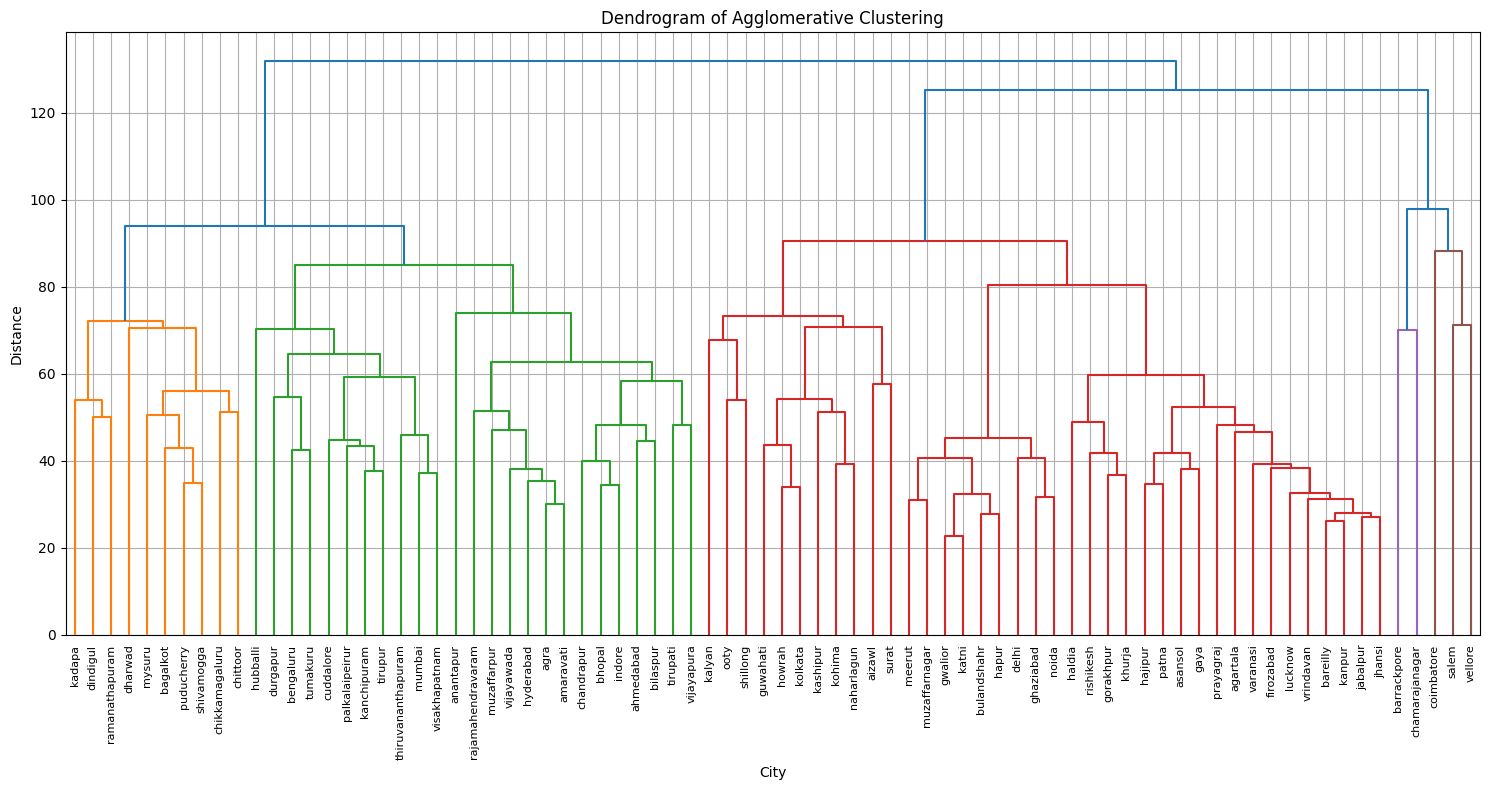

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import json
from scipy.spatial.distance import mahalanobis

file_path = '/content/drive/MyDrive/merged_aggregated_pollutant_statistics_coldweeks_finalstats.csv'
data = pd.read_csv(file_path)

# Drop unwanted columns, including any "Unnamed" columns
columns_to_drop = [col for col in data.columns if "Unnamed" in col]
filtered_data = data.drop(columns=columns_to_drop, errors='ignore')

# Filter out the row corresponding to "Hosur" (if present)
filtered_data = filtered_data[filtered_data['city'] != 'hosur']

# Reset index after filtering
filtered_data.reset_index(drop=True, inplace=True)

# Separate numeric and non-numeric columns
numeric_data = filtered_data.select_dtypes(include=['float64', 'int64'])
non_numeric_data = filtered_data.select_dtypes(exclude=['float64', 'int64'])

# Impute missing values with mean for numeric columns
imputer = SimpleImputer(strategy='mean')
imputed_numeric_data = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_non_numeric_data = pd.DataFrame(encoder.fit_transform(non_numeric_data), columns=encoder.get_feature_names_out(non_numeric_data.columns))

# Combine the numeric and encoded non-numeric data
processed_data = pd.concat([imputed_numeric_data, encoded_non_numeric_data], axis=1)

# Scale the combined data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

# Perform Agglomerative Clustering
nclusters = 5
hierarchical_cluster = AgglomerativeClustering(n_clusters=nclusters, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(scaled_data)

filtered_data['Cluster'] = labels

# Compute covariance matrix and its inverse
cov_matrix = np.cov(scaled_data, rowvar=False)
cov_inv = np.linalg.pinv(cov_matrix)

# Calculate centroids of each cluster
centroids = []
for cluster in range(nclusters):
    cluster_data = scaled_data[labels == cluster]
    centroid = np.mean(cluster_data, axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

# Create dictionary to store city names, centroid, and Mahalanobis distances in each cluster
cold_cluster = {}

if 'city' in filtered_data.columns:
    for cluster in range(nclusters):
        cities_in_cluster = filtered_data[filtered_data['Cluster'] == cluster]['city'].dropna().unique()
        distances_to_centroid = []
        for city_name in cities_in_cluster:
            city_index = filtered_data[filtered_data['city'] == city_name].index[0]
            city_data = scaled_data[city_index]
            centroid = centroids[cluster]
            distance = mahalanobis(city_data, centroid, cov_inv)
            distances_to_centroid.append(distance)

        cold_cluster[cluster] = {
            'Cities': list(cities_in_cluster),
            'Centroid': centroids[cluster].tolist(),
            'Distances_to_Centroid': distances_to_centroid
        }

print("Dictionary of cities, centroids, and Mahalanobis distances in each cluster:")
for cluster, cluster_info in cold_cluster.items():
    print(f"\nCluster {cluster}:")
    print(f"Cities: {', '.join(cluster_info['Cities'])}")
    print(f"Centroid: {cluster_info['Centroid']}")
    print(f"Distances to Centroid: {cluster_info['Distances_to_Centroid']}")

# Save dictionary of cluster information to JSON file
json_output_path = '/content/drive/MyDrive/clusters_city_centroids_distances_cold.json'
with open(json_output_path, 'w') as json_file:
    json.dump(cold_cluster, json_file, indent=4)

print(f'Dictionary saved as JSON file to {json_output_path}')

# Save the clustered data with centroid distances to CSV
output_file_path = '/content/drive/MyDrive/agglomerative_clustered_data_cold_with_centroid_distance.csv'
filtered_data.to_csv(output_file_path, index=False)

print(f'Clustered data saved to {output_file_path}')

# Plot dendrogram
linkage_matrix = linkage(scaled_data, method='ward')
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=filtered_data['city'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Agglomerative Clustering')
plt.xlabel('City')
plt.ylabel('Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

# Function to extract city and year from filename
def extract_city_from_filename(filename, city_list):
    temp = filename.split('_')

    try:
        year = int(temp[3])
    except ValueError:
        print(f"Error: Year not found in filename: {filename}")
        return None, None

    city = temp[-3].strip().lower()

    # Special city handling (keeping your handling intact)
    special_city_mapping = {
        'kalaburgi': 'kalaburagi',
        'chamarajanagara': 'chamarajanagar',
        'chikkamagaluru': 'chikkamagaluru',
        'aizawl': 'aizawl',
        'imphal': 'imphal',
        'jaipur': 'jaipur',
        'chennai': 'chennai',
        'palkalaiperur': 'palkalaiperur'
    }


    for key, value in special_city_mapping.items():
        if key in city:
            print(f"Special handling for city: {value} in file {filename}")
            city = value
    if filename == 'Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv':
        city = 'palkalaipeirur'
    # Check if city is in the city list; otherwise, try to extract an alternate city name
    if city not in city_list:
        print(f"City '{city}' not found in city_list. Trying alternate city extraction...")
        city = temp[-4].strip().lower()

    if city not in city_list:
        print(f"City '{city}' still not found in city_list. Skipping file: {filename}")
        return None, None

    return city, year

# Function to apply Min-Max Scaling to pollutants
def apply_min_max_scaling(df, pollutants):
    scaler = MinMaxScaler()
    df[pollutants] = scaler.fit_transform(df[pollutants])
    return df

# Function to categorize time of day
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Function to get hot weeks for a specific city from the weather_week_data.csv
def get_hot_weeks_for_city(city_name, weather_week_data):
    hot_weeks = weather_week_data['hot_weeks'].dropna().apply(lambda x: [int(week) for week in x.split(',')])
    return hot_weeks

# Function to process files for each city
def process_files(data_directory, city_files, city, year_list):
    all_data = []

    # Process each file for the given city
    for file in city_files:
        file_path = os.path.join(data_directory, file)
        print(f"Processing file: {file}")  # Print the file being processed

        # Read the file
        df = pd.read_csv(file_path)

        # Define columns to retain
        df = df[columns_to_retain]
        print(f"Before dropping NaN rows, remaining data in file: {file}")
        print(df.isna().sum())  # Print the count of NaN values per column after drop
        print(df.head())  # Print first few rows to check the data
        df=df.dropna()
        print(f"After dropping NaN rows, remaining data in file: {file}")
        print(df.isna().sum())  # Print the count of NaN values per column after drop
        print(df.head())  # Print first few rows to check the data

        # Add necessary datetime columns and time-based features (adjust this section as needed)
        df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
       #df.dropna(subset=['Timestamp'], inplace=True)
        df['Year'] = df['Timestamp'].dt.year
        df['Month'] = df['Timestamp'].dt.month
        df['Week_Number'] = df['Timestamp'].dt.isocalendar().week
        df['Day_of_Week'] = df['Timestamp'].dt.dayofweek
        df['Hour'] = df['Timestamp'].dt.hour
        df['Time_of_Day'] = df['Hour'].apply(categorize_time_of_day)

        # Filter the data for valid years
        df = df[df['Year'].isin(year_list)]

        # Add the city name to the dataframe
        df['City'] = city

        # Append the current city's data
        all_data.append(df)

    # Combine data from all files for the current city
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

# Function to aggregate statistics for hot weeks combined
def aggregate_hot_week_stats(df):
    result_dict = {}
    pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']

    # Filter for hot weeks only
    hot_df = df[df['Hot_Week'] == True]

    if not hot_df.empty:
       result_dict['City'] = city
       for pollutant in pollutants:
            # Overall statistics for hot weeks
            result_dict[f'{pollutant.split()[0].lower()}_hot_mean'] = hot_df[pollutant].mean()
            result_dict[f'{pollutant.split()[0].lower()}_hot_std'] = hot_df[pollutant].std()
            result_dict[f'{pollutant.split()[0].lower()}_hot_min'] = hot_df[pollutant].min()
            result_dict[f'{pollutant.split()[0].lower()}_hot_max'] = hot_df[pollutant].max()
            result_dict[f'{pollutant.split()[0].lower()}_hot_50q'] = hot_df[pollutant].quantile(0.5)
            result_dict[f'{pollutant.split()[0].lower()}_hot_75q'] = hot_df[pollutant].quantile(0.75)
            result_dict[f'{pollutant.split()[0].lower()}_hot_25q'] = hot_df[pollutant].quantile(0.25)

            # Time-of-day statistics (morning, afternoon, evening, night) for hot weeks
            for time_of_day in ['Morning', 'Afternoon', 'Evening', 'Night']:
                time_based_df = hot_df[hot_df['Time_of_Day'] == time_of_day]
                if not time_based_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_hot_mean'] = time_based_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_hot_std'] = time_based_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_hot_min'] = time_based_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_hot_max'] = time_based_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_hot_50q'] = time_based_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_hot_75q'] = time_based_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_{time_of_day.lower()}_hot_25q'] = time_based_df[pollutant].quantile(0.25)

            # Day-of-week statistics for hot weeks
            for day_of_week in range(7):  # 0=Monday, 6=Sunday
                day_of_week_df = hot_df[hot_df['Day_of_Week'] == day_of_week]
                if not day_of_week_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_hot_mean'] = day_of_week_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_hot_std'] = day_of_week_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_hot_min'] = day_of_week_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_hot_max'] = day_of_week_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_hot_50q'] = day_of_week_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_hot_75q'] = day_of_week_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_day_of_week_{day_of_week}_hot_25q'] = day_of_week_df[pollutant].quantile(0.25)

            # Month statistics for hot weeks
            for month in range(1, 13):  # 1=January, 12=December
                month_df = hot_df[hot_df['Month'] == month]
                if not month_df.empty:
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_hot_mean'] = month_df[pollutant].mean()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_hot_std'] = month_df[pollutant].std()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_hot_min'] = month_df[pollutant].min()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_hot_max'] = month_df[pollutant].max()
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_hot_50q'] = month_df[pollutant].quantile(0.5)
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_hot_75q'] = month_df[pollutant].quantile(0.75)
                    result_dict[f'{pollutant.split()[0].lower()}_month_{month}_hot_25q'] = month_df[pollutant].quantile(0.25)

    return result_dict

# Now, using the `combined_df` for further processing
all_stats = []
city_files_dict = {}

# Read lookup and weather week data files
lookup_file = "/content/drive/MyDrive/Copy of parameters_metadata.csv"
final_stat_marker_file = "/content/drive/MyDrive/Final_stat_CityWise_Marker - Updated.csv"
weather_week_data_file = "/content/drive/MyDrive/weather_week_numbers.csv"

# Read lookup and final statistics files
lookup_df = pd.read_csv(lookup_file)
final_stat_marker_df = pd.read_csv(final_stat_marker_file)

# Filter for flagged=False
lookup_df = lookup_df[lookup_df['flagged'] == False]

# Get the list of cities
city_list = final_stat_marker_df['City'].unique().tolist()
city_list = [city.lower() for city in city_list]

# Read the weather week data to get hot weeks
weather_week_data = pd.read_csv(weather_week_data_file)

# List of valid years
year_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Iterate over each file in the directory and process city-based data
all_files = os.listdir("/content/drive/MyDrive/Master Dataset")
city_files_dict = {}

for file in all_files:
    if file in lookup_df['filename'].values:
        city, year = extract_city_from_filename(file, city_list)
        if city and year in year_list:
            if city not in city_files_dict:
                city_files_dict[city] = []
            city_files_dict[city].append(file)

# Loop through the cities and process the data for each city
for city, city_files in city_files_dict.items():
    print(f"Processing data for city: {city}")

    # Get the combined data for this city
    combined_df = process_files("/content/drive/MyDrive/Master Dataset", city_files, city, year_list)

    # Extract hot data based on hot weeks for the current city
    hot_weeks = get_hot_weeks_for_city(city, weather_week_data)

    # Mark the rows for hot weeks
    combined_df['Hot_Week'] = combined_df['Week_Number'].apply(lambda week: week in hot_weeks)

    # Filter out data for hot weeks only
    hot_df = combined_df[combined_df['Hot_Week'] == True]

    if not hot_df.empty:
        # Optionally apply Min-Max scaling to pollutants if needed
        pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'CO (mg/m³)', 'AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'TOT-RF (mm)', 'BP (mmHg)']
        hot_df = apply_min_max_scaling(hot_df, pollutants)

        # Aggregate statistics for hot weeks
        hot_stats = aggregate_hot_week_stats(hot_df)

        # Append city-wise hot data to the all_stats list
        all_stats.append(hot_stats)

# Combine all hot data from all cities into one DataFrame
if all_stats:
    combined_hot_df = pd.DataFrame(all_stats)
    print(f"Combined hot data for all cities: {combined_hot_df.shape}")

    # Perform further operations with `combined_hot_df` if needed
    # Example: Save the combined hot data
    hot_data_file_path = "/content/drive/MyDrive/all_cities_hot_week_data.csv"
    combined_hot_df.to_csv(hot_data_file_path, index=False)
    print(f"Saved all hot week data for all cities to: {hot_data_file_path}")
else:
    print("No hot data found for any city.")





City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'dpcc' not found in city_list. Trying alternate city extraction...
City 'meghalaya' not found in city_list. Trying alternate city extraction...
City 'meghalaya' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'tripura' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Trying alternate city extraction...
City 'kerala' not found in city_list. Try

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: surat
Processing file: Raw_data_15Min_2023_site_5664_Science_Center_Surat_SMC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5664_Science_Center_Surat_SMC_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     8969
PM10 (µg/m³)     10224
CO (mg/m³)        1330
AT (°C)           3313
RH (%)            3313
WS (m/s)          3313
WD (deg)          3313
TOT-RF (mm)          0
BP (mmHg)         3313
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          52.00         72.16        0.57    20.91   
1  2023-01-01 00:15:00          52.00         72.00        0.57    20.76   
2  2023-01-01 00:30:00          52.00         72.00        0.58    20.48   
3  2023-01-01 00:45:00          52.00         72.00        0.57    20.40   
4  2023-01-01 01:00:00          79.07        105.00        0.56    20.16   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   57.51      

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Streaming output truncated to the last 5000 lines.
3    93.5       0.1     247.0          0.0      991.8  
4    93.9       0.2     274.9          0.0      991.7  
Processing file: Raw_data_15Min_2020_site_1429_Nehru_Nagar_Delhi_DPCC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_1429_Nehru_Nagar_Delhi_DPCC_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1063
PM10 (µg/m³)     1021
CO (mg/m³)       2857
AT (°C)           907
RH (%)            866
WS (m/s)         1589
WD (deg)          989
TOT-RF (mm)         0
BP (mmHg)         905
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         8.8      6.2   
1  2020-01-01 00:15:00            NaN           NaN         8.7      6.1   
2  2020-01-01 00:30:00            NaN           NaN         7.8      6.0   
3  2020-01-01 00:45:00          972.0           NaN         7.6      5.9   
4  2020-01-01 01:00:00         

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bilaspur
Processing file: Raw_data_15Min_2023_site_5503_Mangala_Bilaspur_NTPC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5503_Mangala_Bilaspur_NTPC_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7452
PM10 (µg/m³)      8332
CO (mg/m³)       10703
AT (°C)           5245
RH (%)            5323
WS (m/s)          5602
WD (deg)          5607
TOT-RF (mm)          0
BP (mmHg)         5248
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          26.40         79.76         1.8    33.98   
1  2023-01-01 00:15:00          19.77         66.27         1.8    34.15   
2  2023-01-01 00:30:00          18.65         64.19         1.6    34.16   
3  2023-01-01 00:45:00          18.65         64.19         1.7    34.22   
4  2023-01-01 01:00:00          18.65         64.19         2.5    34.27   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   50.96      0.1

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: naharlagun
Processing file: Raw_data_15Min_2023_site_5446_Naharlagun_Naharlagun_APSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5446_Naharlagun_Naharlagun_APSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    16015
PM10 (µg/m³)     16756
CO (mg/m³)       12962
AT (°C)          21987
RH (%)           21987
WS (m/s)         21989
WD (deg)         21987
TOT-RF (mm)          0
BP (mmHg)        22008
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gaya
Processing file: Raw_data_15Min_2023_site_5338_SFTI_Kusdihra_Gaya_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5338_SFTI_Kusdihra_Gaya_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2912
PM10 (µg/m³)     2710
CO (mg/m³)       1267
AT (°C)          1705
RH (%)           1708
WS (m/s)         1758
WD (deg)         1720
TOT-RF (mm)         0
BP (mmHg)        1704
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         130.48        157.37        1.88    13.82   
1  2023-01-01 00:15:00         130.48        157.37        1.90    13.30   
2  2023-01-01 00:30:00         138.10        160.44        2.18    12.66   
3  2023-01-01 00:45:00         154.12        167.24        2.52    11.86   
4  2023-01-01 01:00:00         154.12        167.24        2.63    11.58   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.00      0.27    355

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hajipur
Processing file: Raw_data_15Min_2023_site_5337_Industrial_Area_Hajipur_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5337_Industrial_Area_Hajipur_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2882
PM10 (µg/m³)     2749
CO (mg/m³)       1493
AT (°C)          1879
RH (%)           1873
WS (m/s)         1984
WD (deg)         1873
TOT-RF (mm)         0
BP (mmHg)        1879
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          292.9         527.4        3.62    11.47   
1  2023-01-01 00:15:00          286.7         476.8        3.63    10.78   
2  2023-01-01 00:30:00          286.7         476.8        3.63    10.53   
3  2023-01-01 00:45:00          286.7         476.8        3.79    10.58   
4  2023-01-01 01:00:00          234.7         398.8        3.90    10.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.15    

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: muzaffarpur
Processing file: Raw_data_15Min_2023_site_5370_Buddha_Colony_Muzaffarpur_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5370_Buddha_Colony_Muzaffarpur_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4008
PM10 (µg/m³)     3933
CO (mg/m³)       1422
AT (°C)          4444
RH (%)           4435
WS (m/s)         2454
WD (deg)         2374
TOT-RF (mm)         0
BP (mmHg)        2335
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          597.2         652.0        1.85    14.35   
1  2023-01-01 00:15:00          597.2         652.0        1.79    14.15   
2  2023-01-01 00:30:00          485.0         540.0        1.79    13.93   
3  2023-01-01 00:45:00          475.6         529.0        1.78    13.86   
4  2023-01-01 01:00:00          475.6         529.0        1.81    13.84   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   8

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: patna
Processing file: Raw_data_15Min_2023_site_5262_Rajbansi_Nagar_Patna_BSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5262_Rajbansi_Nagar_Patna_BSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1656
PM10 (µg/m³)     1897
CO (mg/m³)        732
AT (°C)           819
RH (%)            820
WS (m/s)          844
WD (deg)          863
TOT-RF (mm)         0
BP (mmHg)         844
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          483.6         641.3        4.58    12.20   
1  2023-01-01 00:15:00          499.9         658.4        4.77    12.08   
2  2023-01-01 00:30:00          499.9         658.4        4.78    12.04   
3  2023-01-01 00:45:00          499.9         658.4        4.77    12.06   
4  2023-01-01 01:00:00          458.8         633.4        4.65    11.91   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.30      0.09  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: guwahati
Processing file: Raw_data_15Min_2023_site_5073_Railway_Colony_Guwahati_PCBA_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5073_Railway_Colony_Guwahati_PCBA_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     5949
PM10 (µg/m³)      5703
CO (mg/m³)        1803
AT (°C)          13952
RH (%)           13952
WS (m/s)         13952
WD (deg)         13952
TOT-RF (mm)          0
BP (mmHg)        14197
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         576.00        664.43         NaN    12.97   
1  2023-01-01 00:15:00         576.00        672.00        4.60    15.00   
2  2023-01-01 00:30:00         576.00        672.00        4.75    15.05   
3  2023-01-01 00:45:00         578.29        672.00        4.61    14.96   
4  2023-01-01 01:00:00            NaN           NaN        4.78    14.86   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: amaravati
Processing file: Raw_data_15Min_2023_site_1406_Secretariat_Amaravati_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1406_Secretariat_Amaravati_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5702
PM10 (µg/m³)     5101
CO (mg/m³)       5373
AT (°C)          4550
RH (%)           4769
WS (m/s)         4550
WD (deg)         4550
TOT-RF (mm)         0
BP (mmHg)        4550
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           43.0          79.0        0.64     22.2   
1  2023-01-01 00:15:00           43.0          79.0        0.62     22.2   
2  2023-01-01 00:30:00           43.0          79.0        0.62     22.2   
3  2023-01-01 00:45:00           41.0          79.0        0.64     22.1   
4  2023-01-01 01:00:00           41.0          79.0        0.62     22.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    96.0      

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: anantapur
Processing file: Raw_data_15Min_2023_site_5632_Gulzarpet_Anantapur_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5632_Gulzarpet_Anantapur_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4543
PM10 (µg/m³)     5130
CO (mg/m³)       5008
AT (°C)          3673
RH (%)           3689
WS (m/s)         7299
WD (deg)         3942
TOT-RF (mm)         0
BP (mmHg)        3804
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          16.90         44.50        0.74    23.49   
1  2023-01-01 00:15:00          17.16         44.06        0.89    23.18   
2  2023-01-01 00:30:00          18.18         42.18        1.00    22.89   
3  2023-01-01 00:45:00          18.18         42.18        1.09    22.67   
4  2023-01-01 01:00:00          18.18         42.18        1.54    22.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   63.18       NaN

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chittoor
Processing file: Raw_data_15Min_2022_site_5665_Gangineni_Cheruvu_Chittoor_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5665_Gangineni_Cheruvu_Chittoor_APPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    32734
PM10 (µg/m³)     32745
CO (mg/m³)       31521
AT (°C)          31343
RH (%)           31343
WS (m/s)         31343
WD (deg)         31344
TOT-RF (mm)          0
BP (mmHg)        33502
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kadapa
Processing file: Raw_data_15Min_2023_site_5693_Yerramukkapalli_Kadapa_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5693_Yerramukkapalli_Kadapa_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7702
PM10 (µg/m³)     7708
CO (mg/m³)       3482
AT (°C)          3368
RH (%)           3368
WS (m/s)         3407
WD (deg)         3417
TOT-RF (mm)         0
BP (mmHg)        4137
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN       

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: rajamahendravaram
Processing file: Raw_data_15Min_2023_site_1399_Anand_Kala_Kshetram_Rajamahendravaram_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1399_Anand_Kala_Kshetram_Rajamahendravaram_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3798
PM10 (µg/m³)     1384
CO (mg/m³)       5155
AT (°C)          1454
RH (%)           1149
WS (m/s)         1104
WD (deg)         1127
TOT-RF (mm)         0
BP (mmHg)        1104
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           34.0          64.0        0.69     29.9   
1  2023-01-01 00:15:00           34.0          64.0        0.77     29.5   
2  2023-01-01 00:30:00           34.0          64.0        0.72     29.3   
3  2023-01-01 00:45:00           47.0          83.0        0.65     29.8   
4  2023-01-01 01:00:00           47.0          83.0        0.66     29.6   

   RH (%)  WS (m/s)  WD (deg)  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tirupati
Processing file: Raw_data_15Min_2023_site_5666_Vaikuntapuram_Tirupati_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5666_Vaikuntapuram_Tirupati_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    8100
PM10 (µg/m³)     9194
CO (mg/m³)       2621
AT (°C)          7227
RH (%)           7226
WS (m/s)         2298
WD (deg)         2289
TOT-RF (mm)         0
BP (mmHg)        2301
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN     

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vijayawada
Processing file: Raw_data_15Min_2023_site_5685_Kanuru_Vijayawada_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5685_Kanuru_Vijayawada_APPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    12655
PM10 (µg/m³)     13410
CO (mg/m³)       12949
AT (°C)          10537
RH (%)           10559
WS (m/s)         10543
WD (deg)         10549
TOT-RF (mm)          0
BP (mmHg)        10538
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN   

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: visakhapatnam
Processing file: Raw_data_15Min_2023_site_260_GVM_Corporation_Visakhapatnam_APPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_260_GVM_Corporation_Visakhapatnam_APPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6717
PM10 (µg/m³)     6791
CO (mg/m³)       6620
AT (°C)          6029
RH (%)           6029
WS (m/s)         6027
WD (deg)         6033
TOT-RF (mm)         0
BP (mmHg)        5648
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           44.0          96.0        0.52     25.2   
1  2023-01-01 00:15:00           44.0          96.0        0.40     25.1   
2  2023-01-01 00:30:00           44.0          96.0        0.35     25.0   
3  2023-01-01 00:45:00           55.0         112.0        0.55     24.9   
4  2023-01-01 01:00:00           55.0         112.0        0.69     24.8   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: shillong
Processing file: Raw_data_15Min_2023_site_5593_JN_Stadium_Shillong_Meghalaya_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5593_JN_Stadium_Shillong_Meghalaya_PCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    23846
PM10 (µg/m³)     23266
CO (mg/m³)       22146
AT (°C)          23463
RH (%)           23463
WS (m/s)         23464
WD (deg)         23463
TOT-RF (mm)          0
BP (mmHg)        23463
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mm

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: agartala
Processing file: Raw_data_15Min_2022_site_5377_Kunjaban_Agartala_Tripura_SPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5377_Kunjaban_Agartala_Tripura_SPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     4298
PM10 (µg/m³)      3717
CO (mg/m³)        2299
AT (°C)          11594
RH (%)           12360
WS (m/s)         11624
WD (deg)         11594
TOT-RF (mm)          0
BP (mmHg)        21441
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN    10.60   
1  2022-01-01 00:15:00         118.00        181.00        1.05    10.36   
2  2022-01-01 00:30:00         118.00        181.00        1.10    10.64   
3  2022-01-01 00:45:00         118.00        181.00        1.09    15.62   
4  2022-01-01 01:00:00         123.82        205.18        1.09    12.50   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chandrapur
Processing file: Raw_data_15Min_2017_site_271_Chauhan_Colony_Chandrapur_MPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2017_site_271_Chauhan_Colony_Chandrapur_MPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    12287
PM10 (µg/m³)     10680
CO (mg/m³)        7802
AT (°C)          28626
RH (%)            9530
WS (m/s)          9528
WD (deg)         10825
TOT-RF (mm)          0
BP (mmHg)         9022
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2017-01-01 00:00:00           68.0         120.0        0.85      NaN   
1  2017-01-01 00:15:00           68.0         120.0        0.84      NaN   
2  2017-01-01 00:30:00           68.0         120.0        0.81      NaN   
3  2017-01-01 00:45:00          101.0         151.0        0.81      NaN   
4  2017-01-01 01:00:00          101.0         151.0        0.82      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kalyan
Processing file: Raw_data_15Min_2023_site_5118_Khadakpada_Kalyan_MPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5118_Khadakpada_Kalyan_MPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7006
PM10 (µg/m³)     9836
CO (mg/m³)       6440
AT (°C)          6626
RH (%)           6624
WS (m/s)         6625
WD (deg)         6625
TOT-RF (mm)         0
BP (mmHg)        6626
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           38.0         172.0        2.54    28.74   
1  2023-01-01 00:15:00           93.0         172.0        1.34    28.75   
2  2023-01-01 00:30:00           93.0         172.0        1.62    28.75   
3  2023-01-01 00:45:00           93.0         164.8        1.39    28.74   
4  2023-01-01 01:00:00           93.0         160.0        1.30    28.74   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   89.45      1.32    338.7

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: mumbai
Processing file: Raw_data_15Min_2020_site_5396_Deonar_Mumbai_IITM_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_5396_Deonar_Mumbai_IITM_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    30722
PM10 (µg/m³)     30724
CO (mg/m³)       30653
AT (°C)          30633
RH (%)           30634
WS (m/s)         33143
WD (deg)         30630
TOT-RF (mm)          0
BP (mmHg)        31768
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2020-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2020-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2020-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2020-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN       NaN       

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bhopal
Processing file: Raw_data_15Min_2023_site_5247_T_T_Nagar_Bhopal_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5247_T_T_Nagar_Bhopal_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1277
PM10 (µg/m³)     1212
CO (mg/m³)       3220
AT (°C)           938
RH (%)            938
WS (m/s)          938
WD (deg)          988
TOT-RF (mm)         0
BP (mmHg)         939
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           88.0         185.0        1.25     15.1   
1  2023-01-01 00:15:00           88.0         185.0        0.98     14.9   
2  2023-01-01 00:30:00           88.0         185.0        1.08     14.9   
3  2023-01-01 00:45:00           84.0         160.0        1.17     14.7   
4  2023-01-01 01:00:00           84.0         160.0        1.06     14.5   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    73.0       1.4     171.

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gwalior
Processing file: Raw_data_15Min_2023_site_5273_City_Center_Gwalior_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5273_City_Center_Gwalior_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2254
PM10 (µg/m³)     3932
CO (mg/m³)       5506
AT (°C)          1241
RH (%)           1241
WS (m/s)         1241
WD (deg)         1229
TOT-RF (mm)         0
BP (mmHg)        1241
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          334.0         432.0        1.72      7.8   
1  2023-01-01 00:15:00          334.0         432.0        1.49      7.9   
2  2023-01-01 00:30:00          334.0         432.0        1.35      7.8   
3  2023-01-01 00:45:00          256.0         355.0        1.50      7.8   
4  2023-01-01 01:00:00          256.0         355.0        1.58      7.8   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    95.0       0.3  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: indore
Processing file: Raw_data_15Min_2023_site_5248_Chhoti_Gwaltoli_Indore_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5248_Chhoti_Gwaltoli_Indore_MPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     1051
PM10 (µg/m³)      1081
CO (mg/m³)        3757
AT (°C)            848
RH (%)             849
WS (m/s)           849
WD (deg)           849
TOT-RF (mm)          0
BP (mmHg)        16036
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           35.0         149.0        0.74     16.2   
1  2023-01-01 00:15:00           35.0         149.0        0.65     15.9   
2  2023-01-01 00:30:00           35.0         149.0        1.04     16.0   
3  2023-01-01 00:45:00           37.0         176.0        1.24     16.0   
4  2023-01-01 01:00:00           37.0         176.0        1.15     16.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    6

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: jabalpur
Processing file: Raw_data_15Min_2023_site_5249_Marhatal_Jabalpur_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5249_Marhatal_Jabalpur_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1563
PM10 (µg/m³)     1545
CO (mg/m³)       4391
AT (°C)           811
RH (%)            811
WS (m/s)          811
WD (deg)          811
TOT-RF (mm)         0
BP (mmHg)         811
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          102.0         157.0        1.09     14.1   
1  2023-01-01 00:15:00          102.0         157.0        1.12     14.1   
2  2023-01-01 00:30:00          102.0         157.0         NaN     14.0   
3  2023-01-01 00:45:00           95.0         164.0         NaN     13.9   
4  2023-01-01 01:00:00           95.0         164.0         NaN     13.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    69.0       0.5     

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: katni
Processing file: Raw_data_15Min_2023_site_5250_Gole_Bazar_Katni_MPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5250_Gole_Bazar_Katni_MPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4940
PM10 (µg/m³)     8978
CO (mg/m³)       5170
AT (°C)          4188
RH (%)           4188
WS (m/s)         4188
WD (deg)         4189
TOT-RF (mm)         0
BP (mmHg)        4188
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          140.0         232.0        0.94     12.8   
1  2023-01-01 00:15:00          140.0         232.0         NaN     12.7   
2  2023-01-01 00:30:00          140.0         232.0        1.12     12.4   
3  2023-01-01 00:45:00          163.0         254.0        1.12     12.3   
4  2023-01-01 01:00:00          163.0         254.0        1.15     12.1   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    80.0       0.3     237.0

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: thiruvananthapuram
Processing file: Raw_data_15Min_2023_site_252_Plammoodu_Thiruvananthapuram_Kerala_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_252_Plammoodu_Thiruvananthapuram_Kerala_PCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6833
PM10 (µg/m³)     4991
CO (mg/m³)       2256
AT (°C)          2330
RH (%)           2329
WS (m/s)         2331
WD (deg)         2329
TOT-RF (mm)         0
BP (mmHg)        5953
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           52.0          81.0        0.98     23.2   
1  2023-01-01 00:15:00           52.0          81.0        0.98     23.2   
2  2023-01-01 00:30:00           52.0          81.0        0.98     23.1   
3  2023-01-01 00:45:00           66.0         100.0        0.97     23.0   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (m

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bagalkot
Processing file: Raw_data_15Min_2023_site_5264_Vidayagiri_Bagalkot_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5264_Vidayagiri_Bagalkot_KSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1797
PM10 (µg/m³)     2189
CO (mg/m³)       3275
AT (°C)          1516
RH (%)           2633
WS (m/s)         1525
WD (deg)         1494
TOT-RF (mm)         0
BP (mmHg)        2511
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           1.00           NaN        0.00    26.39   
1  2023-01-01 00:15:00          23.07         42.38        0.60    26.66   
2  2023-01-01 00:30:00          23.26         42.70        0.68    26.89   
3  2023-01-01 00:45:00          22.98         42.22        0.56    26.93   
4  2023-01-01 01:00:00          23.33         42.82        0.70    26.43   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    63.0      2.37 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bengaluru
Processing file: Raw_data_15Min_2022_site_1558_Silk_Board_Bengaluru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_1558_Silk_Board_Bengaluru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7963
PM10 (µg/m³)      8047
CO (mg/m³)       11296
AT (°C)           7076
RH (%)            7063
WS (m/s)          7061
WD (deg)          7063
TOT-RF (mm)          0
BP (mmHg)        23139
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN        0.17     18.5   
1  2022-01-01 00:15:00            NaN           NaN        0.22     18.5   
2  2022-01-01 00:30:00            NaN           NaN        0.16     18.5   
3  2022-01-01 00:45:00            NaN           NaN         NaN     18.4   
4  2022-01-01 01:00:00            NaN           NaN        0.23     18.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    88

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: chamarajanagar
Processing file: Raw_data_15Min_2021_site_5124_Urban_Chamarajanagar_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2021_site_5124_Urban_Chamarajanagar_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     8303
PM10 (µg/m³)      8145
CO (mg/m³)        7428
AT (°C)          33053
RH (%)           33021
WS (m/s)         12898
WD (deg)         12051
TOT-RF (mm)          0
BP (mmHg)         8168
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2021-01-01 00:00:00          16.20           NaN        0.30      NaN   
1  2021-01-01 00:15:00          15.84         35.36        0.28      NaN   
2  2021-01-01 00:30:00          16.26         33.33        0.28      NaN   
3  2021-01-01 00:45:00          16.48         34.52        0.28      NaN   
4  2021-01-01 01:00:00          15.88         35.78        0.29      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: dharwad
Processing file: Raw_data_15Min_2023_site_5638_Kalabhavan_Dharwad_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5638_Kalabhavan_Dharwad_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10807
PM10 (µg/m³)     10100
CO (mg/m³)        6806
AT (°C)           6029
RH (%)            6116
WS (m/s)          7952
WD (deg)          7165
TOT-RF (mm)          0
BP (mmHg)         6039
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          47.76         84.22        0.93    23.75   
1  2023-01-01 00:15:00          47.76         84.22        1.06    23.67   
2  2023-01-01 00:30:00          47.76         84.22        0.99    23.56   
3  2023-01-01 00:45:00          46.13         76.20        0.85    23.56   
4  2023-01-01 01:00:00          45.51         73.11        0.93    23.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   11.52    

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hubballi
Processing file: Raw_data_15Min_2023_site_5680_Lingaraj_Nagar_Hubballi_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5680_Lingaraj_Nagar_Hubballi_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6594
PM10 (µg/m³)      7465
CO (mg/m³)        6205
AT (°C)           4545
RH (%)            4577
WS (m/s)         11155
WD (deg)         11109
TOT-RF (mm)          0
BP (mmHg)        12476
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          66.66        128.96        0.48    23.79   
1  2023-01-01 00:15:00          66.66        128.96        0.49    23.67   
2  2023-01-01 00:30:00          66.66        129.85        0.50    23.73   
3  2023-01-01 00:45:00          66.66        130.51        0.50    23.68   
4  2023-01-01 01:00:00          60.91        130.51        0.49    23.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kalaburagi
Processing file: Raw_data_15Min_2023_site_5679_Mahatma_Basaveswar_Colony_Kalaburgi_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5679_Mahatma_Basaveswar_Colony_Kalaburgi_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    13238
PM10 (µg/m³)     13013
CO (mg/m³)       12726
AT (°C)          12585
RH (%)           12504
WS (m/s)         12857
WD (deg)         12858
TOT-RF (mm)          0
BP (mmHg)        12421
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          65.70         86.04        0.98     21.5   
1  2023-01-01 00:15:00          65.70         86.04        0.99     21.5   
2  2023-01-01 00:30:00          60.79         81.13        1.07     21.5   
3  2023-01-01 00:45:00          59.48         79.82        1.07     21.5   
4  2023-01-01 01:00:00          59.48         79.82        1.05     21.5   

   RH (%)  WS (m/s)  WD (deg)  T

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: mysuru
Processing file: Raw_data_15Min_2021_site_5125_Hebbal_1st_Stage_Mysuru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2021_site_5125_Hebbal_1st_Stage_Mysuru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6353
PM10 (µg/m³)      6642
CO (mg/m³)        6418
AT (°C)          33765
RH (%)            6110
WS (m/s)          6167
WD (deg)          6606
TOT-RF (mm)          0
BP (mmHg)         6111
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2021-01-01 00:00:00          21.12         66.37        0.35      NaN   
1  2021-01-01 00:15:00          19.37         66.37        0.27      NaN   
2  2021-01-01 00:30:00          16.74         66.37        0.26      NaN   
3  2021-01-01 00:45:00          16.74         52.51        0.23      NaN   
4  2021-01-01 01:00:00          16.74         51.69        0.22      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: shivamogga
Processing file: Raw_data_15Min_2022_site_5266_Vinoba_Nagara_Shivamogga_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5266_Vinoba_Nagara_Shivamogga_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2520
PM10 (µg/m³)      2311
CO (mg/m³)       15555
AT (°C)           2126
RH (%)           15691
WS (m/s)         16079
WD (deg)         16097
TOT-RF (mm)          0
BP (mmHg)         2112
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN         47.91         NaN    21.81   
1  2022-01-01 00:15:00          23.53         47.91         NaN    21.70   
2  2022-01-01 00:30:00          23.32         47.61         NaN    21.60   
3  2022-01-01 00:45:00          23.46         47.04         NaN    21.36   
4  2022-01-01 01:00:00          22.12         47.04         NaN    21.20   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg) 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tumakuru
Processing file: Raw_data_15Min_2022_site_5682_Thimmalapura_Tumakuru_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5682_Thimmalapura_Tumakuru_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    33508
PM10 (µg/m³)     33283
CO (mg/m³)       32857
AT (°C)          32863
RH (%)           32862
WS (m/s)         32895
WD (deg)         32895
TOT-RF (mm)          0
BP (mmHg)        32862
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vijayapura
Processing file: Raw_data_15Min_2023_site_5267_Ibrahimpur_Vijayapura_KSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5267_Ibrahimpur_Vijayapura_KSPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     1635
PM10 (µg/m³)      1953
CO (mg/m³)        5013
AT (°C)           1542
RH (%)            1549
WS (m/s)         19473
WD (deg)         16680
TOT-RF (mm)          0
BP (mmHg)         1549
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           4.00          8.00       10.00    20.99   
1  2023-01-01 00:15:00          19.50         53.10        0.09    20.96   
2  2023-01-01 00:30:00          20.24         53.84        0.58    20.88   
3  2023-01-01 00:45:00          19.42         53.02        0.04    20.88   
4  2023-01-01 01:00:00          20.32         53.92        0.64    20.88   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kolkata
Processing file: Raw_data_15Min_2023_site_5111_Jadavpur_Kolkata_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5111_Jadavpur_Kolkata_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1372
PM10 (µg/m³)     1424
CO (mg/m³)       1283
AT (°C)           965
RH (%)            965
WS (m/s)         1051
WD (deg)          964
TOT-RF (mm)         0
BP (mmHg)         963
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         123.28        224.03        1.31    18.75   
1  2023-01-01 00:15:00         124.61        218.47        1.30    18.79   
2  2023-01-01 00:30:00         124.61        218.47        1.28    18.80   
3  2023-01-01 00:45:00         124.61        218.47        1.29    18.67   
4  2023-01-01 01:00:00         123.88        217.91        1.28    18.71   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.50      0.12     99.

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kashipur
Processing file: Raw_data_15Min_2023_site_5704_Govt._Girls_Inter_College_Kashipur_UKPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5704_Govt._Girls_Inter_College_Kashipur_UKPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    14046
PM10 (µg/m³)     14097
CO (mg/m³)       13806
AT (°C)          13573
RH (%)           16247
WS (m/s)         13718
WD (deg)         13710
TOT-RF (mm)          0
BP (mmHg)        13809
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-R

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: rishikesh
Processing file: Raw_data_15Min_2023_site_5703_Shivaji_Nagar_Rishikesh_UKPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5703_Shivaji_Nagar_Rishikesh_UKPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5560
PM10 (µg/m³)     5535
CO (mg/m³)       6444
AT (°C)          4645
RH (%)           4645
WS (m/s)         4653
WD (deg)         4668
TOT-RF (mm)         0
BP (mmHg)        4678
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: puducherry
Processing file: Raw_data_15Min_2023_site_5423_Jawahar_Nagar_Puducherry_PPCC_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5423_Jawahar_Nagar_Puducherry_PPCC_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3333
PM10 (µg/m³)     2677
CO (mg/m³)       1448
AT (°C)           656
RH (%)            656
WS (m/s)          656
WD (deg)          665
TOT-RF (mm)         0
BP (mmHg)         656
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           18.0          43.0        1.05     26.9   
1  2023-01-01 00:15:00           18.0          43.0        1.25     26.6   
2  2023-01-01 00:30:00           18.0           NaN        1.13     26.4   
3  2023-01-01 00:45:00          103.0         146.0        1.36     26.2   
4  2023-01-01 01:00:00          103.0         146.0        1.57     26.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    81.0 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kohima
Processing file: Raw_data_15Min_2022_site_5375_PWD_Juction_Kohima_NPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5375_PWD_Juction_Kohima_NPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10104
PM10 (µg/m³)      7977
CO (mg/m³)        4504
AT (°C)          20116
RH (%)           20251
WS (m/s)         20123
WD (deg)         20116
TOT-RF (mm)          0
BP (mmHg)        20122
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN    10.39   
1  2022-01-01 00:15:00           22.0          41.0        0.46    10.41   
2  2022-01-01 00:30:00           22.0          41.0        0.45    10.12   
3  2022-01-01 00:45:00           20.5          47.0        0.43    10.00   
4  2022-01-01 01:00:00           30.0          53.0        0.42     9.79   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   75.30      1

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: agra
Processing file: Raw_data_15Min_2023_site_307_Sanjay_Palace_Agra_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_307_Sanjay_Palace_Agra_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2132
PM10 (µg/m³)     3511
CO (mg/m³)       2258
AT (°C)           112
RH (%)            208
WS (m/s)          112
WD (deg)          132
TOT-RF (mm)         0
BP (mmHg)         112
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           46.0          92.0        0.88     11.9   
1  2023-01-01 00:15:00           46.0          92.0        0.89     11.6   
2  2023-01-01 00:30:00           46.0          92.0        0.84     11.3   
3  2023-01-01 00:45:00           39.0          90.0        0.90     11.1   
4  2023-01-01 01:00:00           39.0          70.0        0.93     10.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    78.0       0.2      53.

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: baghpat
Processing file: Raw_data_15Min_2023_site_5585_Sardar_Patel_Inter_College_Baghpat_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5585_Sardar_Patel_Inter_College_Baghpat_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     7108
PM10 (µg/m³)      6145
CO (mg/m³)        9507
AT (°C)          13085
RH (%)            4728
WS (m/s)          4728
WD (deg)          4736
TOT-RF (mm)          0
BP (mmHg)         4728
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          118.0         169.0        0.49     16.3   
1  2023-01-01 00:15:00          118.0         169.0        0.50     16.2   
2  2023-01-01 00:30:00          118.0         169.0        0.50     16.3   
3  2023-01-01 00:45:00          100.0         138.0        0.50     16.3   
4  2023-01-01 01:00:00          100.0         138.0        0.48     16.2   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: haldia
Processing file: Raw_data_15Min_2023_site_300_Priyambada_Housing_Estate_Haldia_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_300_Priyambada_Housing_Estate_Haldia_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2718
PM10 (µg/m³)     2681
CO (mg/m³)       2087
AT (°C)          1756
RH (%)           1756
WS (m/s)         1772
WD (deg)         1846
TOT-RF (mm)         0
BP (mmHg)        1758
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          51.35        109.85        1.02    19.53   
1  2023-01-01 00:15:00          50.97        113.96        1.05    19.58   
2  2023-01-01 00:30:00          50.59        119.30        1.03    19.52   
3  2023-01-01 00:45:00          50.59        119.30        1.00    19.35   
4  2023-01-01 01:00:00          50.59        119.30        1.00    19.30   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg) 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bareilly
Processing file: Raw_data_15Min_2023_site_5601_Rajendra_Nagar_Bareilly_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5601_Rajendra_Nagar_Bareilly_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3381
PM10 (µg/m³)     3130
CO (mg/m³)       1616
AT (°C)          1719
RH (%)           1719
WS (m/s)         1868
WD (deg)         1874
TOT-RF (mm)         0
BP (mmHg)        1719
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          62.19         94.86        2.14    10.01   
1  2023-01-01 00:15:00          60.02         95.46        2.16     9.91   
2  2023-01-01 00:30:00          60.02         95.46        2.16     9.74   
3  2023-01-01 00:45:00          60.02         95.46        2.11     9.82   
4  2023-01-01 01:00:00          63.61         92.73        2.04     9.89   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   97.63   

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: bulandshahr
Processing file: Raw_data_15Min_2023_site_1542_Yamunapuram_Bulandshahr_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1542_Yamunapuram_Bulandshahr_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    1312
PM10 (µg/m³)     1115
CO (mg/m³)       5213
AT (°C)           719
RH (%)            714
WS (m/s)          714
WD (deg)         1016
TOT-RF (mm)         0
BP (mmHg)         916
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          110.0           NaN        1.32     12.5   
1  2023-01-01 00:15:00          110.0         200.0        1.28     12.5   
2  2023-01-01 00:30:00          110.0         200.0        1.28     12.5   
3  2023-01-01 00:45:00          107.0         201.0        1.32     12.4   
4  2023-01-01 01:00:00          107.0         201.0        1.35     12.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    77.0

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: firozabad
Processing file: Raw_data_15Min_2023_site_5480_Nagla_Bhau_Firozabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5480_Nagla_Bhau_Firozabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    7444
PM10 (µg/m³)     7128
CO (mg/m³)        863
AT (°C)          1194
RH (%)           1194
WS (m/s)         1245
WD (deg)         1245
TOT-RF (mm)         0
BP (mmHg)        1194
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          35.26         67.40        0.84    11.84   
1  2023-01-01 00:15:00          35.26         61.89        0.83    11.47   
2  2023-01-01 00:30:00          35.26         66.18        0.80    11.23   
3  2023-01-01 00:45:00          35.26         66.18        0.78    11.10   
4  2023-01-01 01:00:00          33.61         59.30        0.76    10.90   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   91.11      0.

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: gorakhpur
Processing file: Raw_data_15Min_2023_site_5472_Madan_Mohan_Malaviya_University_of_Technology_Gorakhpur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5472_Madan_Mohan_Malaviya_University_of_Technology_Gorakhpur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3675
PM10 (µg/m³)     2842
CO (mg/m³)        473
AT (°C)           477
RH (%)            477
WS (m/s)          477
WD (deg)          477
TOT-RF (mm)         0
BP (mmHg)         477
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         113.34        214.90        2.12    14.25   
1  2023-01-01 00:15:00         113.34        214.90        2.11    13.92   
2  2023-01-01 00:30:00         113.34        214.90        2.10    13.94   
3  2023-01-01 00:45:00         113.34        214.90        2.13    13.88   
4  2023-01-01 01:00:00         105.66        201.05        2.10    13.66   

   

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hapur
Processing file: Raw_data_15Min_2023_site_5023_Anand_Vihar_Hapur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5023_Anand_Vihar_Hapur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2232
PM10 (µg/m³)     5185
CO (mg/m³)       5293
AT (°C)          2711
RH (%)           2483
WS (m/s)         2487
WD (deg)         2485
TOT-RF (mm)         0
BP (mmHg)        2483
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           54.0          90.0        1.34     12.0   
1  2023-01-01 00:15:00           54.0          90.0        1.35     11.8   
2  2023-01-01 00:30:00           54.0          90.0        1.33     11.7   
3  2023-01-01 00:45:00           53.0           NaN        1.33     11.4   
4  2023-01-01 01:00:00           53.0           NaN        1.34     11.2   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    81.0       0.3      40

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ghaziabad
Processing file: Raw_data_15Min_2023_site_5081_Sanjay_Nagar_Ghaziabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5081_Sanjay_Nagar_Ghaziabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3270
PM10 (µg/m³)     3649
CO (mg/m³)       5662
AT (°C)           751
RH (%)           2997
WS (m/s)          749
WD (deg)          752
TOT-RF (mm)         0
BP (mmHg)         751
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           78.0         129.0        0.69     19.9   
1  2023-01-01 00:15:00           78.0         129.0        0.68     19.6   
2  2023-01-01 00:30:00           78.0         129.0        0.66     19.5   
3  2023-01-01 00:45:00           79.0         118.0        0.62     19.5   
4  2023-01-01 01:00:00           79.0         118.0        0.57     19.5   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    87.0    

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: jhansi
Processing file: Raw_data_15Min_2023_site_5583_Shivaji_Nagar_Jhansi_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5583_Shivaji_Nagar_Jhansi_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3399
PM10 (µg/m³)     3204
CO (mg/m³)        666
AT (°C)           684
RH (%)            684
WS (m/s)         1615
WD (deg)          710
TOT-RF (mm)         0
BP (mmHg)         684
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          93.53        253.27        1.44     9.73   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   94.75      0.31 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: noida
Processing file: Raw_data_15Min_2023_site_1541_Knowledge_Park_III_Greater_Noida_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1541_Knowledge_Park_III_Greater_Noida_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2212
PM10 (µg/m³)      1378
CO (mg/m³)        3137
AT (°C)           1480
RH (%)            1433
WS (m/s)          1434
WD (deg)         17108
TOT-RF (mm)          0
BP (mmHg)         1439
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          148.0         195.0        5.04      8.8   
1  2023-01-01 00:15:00          148.0         195.0        5.11      8.2   
2  2023-01-01 00:30:00          148.0         195.0        5.37      7.6   
3  2023-01-01 00:45:00          149.0         193.0        5.77      7.5   
4  2023-01-01 01:00:00          149.0         193.0        6.10      7.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm) 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kanpur
Processing file: Raw_data_15Min_2023_site_5500_FTI_Kidwai_Nagar_Kanpur_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5500_FTI_Kidwai_Nagar_Kanpur_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2687
PM10 (µg/m³)     1965
CO (mg/m³)        687
AT (°C)           739
RH (%)            739
WS (m/s)         1017
WD (deg)         1017
TOT-RF (mm)         0
BP (mmHg)         741
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         110.19        230.02        2.47    10.71   
1  2023-01-01 00:15:00         109.05        229.86        2.42    10.64   
2  2023-01-01 00:30:00         109.05        229.86        2.38    10.46   
3  2023-01-01 00:45:00         109.05        229.86        2.33    10.48   
4  2023-01-01 01:00:00          98.02        196.15        2.29    10.65   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   96.74     

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: khurja
Processing file: Raw_data_15Min_2023_site_5603_Kalindi_Kunj_Khurja_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5603_Kalindi_Kunj_Khurja_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     3056
PM10 (µg/m³)      2965
CO (mg/m³)         738
AT (°C)           2049
RH (%)            2049
WS (m/s)         11209
WD (deg)         11268
TOT-RF (mm)          0
BP (mmHg)         2049
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          79.54        129.25        0.40    10.76   
1  2023-01-01 00:15:00          80.64        131.04        0.39    10.66   
2  2023-01-01 00:30:00          80.64        131.04        0.39    10.62   
3  2023-01-01 00:45:00          80.64        131.04        0.37    10.38   
4  2023-01-01 01:00:00          67.88        110.29        0.36    10.25   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   85.38   

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: lucknow
Processing file: Raw_data_15Min_2023_site_5128_Gomti_Nagar_Lucknow_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5128_Gomti_Nagar_Lucknow_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     2263
PM10 (µg/m³)      1527
CO (mg/m³)       11490
AT (°C)           1115
RH (%)            2385
WS (m/s)          1128
WD (deg)          1121
TOT-RF (mm)          0
BP (mmHg)         1125
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           65.0         266.0        0.40     14.9   
1  2023-01-01 00:15:00           65.0         266.0        0.32     14.9   
2  2023-01-01 00:30:00           65.0         266.0        0.31     15.0   
3  2023-01-01 00:45:00           65.0         266.0        0.31     15.0   
4  2023-01-01 01:00:00           64.0         261.0        0.32     15.0   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: meerut
Processing file: Raw_data_15Min_2023_site_5257_Pallavpuram_Phase_2_Meerut_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5257_Pallavpuram_Phase_2_Meerut_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3741
PM10 (µg/m³)     4926
CO (mg/m³)       2561
AT (°C)          2526
RH (%)           2523
WS (m/s)         2513
WD (deg)         2513
TOT-RF (mm)         0
BP (mmHg)        8564
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           89.0         115.0        2.28     12.7   
1  2023-01-01 00:15:00           89.0         115.0        2.28     12.5   
2  2023-01-01 00:30:00           89.0           NaN        2.26     11.9   
3  2023-01-01 00:45:00           78.0         115.0        2.21     11.8   
4  2023-01-01 01:00:00           78.0          91.0        2.16     11.7   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0    96.

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vrindavan
Processing file: Raw_data_15Min_2023_site_5483_Omex_Eternity_Vrindavan_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5483_Omex_Eternity_Vrindavan_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3067
PM10 (µg/m³)     3160
CO (mg/m³)       1003
AT (°C)          1580
RH (%)           1580
WS (m/s)         1586
WD (deg)         1588
TOT-RF (mm)         0
BP (mmHg)        1580
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: muzaffarnagar
Processing file: Raw_data_15Min_2023_site_1550_New_Mandi_Muzaffarnagar_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1550_New_Mandi_Muzaffarnagar_UPPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)     6742
PM10 (µg/m³)      7261
CO (mg/m³)       11805
AT (°C)           7506
RH (%)            6031
WS (m/s)          5853
WD (deg)          6086
TOT-RF (mm)          0
BP (mmHg)         6032
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          260.0         404.0        0.45     11.8   
1  2023-01-01 00:15:00          260.0         404.0        0.63     11.7   
2  2023-01-01 00:30:00          260.0         404.0        0.42     11.8   
3  2023-01-01 00:45:00          266.0         379.0        0.39     11.6   
4  2023-01-01 01:00:00          266.0         379.0        0.23     11.4   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: prayagraj
Processing file: Raw_data_15Min_2023_site_5459_Motilal_Nehru_NIT_Prayagraj_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5459_Motilal_Nehru_NIT_Prayagraj_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4529
PM10 (µg/m³)     3348
CO (mg/m³)        512
AT (°C)          1164
RH (%)           1028
WS (m/s)         1034
WD (deg)         1034
TOT-RF (mm)         0
BP (mmHg)        3602
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          82.24        122.33        2.17    12.25   
1  2023-01-01 00:15:00          81.34        121.52        2.15    12.21   
2  2023-01-01 00:30:00          81.34        121.52        2.11    12.31   
3  2023-01-01 00:45:00          81.34        121.52        2.07    12.32   
4  2023-01-01 01:00:00          67.50        101.88        2.05    12.38   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: varanasi
Processing file: Raw_data_15Min_2023_site_5475_Maldahiya_Varanasi_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5475_Maldahiya_Varanasi_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2961
PM10 (µg/m³)     3431
CO (mg/m³)       1688
AT (°C)          1746
RH (%)           1746
WS (m/s)         1756
WD (deg)         1756
TOT-RF (mm)         0
BP (mmHg)        8728
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         123.78        190.76        8.06    14.68   
1  2023-01-01 00:15:00         124.32        190.76        7.75    14.56   
2  2023-01-01 00:30:00         124.32        190.76        7.42    14.37   
3  2023-01-01 00:45:00         124.32        190.76        7.07    14.36   
4  2023-01-01 01:00:00         125.84        186.77        6.65    14.37   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   90.57      0.12   

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: moradabad
Processing file: Raw_data_15Min_2022_site_5555_Jigar_Colony_Moradabad_UPPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5555_Jigar_Colony_Moradabad_UPPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    2924
PM10 (µg/m³)     2760
CO (mg/m³)       1470
AT (°C)          1615
RH (%)           1615
WS (m/s)         7152
WD (deg)         7152
TOT-RF (mm)         0
BP (mmHg)        1615
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00         137.16        192.06        1.86    11.49   
1  2022-01-01 00:15:00         137.16        192.06        1.84    11.34   
2  2022-01-01 00:30:00         137.16        192.06        1.84    11.14   
3  2022-01-01 00:45:00         136.90        192.06        1.84    10.91   
4  2022-01-01 01:00:00         132.30        183.42        1.85    10.63   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   74.74    

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: aizawl
Processing file: Raw_data_15Min_2020_site_5346_Sikulpuikawn_Aizawl_Mizoram_PCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2020_site_5346_Sikulpuikawn_Aizawl_Mizoram_PCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    22079
PM10 (µg/m³)     15776
CO (mg/m³)       12418
AT (°C)          31386
RH (%)           27473
WS (m/s)         27473
WD (deg)         27473
TOT-RF (mm)          0
BP (mmHg)        28701
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2020-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2020-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2020-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2020-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2020-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: coimbatore
Processing file: Raw_data_15Min_2022_site_5623_PSG_College_of_Arts_and_Science_Coimbatore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2022_site_5623_PSG_College_of_Arts_and_Science_Coimbatore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    33698
PM10 (µg/m³)     33488
CO (mg/m³)       30839
AT (°C)          27372
RH (%)           27372
WS (m/s)         27372
WD (deg)         27372
TOT-RF (mm)          0
BP (mmHg)        27372
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2022-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2022-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2022-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2022-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2022-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: cuddalore
Processing file: Raw_data_15Min_2023_site_5621_Kudikadu_Cuddalore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5621_Kudikadu_Cuddalore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    18024
PM10 (µg/m³)     27180
CO (mg/m³)       16318
AT (°C)          15720
RH (%)           17383
WS (m/s)         15715
WD (deg)         15717
TOT-RF (mm)          0
BP (mmHg)        15721
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-17-1cf13dff6996>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
<ipython-input-17-1cf13dff6996>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['Timestamp'].dt.year
<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Processing data for city: dindigul
Processing file: Raw_data_15Min_2023_site_5608_Mendonsa_Colony_Dindigul_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5608_Mendonsa_Colony_Dindigul_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    27750
PM10 (µg/m³)     23411
CO (mg/m³)       27243
AT (°C)          32875
RH (%)           32875
WS (m/s)         32875
WD (deg)         32875
TOT-RF (mm)          0
BP (mmHg)        32875
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           36.0          60.0        6.11      NaN   
1  2023-01-01 00:15:00           24.0          52.7        6.09      NaN   
2  2023-01-01 00:30:00           24.0          51.0        5.09      NaN   
3  2023-01-01 00:45:00           24.0          51.0        6.03      NaN   
4  2023-01-01 01:00:00           24.0          51.0        5.98      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  


<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hosur
Processing file: Raw_data_15Min_2023_site_5612_SIPCOT_Phase-1_Hosur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5612_SIPCOT_Phase-1_Hosur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    10662
PM10 (µg/m³)     10309
CO (mg/m³)       10813
AT (°C)          11185
RH (%)           11301
WS (m/s)         11183
WD (deg)         11183
TOT-RF (mm)          0
BP (mmHg)        33358
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00          94.24        182.82        7.14    18.85   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     NaN  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: kanchipuram
Processing file: Raw_data_15Min_2023_site_5619_Kilambi_Kanchipuram_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5619_Kilambi_Kanchipuram_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    13415
PM10 (µg/m³)     13130
CO (mg/m³)       13543
AT (°C)          16872
RH (%)           16873
WS (m/s)         16873
WD (deg)         16873
TOT-RF (mm)          0
BP (mmHg)        16873
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     N

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ooty
Processing file: Raw_data_15Min_2023_site_5624_Bombay_Castel_Ooty_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5624_Bombay_Castel_Ooty_TNPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    6987
PM10 (µg/m³)     6939
CO (mg/m³)       5085
AT (°C)          5239
RH (%)           5239
WS (m/s)         5238
WD (deg)         5239
TOT-RF (mm)         0
BP (mmHg)        5239
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           31.0          63.0        0.21    10.58   
1  2023-01-01 00:15:00           31.0          63.0        0.21    10.54   
2  2023-01-01 00:30:00           31.0          63.0        0.21    10.60   
3  2023-01-01 00:45:00           31.5          38.0        0.20    10.52   
4  2023-01-01 01:00:00           32.0          33.0        0.20    10.48   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   74.59      1.50    291

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: palkalaipeirur
Processing file: Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5626_Bharathidasan_University_Palkalaiperur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    17845
PM10 (µg/m³)     17854
CO (mg/m³)       18754
AT (°C)          11991
RH (%)           12243
WS (m/s)         11991
WD (deg)         11991
TOT-RF (mm)          0
BP (mmHg)        11991
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  W

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: ramanathapuram
Processing file: Raw_data_15Min_2023_site_5625_Chalai_Bazaar_Ramanathapuram_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5625_Chalai_Bazaar_Ramanathapuram_TNPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    8945
PM10 (µg/m³)     8498
CO (mg/m³)       5197
AT (°C)          5344
RH (%)           5345
WS (m/s)         5344
WD (deg)         5345
TOT-RF (mm)         0
BP (mmHg)        5345
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          14.27          48.0        0.33    24.94   
1  2023-01-01 00:15:00          16.00          48.0        0.70    24.86   
2  2023-01-01 00:30:00          16.00          48.0        0.59    24.75   
3  2023-01-01 00:45:00          16.00          48.0        0.46    25.18   
4  2023-01-01 01:00:00          19.38          48.0        0.47    25.57   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: salem
Processing file: Raw_data_15Min_2023_site_5622_Sona_College_of_Technology_Salem_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5622_Sona_College_of_Technology_Salem_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    17147
PM10 (µg/m³)     18884
CO (mg/m³)       14556
AT (°C)          15080
RH (%)           15273
WS (m/s)         15078
WD (deg)         15075
TOT-RF (mm)          0
BP (mmHg)        15079
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          43.22         69.00        0.53    23.06   
1  2023-01-01 00:15:00          45.00         69.00        0.53    23.03   
2  2023-01-01 00:30:00          45.00         77.85        0.54    22.95   
3  2023-01-01 00:45:00          45.00         99.00        0.55    22.76   
4  2023-01-01 01:00:00          56.50         99.00        0.53    22.64   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm) 

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: tirupur
Processing file: Raw_data_15Min_2023_site_5607_Kumaran_College_Tirupur_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5607_Kumaran_College_Tirupur_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    29631
PM10 (µg/m³)     14165
CO (mg/m³)       12896
AT (°C)          13669
RH (%)           13670
WS (m/s)         13675
WD (deg)         13669
TOT-RF (mm)          0
BP (mmHg)        13670
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          47.46        105.46        1.12    22.12   
1  2023-01-01 00:15:00          59.40        132.00        1.21    21.93   
2  2023-01-01 00:30:00          59.40        132.00        1.29    21.78   
3  2023-01-01 00:45:00          59.40        132.00        1.16    21.67   
4  2023-01-01 01:00:00          59.00        131.10        1.22    21.52   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: vellore
Processing file: Raw_data_15Min_2023_site_5615_Vasanthapuram_Vellore_TNPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5615_Vasanthapuram_Vellore_TNPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    26538
PM10 (µg/m³)     26186
CO (mg/m³)       33768
AT (°C)          15347
RH (%)           15348
WS (m/s)         15352
WD (deg)         15352
TOT-RF (mm)          0
BP (mmHg)        15348
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0     N

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: hyderabad
Processing file: Raw_data_15Min_2023_site_251_ICRISAT_Patancheru_Hyderabad_TSPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_251_ICRISAT_Patancheru_Hyderabad_TSPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    5635
PM10 (µg/m³)     5234
CO (mg/m³)       4943
AT (°C)          3982
RH (%)           3982
WS (m/s)         3982
WD (deg)         4191
TOT-RF (mm)         0
BP (mmHg)        8378
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00           85.0         184.0        0.85     24.2   
1  2023-01-01 00:15:00           85.0         184.0        0.88     24.1   
2  2023-01-01 00:30:00           85.0         184.0        0.85     24.1   
3  2023-01-01 00:45:00           74.0         159.0        0.95     23.9   
4  2023-01-01 01:00:00           74.0         159.0        0.90     23.9   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0  

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: asansol
Processing file: Raw_data_15Min_2023_site_1418_Asansol_Court_Area_Asansol_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_1418_Asansol_Court_Area_Asansol_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4874
PM10 (µg/m³)     4973
CO (mg/m³)       4767
AT (°C)          4013
RH (%)           4008
WS (m/s)         4022
WD (deg)         4009
TOT-RF (mm)         0
BP (mmHg)        4016
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00         215.81        447.39        0.84    16.60   
1  2023-01-01 00:15:00         207.65        442.14        0.80    16.65   
2  2023-01-01 00:30:00         190.51        429.91        0.71    16.92   
3  2023-01-01 00:45:00         190.51        429.91        0.61    16.99   
4  2023-01-01 01:00:00         190.51        429.91        0.65    16.90   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: barrackpore
Processing file: Raw_data_15Min_2023_site_5959_SVSPA_Campus_Barrackpore_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5959_SVSPA_Campus_Barrackpore_WBPCB_15Min.csv
Timestamp            0
PM2.5 (µg/m³)    32405
PM10 (µg/m³)     32396
CO (mg/m³)       32337
AT (°C)          32337
RH (%)           32337
WS (m/s)         33595
WD (deg)         32337
TOT-RF (mm)          0
BP (mmHg)        32337
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00            NaN           NaN         NaN      NaN   
1  2023-01-01 00:15:00            NaN           NaN         NaN      NaN   
2  2023-01-01 00:30:00            NaN           NaN         NaN      NaN   
3  2023-01-01 00:45:00            NaN           NaN         NaN      NaN   
4  2023-01-01 01:00:00            NaN           NaN         NaN      NaN   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: durgapur
Processing file: Raw_data_15Min_2023_site_299_Sidhu_Kanhu_Indoor_Stadium_Durgapur_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_299_Sidhu_Kanhu_Indoor_Stadium_Durgapur_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    3759
PM10 (µg/m³)     4090
CO (mg/m³)       3058
AT (°C)          5821
RH (%)           5958
WS (m/s)         2878
WD (deg)         2894
TOT-RF (mm)         0
BP (mmHg)        2788
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          95.90        204.48        1.41    15.85   
1  2023-01-01 00:15:00          94.81        212.74        1.46    15.71   
2  2023-01-01 00:30:00          94.12        218.51        1.47    15.66   
3  2023-01-01 00:45:00          94.12        218.51        1.45    15.65   
4  2023-01-01 01:00:00          94.12        218.51        1.44    15.66   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Processing data for city: howrah
Processing file: Raw_data_15Min_2023_site_5101_Belur_Math_Howrah_WBPCB_15Min.csv
Before dropping NaN rows, remaining data in file: Raw_data_15Min_2023_site_5101_Belur_Math_Howrah_WBPCB_15Min.csv
Timestamp           0
PM2.5 (µg/m³)    4770
PM10 (µg/m³)     4736
CO (mg/m³)       3969
AT (°C)          3825
RH (%)           3826
WS (m/s)         3930
WD (deg)         3919
TOT-RF (mm)         0
BP (mmHg)        3823
dtype: int64
             Timestamp  PM2.5 (µg/m³)  PM10 (µg/m³)  CO (mg/m³)  AT (°C)  \
0  2023-01-01 00:00:00          126.8         236.5        0.79    18.04   
1  2023-01-01 00:15:00          126.8         236.5        0.83    18.10   
2  2023-01-01 00:30:00          128.4         237.7        0.79    17.95   
3  2023-01-01 00:45:00          134.8         242.4        0.79    17.73   
4  2023-01-01 01:00:00          134.8         242.4        0.76    17.67   

   RH (%)  WS (m/s)  WD (deg)  TOT-RF (mm)  BP (mmHg)  
0   99.28      0.92     99

<ipython-input-17-1cf13dff6996>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[pollutants] = scaler.fit_transform(df[pollutants])


Combined hot data for all cities: (82, 1513)
Saved all hot week data for all cities to: /content/drive/MyDrive/all_cities_hot_week_data.csv


In [ ]:
import pandas as pd

city_station_summary = pd.read_csv('/content/drive/MyDrive/city_station_summary_scaled.csv')
final_aggregated_stats = pd.read_csv('/content/drive/MyDrive/all_cities_hot_week_data.csv')

if 'City' in city_station_summary.columns:
    city_station_summary.rename(columns={'City': 'city'}, inplace=True)

if 'City' in final_aggregated_stats.columns:
    final_aggregated_stats.rename(columns={'City': 'city'}, inplace=True)

# Perform the merge based on the 'city' column
merged_df = pd.merge(city_station_summary, final_aggregated_stats, on='city', how='inner')

merged_df.to_csv('/content/drive/MyDrive/merged_city_station_summary_and_aggregated_stats_hotweeks.csv', index=False)

# Display the first few rows of the merged DataFrame for inspection
print("\nMerged DataFrame:")
print(merged_df.head())





Merged DataFrame:
        city  Unnamed: 0_mean  human_made_1.5_km_radius_mean  \
0   agartala         0.335260                       0.882595   
1       agra         0.650289                       0.556818   
2  ahmedabad         0.002890                       0.652022   
3     aizawl         0.872832                       0.679756   
4  amaravati         0.254335                       0.072338   

   human_made_1_km_radius_mean  human_made_0.5_km_radius_mean  \
0                     0.822986                       0.847860   
1                     0.539949                       0.518302   
2                     0.653370                       0.674846   
3                     0.766794                       0.751033   
4                     0.131962                       0.047055   

   natural_land_1.5_km_radius_mean  natural_land_1_km_radius_mean  \
0                         0.000000                       0.000000   
1                         0.270414                       0.279409  

In [ ]:
import pandas as pd

# Function to merge final_stat_marker_df with aggregated stats based on the City without duplicating the City column
def merge_final_stat_with_aggregated_stats(aggregated_stats_df, final_stat_marker_df):

    # Normalize the column names to remove any leading/trailing spaces and convert to lowercase
    aggregated_stats_df.columns = aggregated_stats_df.columns.str.strip().str.lower()
    final_stat_marker_df.columns = final_stat_marker_df.columns.str.strip().str.lower()

    # Print column names to check for 'city' column
    print("aggregated_stats_df columns:", aggregated_stats_df.columns)
    print("final_stat_marker_df columns:", final_stat_marker_df.columns)

    # Check if 'city' column exists in both DataFrames
    if 'city' not in aggregated_stats_df.columns:
        raise KeyError("'city' column missing in aggregated_stats_df")
    if 'city' not in final_stat_marker_df.columns:
        raise KeyError("'city' column missing in final_stat_marker_df")

    # Strip whitespace and convert 'City' to lowercase (ensure consistency)
    aggregated_stats_df['city'] = aggregated_stats_df['city'].str.strip().str.lower()
    final_stat_marker_df['city'] = final_stat_marker_df['city'].str.strip().str.lower()

    # Ensure 'City' column is of string type
    aggregated_stats_df['city'] = aggregated_stats_df['city'].astype(str)
    final_stat_marker_df['city'] = final_stat_marker_df['city'].astype(str)

    # Select only the specific columns you need from the final_stat_marker_df
    final_stat_marker_df = final_stat_marker_df[['city', 'coastal city', 'critically polluted area(cpa)',
                                                 'industrial area(ia)', 'million plus cities',
                                                 'non-attainment cities']]

    # Merge DataFrames on 'city'
    merged_df = pd.merge(aggregated_stats_df, final_stat_marker_df, on='city', how='left')

    # Check for duplicate columns like 'city_x' and 'city_y', and drop them
    if 'city_x' in merged_df.columns:
        print("Found duplicate 'city_x' column, dropping it...")
        merged_df.drop(columns=['city_x'], inplace=True)
    if 'city_y' in merged_df.columns:
        print("Found duplicate 'city_y' column, dropping it...")
        merged_df.drop(columns=['city_y'], inplace=True)

    return merged_df

# Read the final_stat_marker_df (which contains the additional columns for each city)
final_stat_marker_df = pd.read_csv('/content/drive/MyDrive/Final_stat_CityWise_Marker - Updated.csv')

# Read the aggregated_stats DataFrame (the file generated earlier)
aggregated_stats_df = pd.read_csv('/content/drive/MyDrive/merged_city_station_summary_and_aggregated_stats_hotweeks.csv')

# Merge the two DataFrames
merged_stats = merge_final_stat_with_aggregated_stats(aggregated_stats_df, final_stat_marker_df)

if merged_stats is not None:
    print(f"Merged DataFrame shape: {merged_stats.shape}")

    # Save the merged DataFrame to a new CSV file
    output_merged_file = '/content/drive/MyDrive/merged_aggregated_pollutant_statistics_hotweeks_finalstats.csv'
    merged_stats.to_csv(output_merged_file, index=False)
    print(f"Merged file saved to {output_merged_file}")
else:
    print("Merge failed. Please check the error messages above.")




aggregated_stats_df columns: Index(['city', 'unnamed: 0_mean', 'human_made_1.5_km_radius_mean',
       'human_made_1_km_radius_mean', 'human_made_0.5_km_radius_mean',
       'natural_land_1.5_km_radius_mean', 'natural_land_1_km_radius_mean',
       'natural_land_0.5_km_radius_mean', 'high_way_1.5_km_radius_mean',
       'high_way_1_km_radius_mean',
       ...
       'bp_month_11_hot_50q', 'bp_month_11_hot_75q', 'bp_month_11_hot_25q',
       'bp_month_12_hot_mean', 'bp_month_12_hot_std', 'bp_month_12_hot_min',
       'bp_month_12_hot_max', 'bp_month_12_hot_50q', 'bp_month_12_hot_75q',
       'bp_month_12_hot_25q'],
      dtype='object', length=1599)
final_stat_marker_df columns: Index(['unnamed: 0.1', 'unnamed: 0', 'pm2.5 (µg/m³) count',
       'pm10 (µg/m³) count', 'co (mg/m³) count', 'at (°c) count',
       'rh (%) count', 'ws (m/s) count', 'wd (deg) count', 'tot-rf (mm) count',
       'bp (mmhg) count', 'pm2.5 (µg/m³) mean', 'pm10 (µg/m³) mean',
       'co (mg/m³) mean', 'at (°c) mea

Dictionary of cities, centroids, and Mahalanobis distances in each cluster:

Cluster 0:
Cities: agartala, anantapur, bareilly, bulandshahr, delhi, durgapur, firozabad, ghaziabad, gorakhpur, guwahati, gwalior, hajipur, haldia, hapur, howrah, jabalpur, jhansi, kalyan, kanpur, kashipur, katni, khurja, kohima, kolkata, meerut, muzaffarnagar, naharlagun, noida, ooty, prayagraj, rishikesh, shillong, varanasi, vrindavan
Centroid: [0.09849841850686569, 0.18548970405148454, 0.221114994783815, 0.2362596554250874, -0.09908002680853004, -0.152458211048218, -0.22474011191780208, -0.06829559582343343, -0.13837995943042386, -0.14122660279450255, -0.13903650394685252, -0.1451811805199264, -0.14778503266031892, -0.049343056513051486, 0.005890180472311764, 0.030359899787408554, -0.18074019906176, -0.17150830948366183, 0.05645321677568156, 0.24702767527390357, 0.245605257538845, 0.1842612301131553, 0.07361046511766527, 0.05524026845519908, -0.06164467522138711, -0.00600036735127919, 0.0008775567026992043

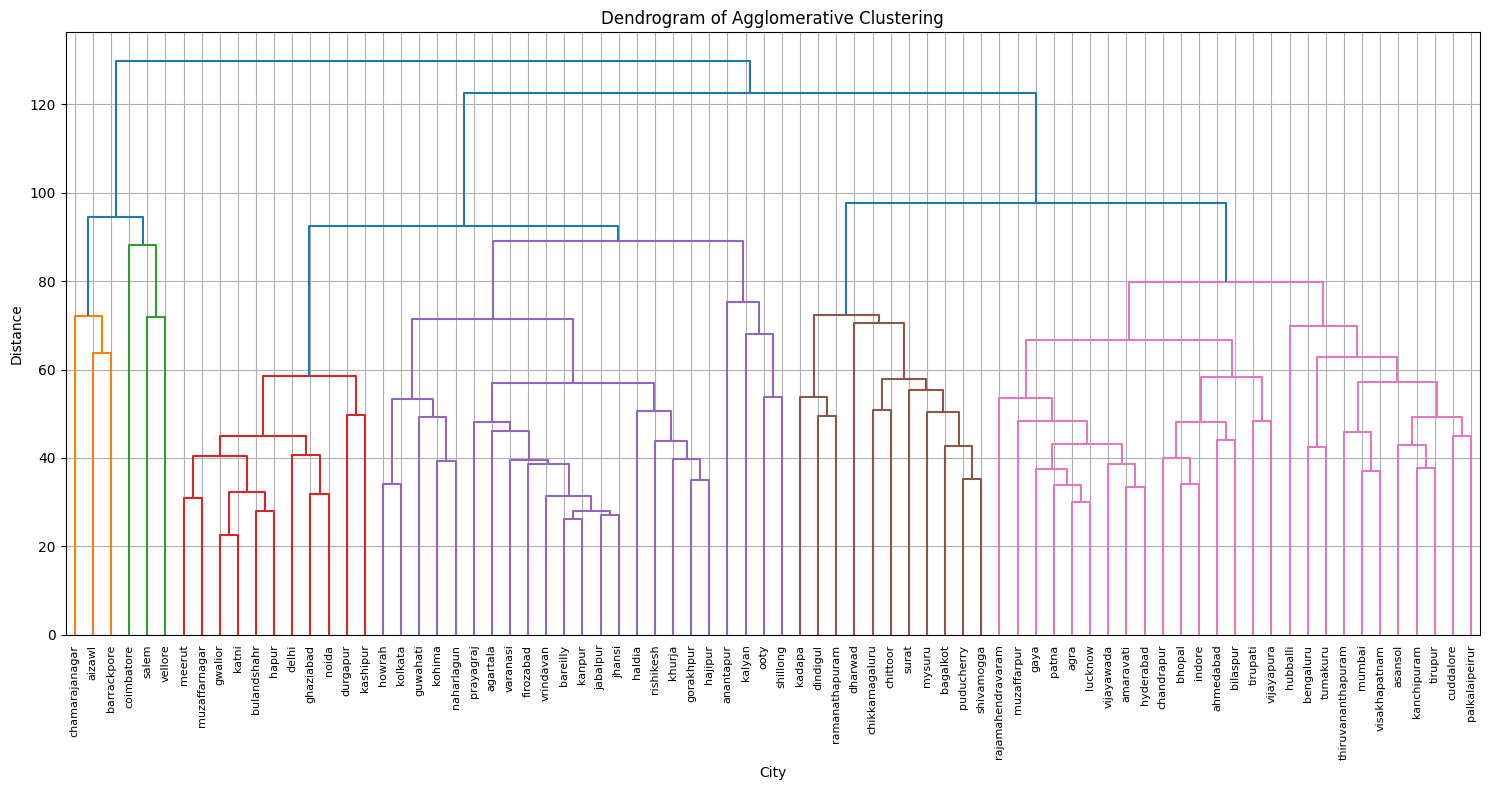

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
import numpy as np
import json
from scipy.spatial.distance import mahalanobis

file_path = '/content/drive/MyDrive/merged_aggregated_pollutant_statistics_hotweeks_finalstats.csv'
data = pd.read_csv(file_path)

# Drop unwanted columns, including any "Unnamed" columns
columns_to_drop = [col for col in data.columns if "Unnamed" in col]
filtered_data = data.drop(columns=columns_to_drop, errors='ignore')

# Filter out the row corresponding to "Hosur" (if present)
filtered_data = filtered_data[filtered_data['city'] != 'hosur']

# Reset index after filtering
filtered_data.reset_index(drop=True, inplace=True)

# Separate numeric and non-numeric columns
numeric_data = filtered_data.select_dtypes(include=['float64', 'int64'])
non_numeric_data = filtered_data.select_dtypes(exclude=['float64', 'int64'])

# Impute missing values with mean for numeric columns
imputer = SimpleImputer(strategy='mean')
imputed_numeric_data = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

# Encode non-numeric data with OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_non_numeric_data = pd.DataFrame(encoder.fit_transform(non_numeric_data), columns=encoder.get_feature_names_out(non_numeric_data.columns))

# Combine the numeric and encoded non-numeric data
processed_data = pd.concat([imputed_numeric_data, encoded_non_numeric_data], axis=1)

# Scale the combined data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

# Perform Agglomerative Clustering
nclusters = 5
hierarchical_cluster = AgglomerativeClustering(n_clusters=nclusters, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(scaled_data)

filtered_data['Cluster'] = labels

# Compute covariance matrix and its inverse
cov_matrix = np.cov(scaled_data, rowvar=False)
cov_inv = np.linalg.pinv(cov_matrix)

# Calculate centroids of each cluster
centroids = []
for cluster in range(nclusters):
    cluster_data = scaled_data[labels == cluster]
    centroid = np.mean(cluster_data, axis=0)
    centroids.append(centroid)
centroids = np.array(centroids)

# Create dictionary to store city names, centroid, and Mahalanobis distances in each cluster
hot_cluster = {}

if 'city' in filtered_data.columns:
    for cluster in range(nclusters):
        cities_in_cluster = filtered_data[filtered_data['Cluster'] == cluster]['city'].dropna().unique()
        distances_to_centroid = []
        for city_name in cities_in_cluster:
            city_index = filtered_data[filtered_data['city'] == city_name].index[0]
            city_data = scaled_data[city_index]
            centroid = centroids[cluster]
            distance = mahalanobis(city_data, centroid, cov_inv)
            distances_to_centroid.append(distance)

        hot_cluster[cluster] = {
            'Cities': list(cities_in_cluster),
            'Centroid': centroids[cluster].tolist(),
            'Distances_to_Centroid': distances_to_centroid
        }

print("Dictionary of cities, centroids, and Mahalanobis distances in each cluster:")
for cluster, cluster_info in hot_cluster.items():
    print(f"\nCluster {cluster}:")
    print(f"Cities: {', '.join(cluster_info['Cities'])}")
    print(f"Centroid: {cluster_info['Centroid']}")
    print(f"Distances to Centroid: {cluster_info['Distances_to_Centroid']}")

# Save dictionary of cluster information to JSON file
json_output_path = '/content/drive/MyDrive/clusters_city_centroids_distances_hot.json'
with open(json_output_path, 'w') as json_file:
    json.dump(hot_cluster, json_file, indent=4)

print(f'Dictionary saved as JSON file to {json_output_path}')

# Save the clustered data with centroid distances to CSV
output_file_path = '/content/drive/MyDrive/agglomerative_clustered_data_hot_with_centroid_distance.csv'
filtered_data.to_csv(output_file_path, index=False)

print(f'Clustered data saved to {output_file_path}')

# Plot dendrogram
linkage_matrix = linkage(scaled_data, method='ward')
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=filtered_data['city'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogram of Agglomerative Clustering')
plt.xlabel('City')
plt.ylabel('Distance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
weather_conditions_clusters = {
    0: rainy_cluster,  # 0 represents Rainy
    1: windy_cluster,  # 1 represents Windy
    2: hot_cluster,    # 2 represents Hot
    3: cold_cluster    # 3 represents Cold
}

# Ensure keys are integers (they are likely already in that format)
# Convert keys to native Python ints if they are numpy int64 or pandas int
weather_conditions_clusters = {
    int(k): v for k, v in weather_conditions_clusters.items()
}

# Print the nested dictionary (final output)
print("Final Nested Dictionary of Weather Conditions and Clusters:")
print(weather_conditions_clusters)

Final Nested Dictionary of Weather Conditions and Clusters:
{0: {0: {'Cities': ['agartala', 'aizawl', 'asansol', 'bareilly', 'bengaluru', 'bulandshahr', 'delhi', 'durgapur', 'firozabad', 'ghaziabad', 'gorakhpur', 'guwahati', 'gwalior', 'haldia', 'hapur', 'howrah', 'hubballi', 'jabalpur', 'jhansi', 'kalyan', 'kanpur', 'kashipur', 'katni', 'khurja', 'kohima', 'kolkata', 'meerut', 'muzaffarnagar', 'naharlagun', 'noida', 'ooty', 'prayagraj', 'rishikesh', 'shillong', 'surat', 'tumakuru', 'varanasi', 'vrindavan'], 'Centroid': [0.15726296028327713, 0.2402753724895245, 0.3008970968738792, 0.30238384597052964, -0.16746618918234135, -0.24432339426081848, -0.3128228282490145, -0.1661617765532065, -0.16180525674861532, -0.07504935741508546, -0.01891058798512197, -0.033330419375758, 0.005264085886959264, 0.026032376424185814, 0.11163368247009528, 0.1264020851204968, -0.09765317209952923, -0.09462654741891538, 0.038630436247690796, 0.20527724952665394, 0.18985962874211063, 0.13495507708576518, 0.088

In [ ]:
import json

weather_conditions_clusters = {
    0: rainy_cluster,  # 0 represents Rainy
    1: windy_cluster,  # 1 represents Windy
    2: hot_cluster,    # 2 represents Hot
    3: cold_cluster    # 3 represents Cold
}

# Ensure keys are integers (they are likely already in that format)
# Convert keys to native Python ints if they are numpy int64 or pandas int
weather_conditions_clusters = {
    int(k): v for k, v in weather_conditions_clusters.items()
}

# Save the final nested dictionary as a JSON file
final_json_output_path = '/content/drive/MyDrive/weather_conditions_clusters.json'
with open(final_json_output_path, 'w') as json_file:
    json.dump(weather_conditions_clusters, json_file, indent=4)

print(f'Final nested dictionary saved as JSON file to {final_json_output_path}')


Final nested dictionary saved as JSON file to /content/drive/MyDrive/weather_conditions_clusters.json
